In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
from syn_model import *
from filter_data import *


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json

from scipy.stats import kstest
from scipy.spatial import distance

from sklearn.metrics import mean_squared_error
import math
from kneed import DataGenerator, KneeLocator


In [4]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [5]:
from load_and_clean import *

update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

Unable to update Apple mobility data
b'Skipping line 86533: expected 31 fields, saw 40\nSkipping line 86534: expected 31 fields, saw 40\nSkipping line 86535: expected 31 fields, saw 40\nSkipping line 86536: expected 31 fields, saw 40\nSkipping line 86537: expected 31 fields, saw 40\nSkipping line 86538: expected 31 fields, saw 40\nSkipping line 86539: expected 31 fields, saw 40\nSkipping line 86540: expected 31 fields, saw 40\nSkipping line 86541: expected 31 fields, saw 40\nSkipping line 86542: expected 31 fields, saw 40\nSkipping line 86543: expected 31 fields, saw 40\nSkipping line 86544: expected 31 fields, saw 40\nSkipping line 86545: expected 31 fields, saw 40\nSkipping line 86546: expected 31 fields, saw 40\nSkipping line 86547: expected 31 fields, saw 40\nSkipping line 86548: expected 31 fields, saw 40\nSkipping line 86549: expected 31 fields, saw 40\nSkipping line 86550: expected 31 fields, saw 40\nSkipping line 86551: expected 31 fields, saw 40\nSkipping line 86552: expected 

These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'China-Shandong', 'North Macedonia', 'China-Jiangxi', 'France-Reunion', 'China-Tibet', 'China-Hainan', 'Netherlands-Curacao', 'France-Martinique', 'Canada-Ontario', 'China-Jiangsu', 'United Kingdom-Saint Helena, Ascension and Tristan da Cunha', 'Netherlands-Bonaire, Sint Eustatius and Saba', 'Canada-Manitoba', 'China-Fujian', 'China-Hubei', 'China-Anhui', 'United Kingdom-British Virgin Islands', 'France-St Martin', 'MS Zaandam', 'Diamond Princess', 'United Kingdom-Isle of Man', 'Australia-South Australia', 'China-Hebei', 'Canada-Nunavut', 'China-Beijing', 'China-Liaoning', 'Netherlands-Aruba', 'China-Jilin', 'Congo (Kinshasa)', 'United Kingdom-Channel Islands', 'Denmark-Faroe Islands', 'United Kingdom-Jersey', 'Australia-New South Wales', 'France-Saint Barthelemy', 'West Bank and Gaza', 'Kyrgyzstan', 'United Kingdom-Bermuda', 'China-Inner Mongolia', 'Canada-Nova

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap2 = df2.columns &

In [6]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


In [7]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

In [8]:
group_a = eu_countries
group_b = ['US']

group_a_label = "EU"
group_b_label = "US"


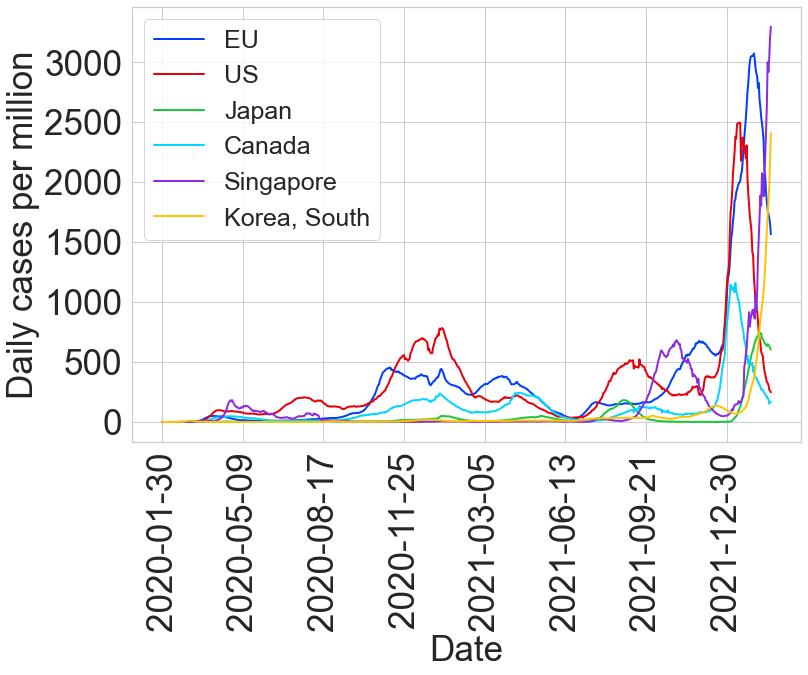

In [9]:
plt.rcParams['figure.figsize'] = (12, 8)
FONTSIZE = 35
dfplot = all_cases_data_pop_daily# all_data_cases_daily

dfplot[group_a].mean(axis=1).plot(label=group_a_label), dfplot[group_b].mean(axis=1).plot(label=group_b_label), 
dfplot['Japan'].plot() , dfplot['Canada'].plot()
#dfplot['South Africa'].plot(), 
dfplot['Singapore'].plot(), 
#dfplot['Japan'].plot(), 

dfplot['Korea, South'].plot(), plt.legend(),
plt.xticks(rotation=90,fontsize = FONTSIZE), plt.xlabel('Date', fontsize = FONTSIZE), plt.ylabel('Daily cases per million',fontsize = FONTSIZE)#, plt.title('Cases')
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = 25, loc='upper left')
#plt.ylim(ymax = 500)

plt.savefig('../Figures/COVID/Global_cases.pdf', bbox_inches='tight')


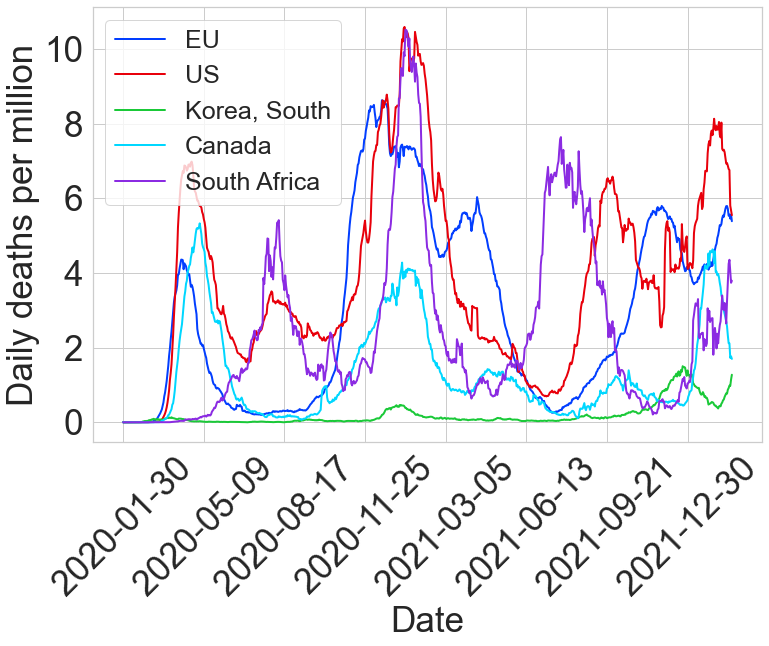

In [28]:
plt.rcParams['figure.figsize'] = (12, 8)
FONTSIZE = 35
dfplot = all_death_data_pop_daily# all_data_cases_daily

dfplot[group_a].mean(axis=1).plot(label=group_a_label), dfplot[group_b].mean(axis=1).plot(label=group_b_label), 
dfplot['Korea, South'].plot(), dfplot['Canada'].plot()
dfplot['South Africa'].plot(), plt.legend(),
plt.xticks(rotation=45,fontsize = FONTSIZE), plt.xlabel('Date', fontsize = FONTSIZE), plt.ylabel('Daily deaths per million',fontsize = FONTSIZE)#, plt.title('Cases')
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = 25, loc='upper left')

#plt.savefig('../Figures/COVID/Global_deaths.pdf', bbox_inches='tight')


In [11]:
# TODO: US regions below are too close

In [12]:
groups = [northeast, west, south, midwest]
group_labels = ["North East", "West", "South", "Midwest"]
southwest = south+west

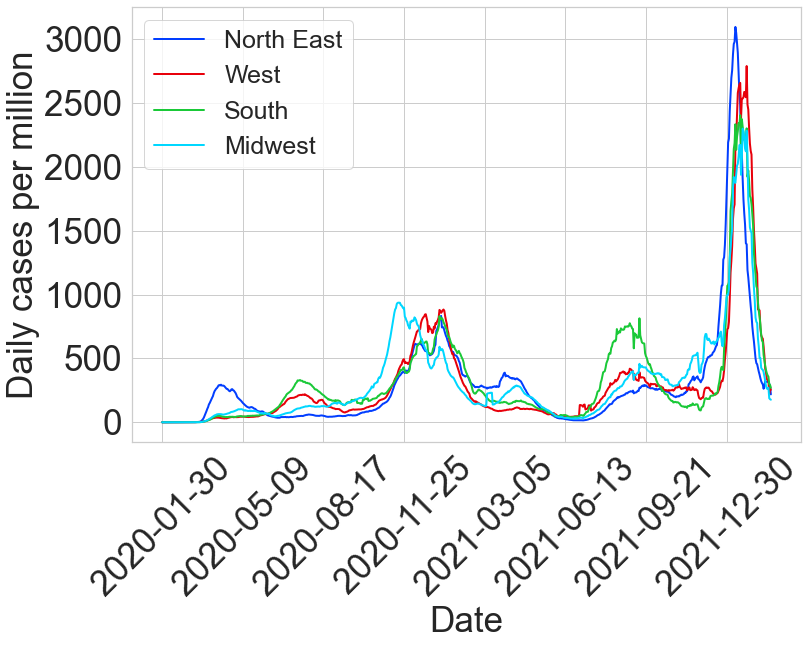

In [31]:
plt.rcParams['figure.figsize'] = (12, 8)
FONTSIZE = 35

dfplot=all_data_cases_daily
i=0
for group in groups:
    (1000000*dfplot[group].sum(axis=1)/(all_population[all_population.index.isin(group)].value.sum())).plot(label=group_labels[i])
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.ylabel('Daily cases per million', fontsize = FONTSIZE), plt.xlabel('Date' , fontsize = FONTSIZE)#, plt.title('Cases'),
    plt.yticks(fontsize = FONTSIZE)
    plt.legend(fontsize = 25, loc='upper left')
    i=i+1

plt.savefig('../Figures/COVID/US_cases.pdf', bbox_inches='tight')


## finding the knee of the curve for Omicron => set as intervention

sensitivity: 10
North East 2021-12-01


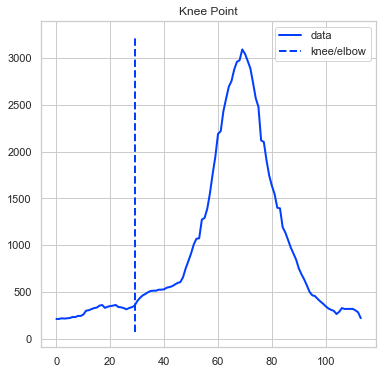

sensitivity: 10
West 2021-12-01


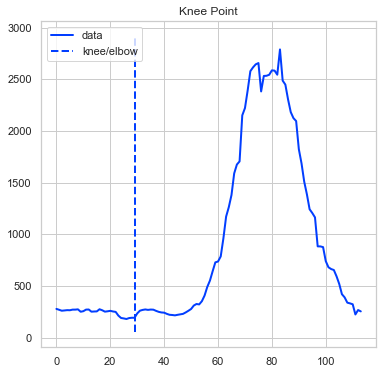

sensitivity: 10
South 2021-11-28


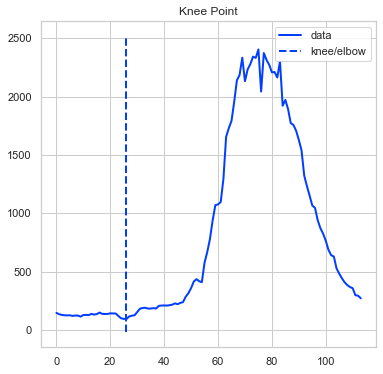

sensitivity: 10
Midwest 2021-11-14


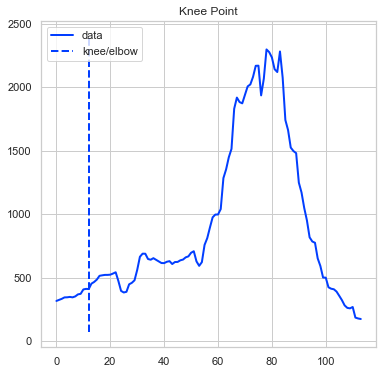

sensitivity: 12
North East 2021-12-01


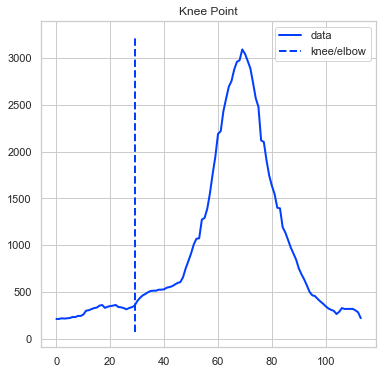

sensitivity: 12
West 2021-12-01


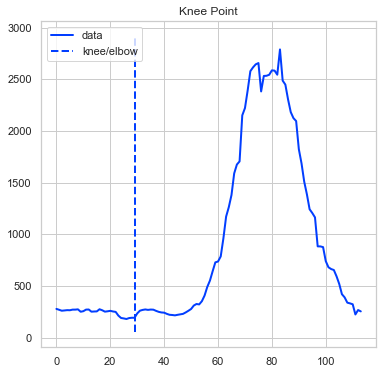

sensitivity: 12
South 2021-11-28


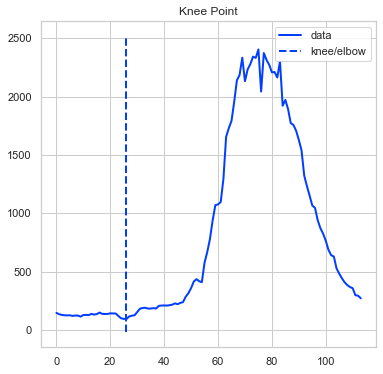

sensitivity: 12
Midwest 2021-11-14


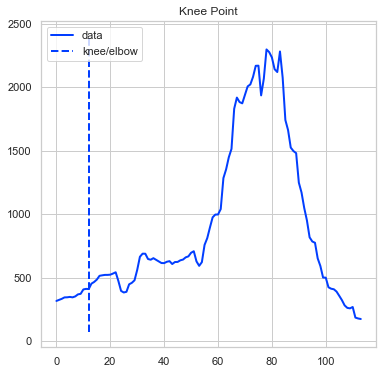

sensitivity: 14
North East 2021-12-01


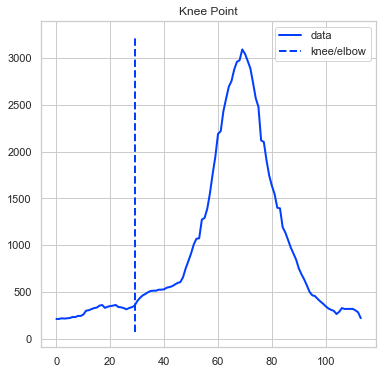

sensitivity: 14
West 2021-12-01


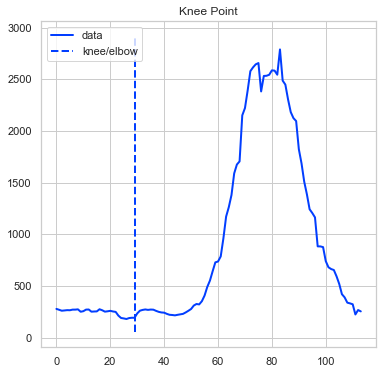

sensitivity: 14
South 2021-11-28


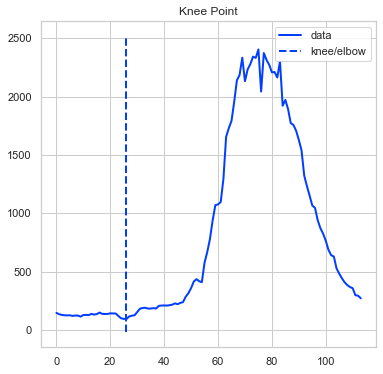

sensitivity: 14
Midwest 2021-11-14


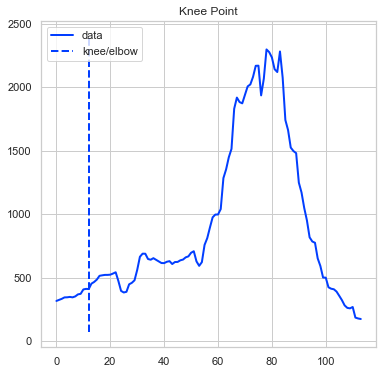

sensitivity: 16
North East 2022-01-09


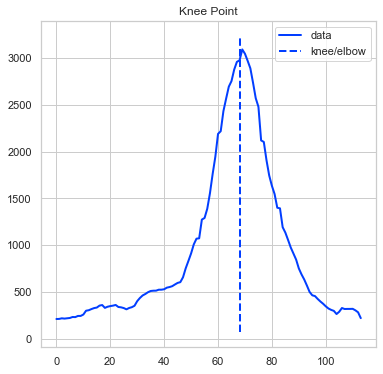

sensitivity: 16
West 2021-12-01


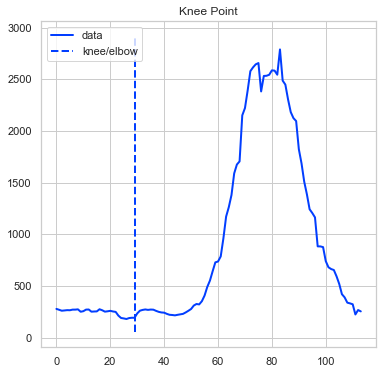

sensitivity: 16
South 2021-11-28


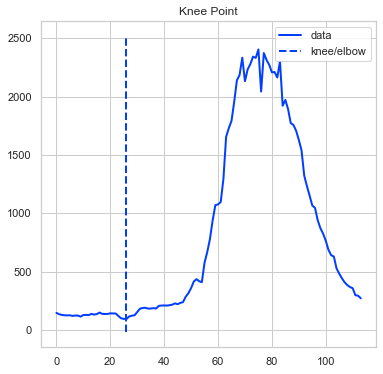

sensitivity: 16
Midwest 2021-11-14


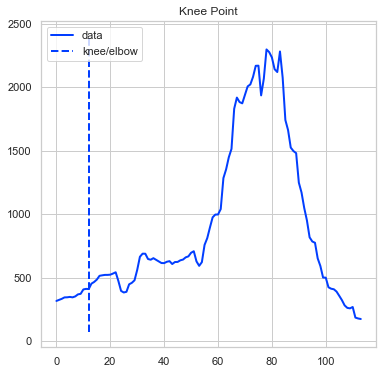

sensitivity: 18
North East 2022-01-09


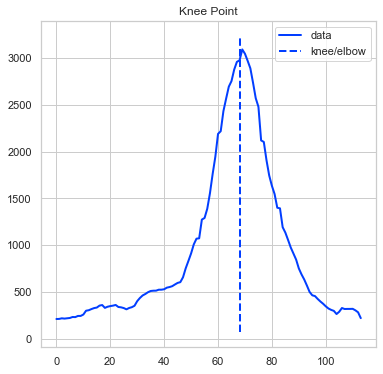

sensitivity: 18
West 2021-12-01


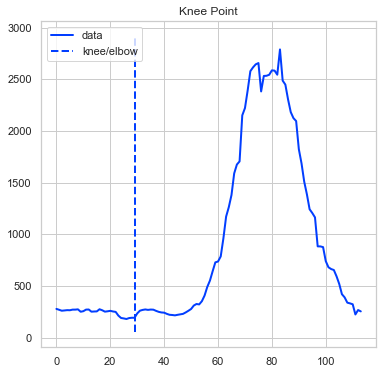

sensitivity: 18
South 2021-11-28


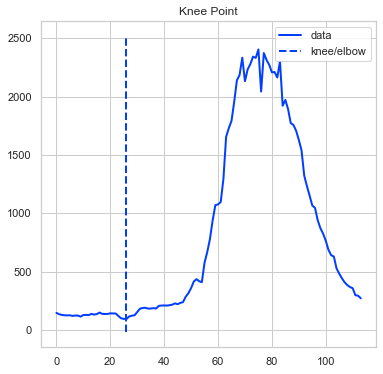

sensitivity: 18
Midwest 2021-11-14


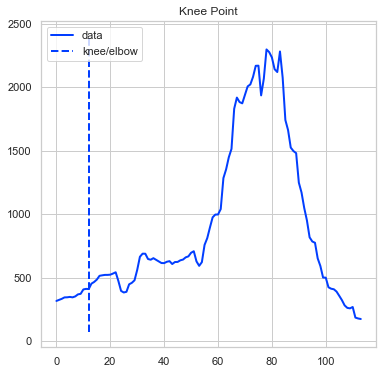

sensitivity: 20
North East 2022-01-09


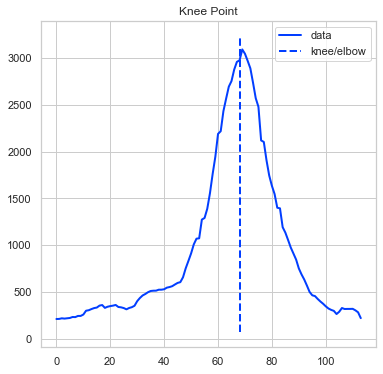

sensitivity: 20
West 2021-12-01


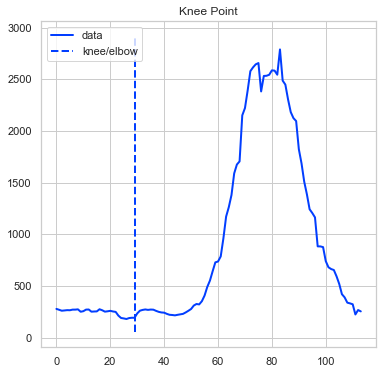

sensitivity: 20
South 2021-11-28


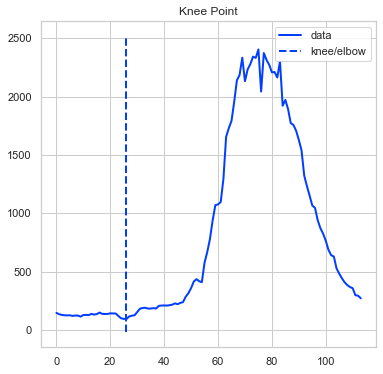

sensitivity: 20
Midwest 2021-11-14


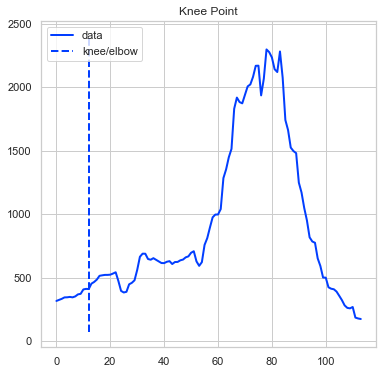

In [35]:
#intervention_dates = {}
sensitivity = [10, 12, 14,16, 18, 20]
for s in sensitivity:
    for i,group in enumerate(groups):
        Omicron_data = (1000000*dfplot[group].sum(axis=1)/(all_population[all_population.index.isin(group)].value.sum()))
        Omicron_data = Omicron_data[pd.to_datetime(Omicron_data.index)  > datetime.datetime.strptime("2021-11-01","%Y-%m-%d" )]

        x = [i for i in range(len(Omicron_data))]
        kl = KneeLocator(x, Omicron_data.to_list(), 
                         curve="convex", direction="increasing",online=True , interp_method="interp1d", S=s)
        #intervention_dates[group_labels[i]] = Omicron_data.index[kl.knee]
        print('sensitivity:', s)
        print(group_labels[i],Omicron_data.index[kl.knee] )
        kl.plot_knee()

        plt.show()


## Omicron intevention based on data

In [93]:
# source : https://www.nbcchicago.com/news/local/the-omicron-variant-is-confirmed-in-16-us-states-heres-where-and-what-we-know-about-each-case/2700769/
# https://www.beckershospitalreview.com/public-health/states-where-the-omicron-variant-has-been-detected.html
omincron_variant_data_US = {'Alabama': '2021-12-16',
                            'Alaska':'2021-12-13',
                            'Arizona': '2021-12-08',
                            'Arkansas': '2021-12-17',
                            'California': '2021-12-01',
                            'Colorado': '2021-12-02',
                            'Connecticut': '2021-12-04',
                            'Delaware': '2021-12-17',
                            'Florida': '2021-12-07',
                            'Georgia': '2021-12-03',
                            'Hawaii': '2021-12-02',
                            'Idaho': '2021-12-10',
                            'Illinois': '2021-12-07',
                            'Indiana': '2021-12-19',
                            'Iowa': '2021-12-09',
                            'Kansas': '2021-12-16',
                            'Kentucky': '2021-12-17', # https://www.wymt.com/2021/12/17/first-case-omicron-variant-confirmed-kentucky/
                            'Louisiana': '2021-12-03',
                            'Maine': '2021-12-17',
                            'Maryland': '2021-12-03',
                            'Massachusetts': '2021-12-04',
                            'Michigan': '2021-12-09',
                            'Minnesota': '2021-12-02',
                            'Mississippi': '2021-12-06',
                            'Missouri': '2021-12-03',
                            'Montana': '2021-12-20',
                            'Nebraska': '2021-12-03',
                            'New Hampshire': '2021-12-13',
                            'New Jersey': '2021-12-03', #https://www.inquirer.com/news/omicron-first-new-jersey-case-gov-murphy-20211204.html
                            'New Mexico': '2021-12-13', 
                            'Nevada':'2021-12-13', 
                            'New York': '2021-12-02',
                            'North Carolina': '2021-12-10',
                            'North Dakota': '2021-12-19',
                            'Ohio':  '2021-12-10',
                            'Oklahoma': '2021-12-21',
                            'Oregon': '2021-12-13',
                            'Pennsylvania': '2021-12-03',
                            'Rhode Island':'2021-12-11',
                            'South Carolina': '2021-12-15',
                            'South Dakota': '2021-12-22',
                            'Tennessee': '2021-12-11',
                            'Texas': '2021-12-06', # https://www.kxan.com/news/texas/texas-announces-first-detected-case-of-omicron-variant-in-harris-county/
                            'Utah': '2021-12-03',
                            'Vermont':'2021-12-18',
                            'Virginia': '2021-12-09',
                            'Wisconsin': '2021-12-04',
                            'Washington': '2021-12-04',
                            'District of Columbia': '2021-12-12',
                            'West Virginia':'2021-12-16',
                            'Wyoming':'2021-12-17',
                     }



omicron_date_diff = {key: 
                      (datetime.datetime.strptime(omincron_variant_data_US[key],"%Y-%m-%d")-datetime.datetime.strptime("2021-11-01","%Y-%m-%d" ) ).days
                      for key in omincron_variant_data_US}



d = {'country': ['USA']*len(omincron_variant_data_US), 'name': omincron_variant_data_US.keys(), 'date':omincron_variant_data_US.values()}
interventions_omicron = pd.DataFrame(data=d)

early_omicron_states = [key for key in omincron_variant_data_US if datetime.datetime.strptime(omincron_variant_data_US[key],"%Y-%m-%d") < datetime.datetime.strptime("2021-12-09","%Y-%m-%d" )]

late_omicron_states = [key for key in omincron_variant_data_US if datetime.datetime.strptime(omincron_variant_data_US[key],"%Y-%m-%d") > datetime.datetime.strptime("2021-12-14","%Y-%m-%d" )]



In [87]:
late_omicron_states

['Alabama',
 'Arkansas',
 'Delaware',
 'Indiana',
 'Kansas',
 'Kentucky',
 'Maine',
 'Montana',
 'North Dakota',
 'Oklahoma',
 'South Carolina',
 'South Dakota',
 'Vermont',
 'West Virginia',
 'Wyoming']

## Omicron intevention based on knee point (not good estimate so far)

Connecticut


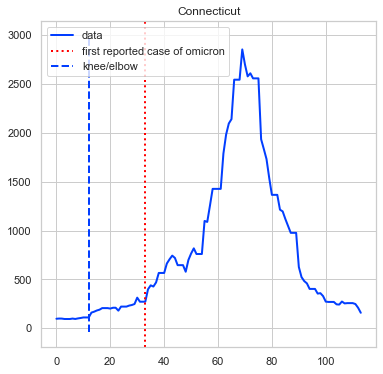

Maine


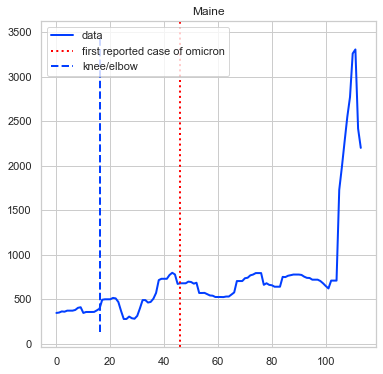

Massachusetts


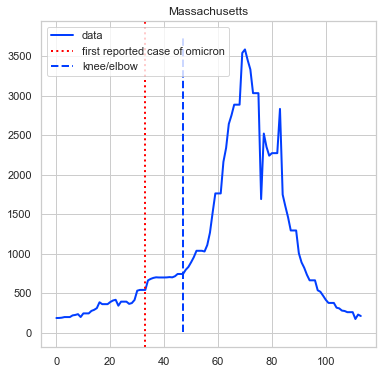

New Hampshire


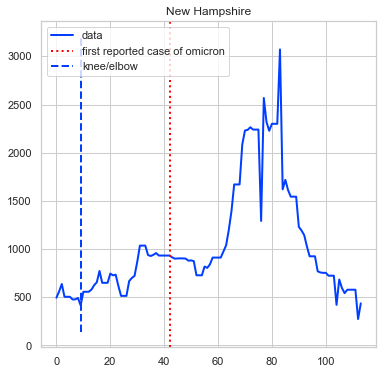

Rhode Island


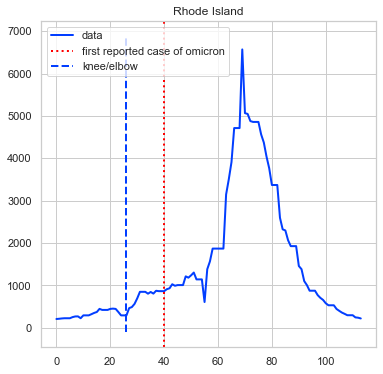

Vermont


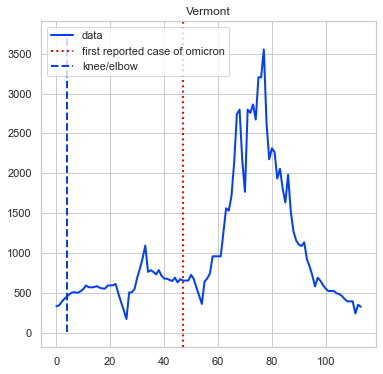

New Jersey


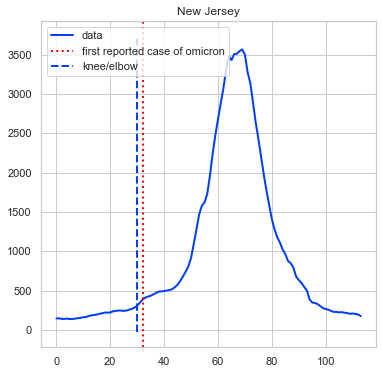

New York


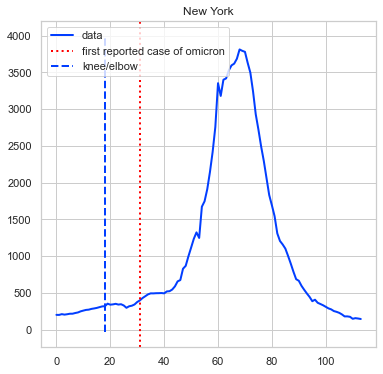

Pennsylvania


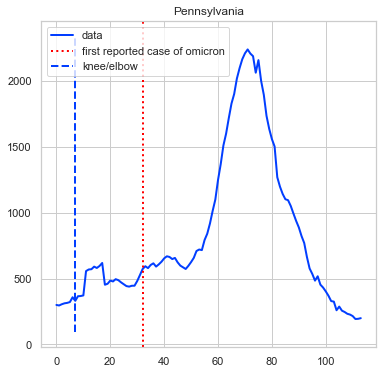

Delaware


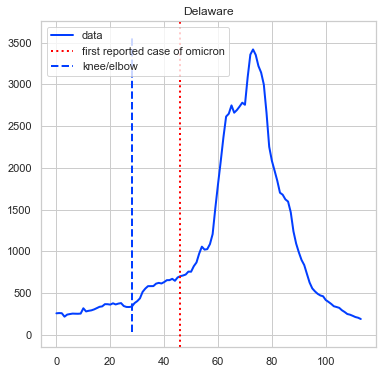

District of Columbia


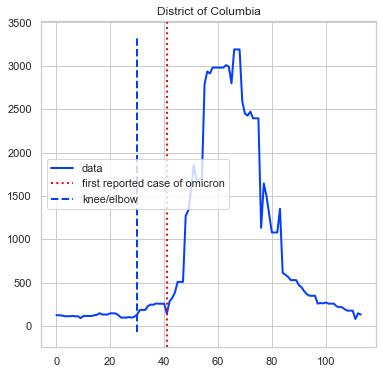

Maryland


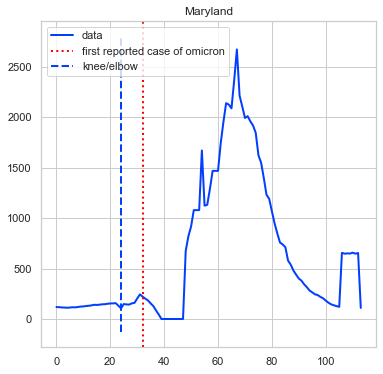

Arizona


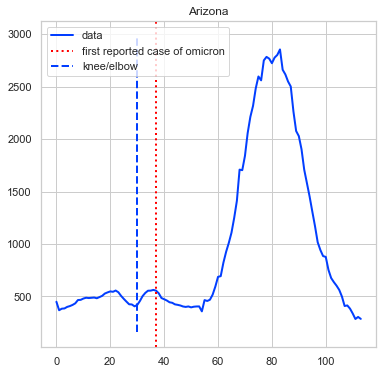

Colorado


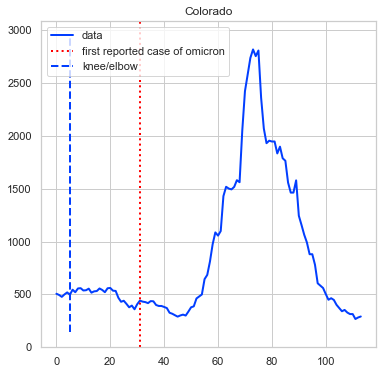

Idaho


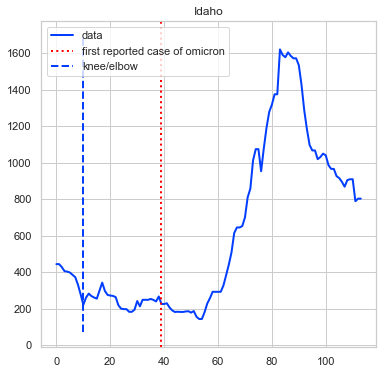

New Mexico


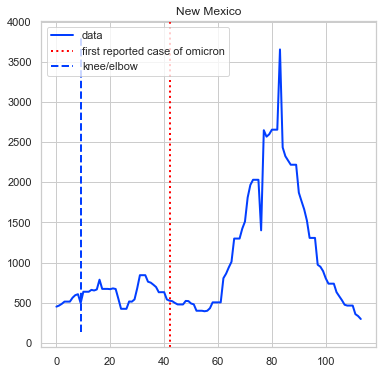

Montana


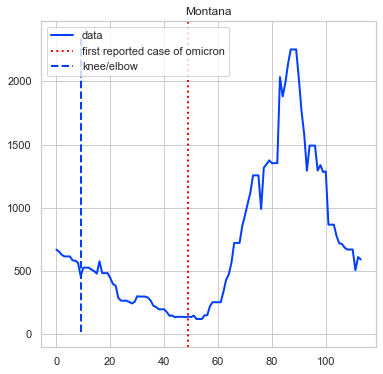

Utah


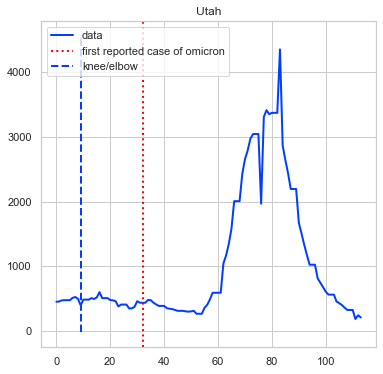

Nevada


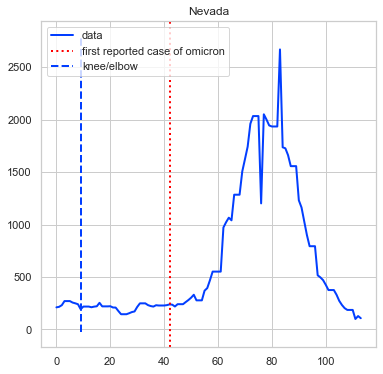

Wyoming


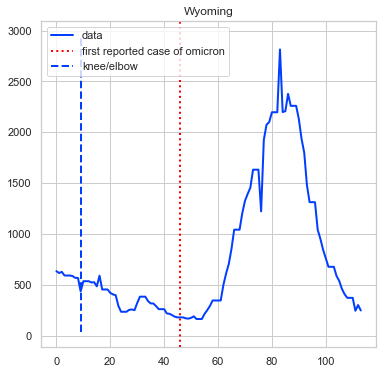

Alaska


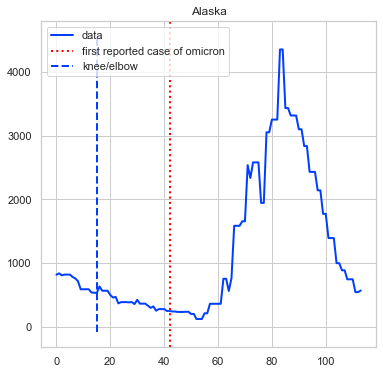

California


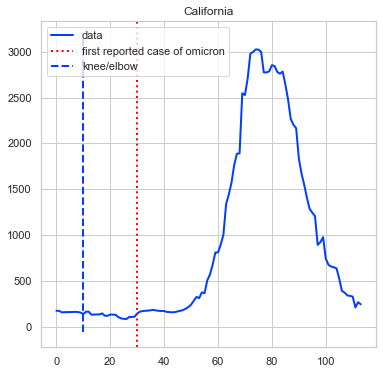

Hawaii


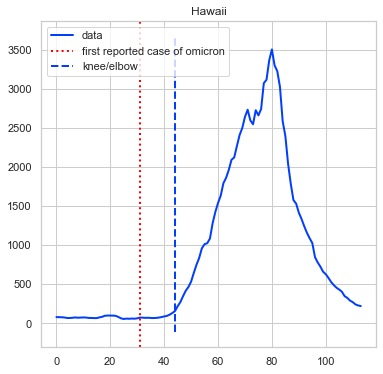

Oregon


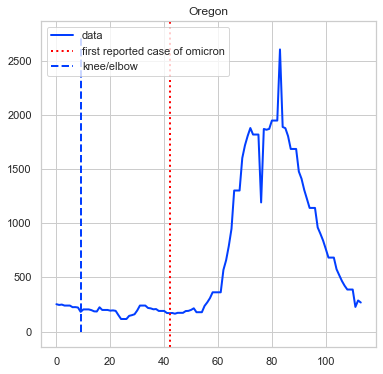

Washington


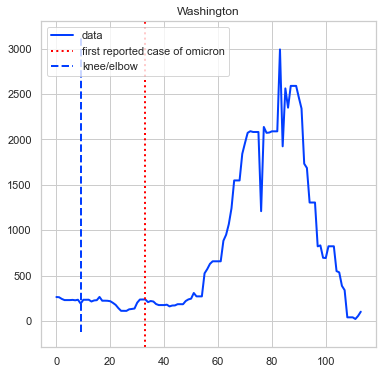

Florida


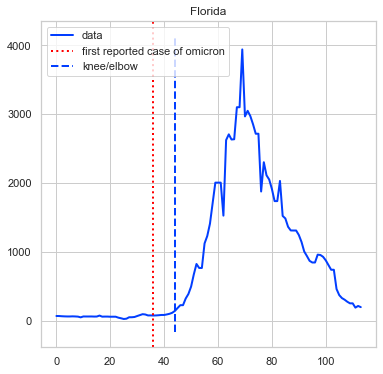

Georgia


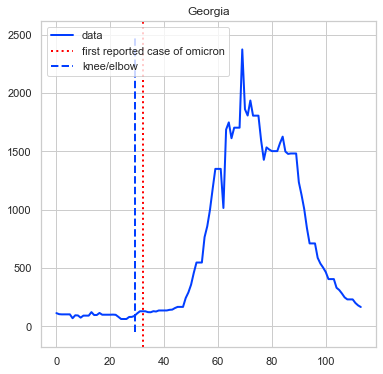

North Carolina


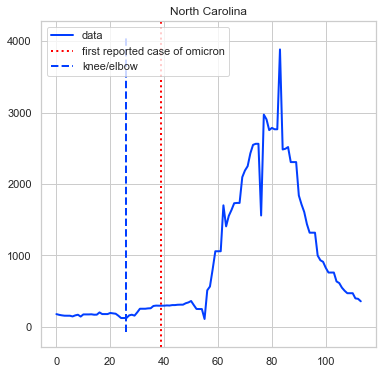

South Carolina


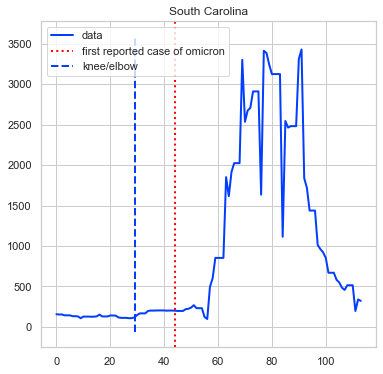

Virginia


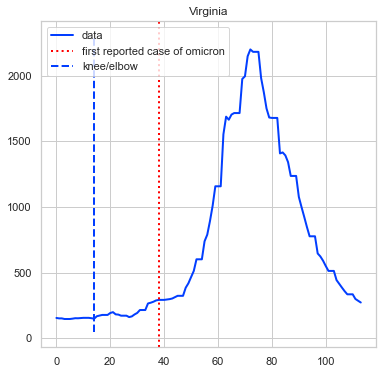

West Virginia


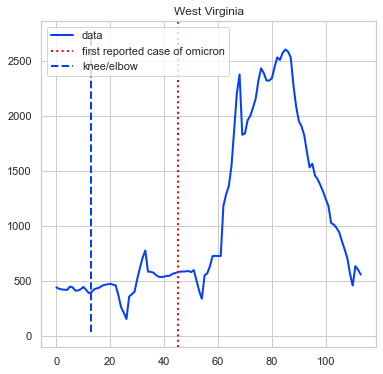

Alabama


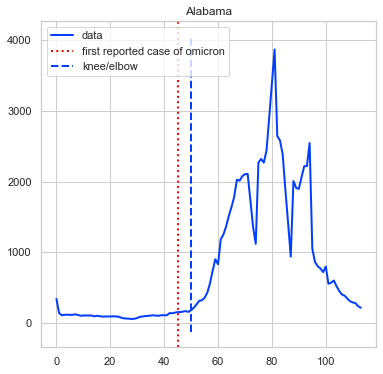

Kentucky


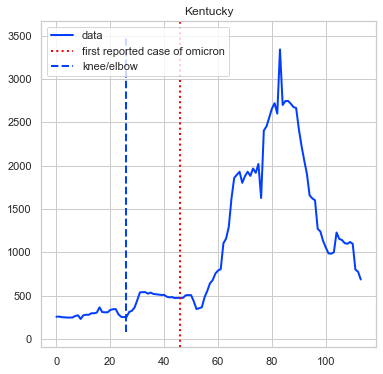

Mississippi


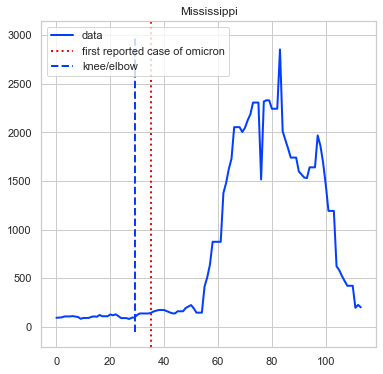

Tennessee


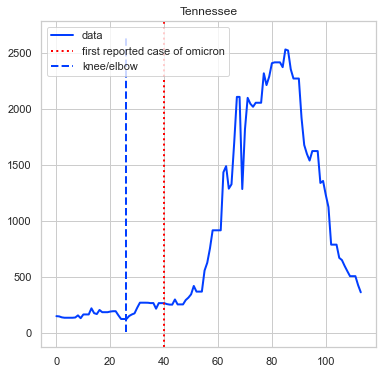

Arkansas


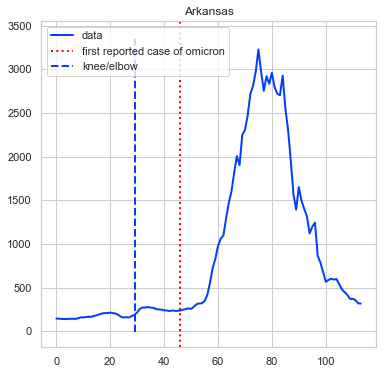

Louisiana


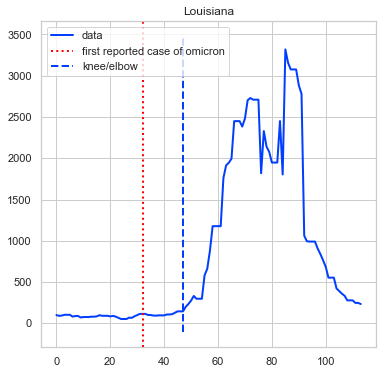

Oklahoma


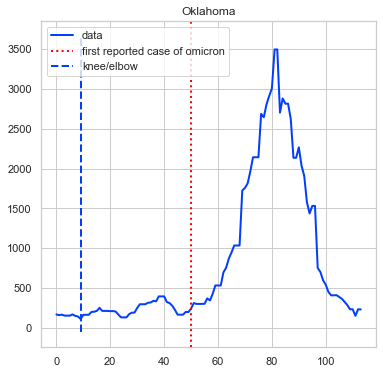

Texas


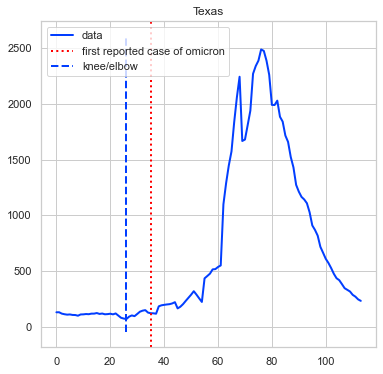

Indiana


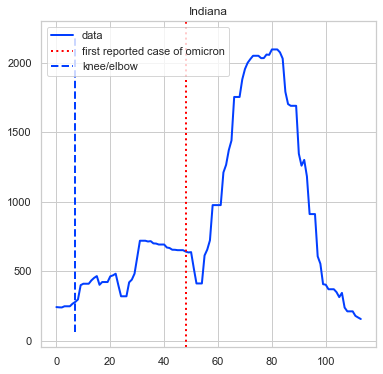

Illinois


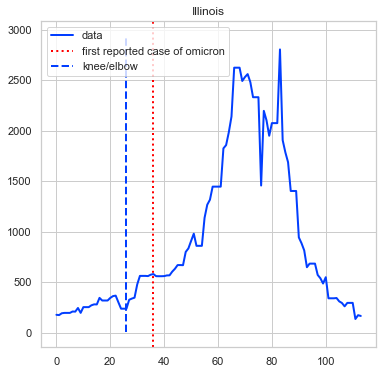

Michigan


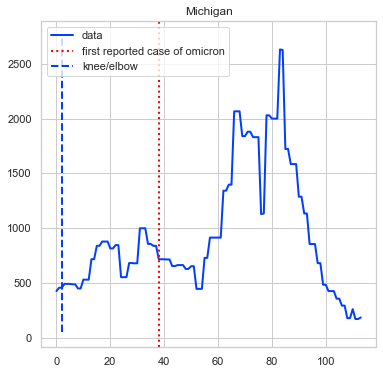

Ohio


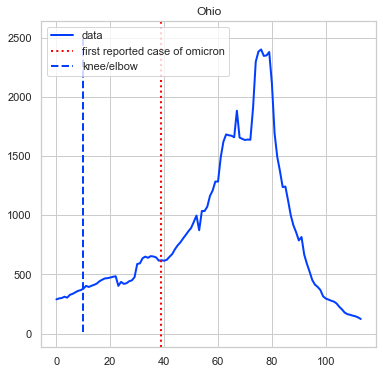

Wisconsin


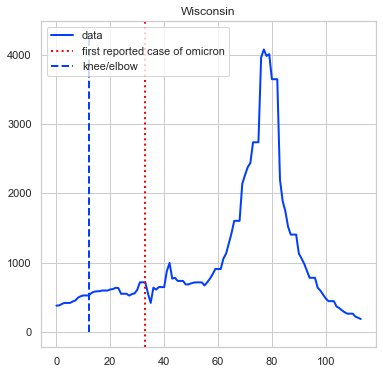

Iowa


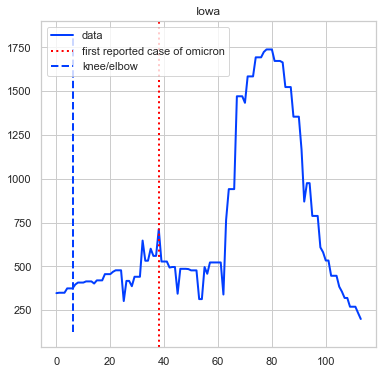

Kansas


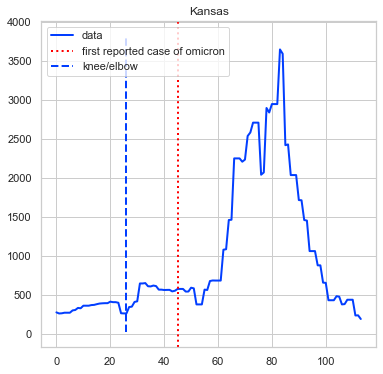

Minnesota


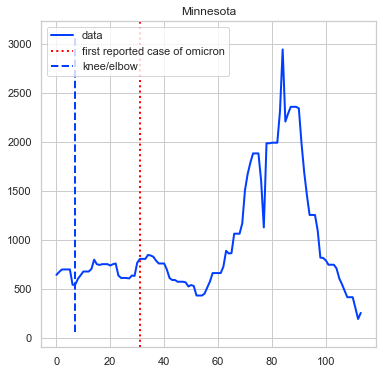

Missouri


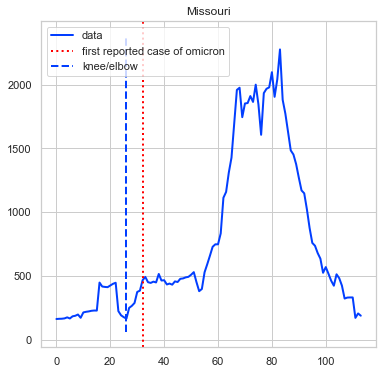

Nebraska


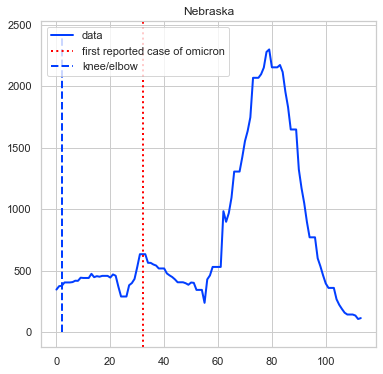

North Dakota


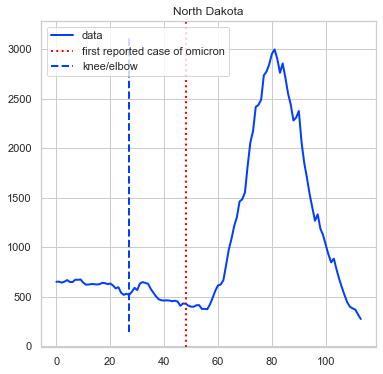

South Dakota


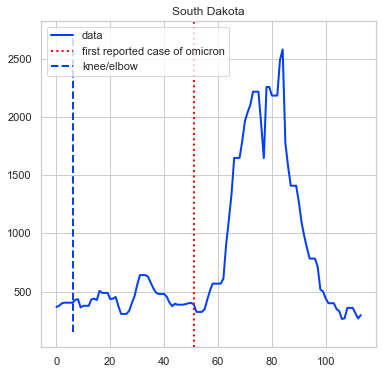

country                  name        date
0      USA           Connecticut  2021-11-14
1      USA                 Maine  2021-11-18
2      USA         Massachusetts  2021-12-19
3      USA         New Hampshire  2021-11-11
4      USA          Rhode Island  2021-11-28
5      USA               Vermont  2021-11-06
6      USA            New Jersey  2021-12-02
7      USA              New York  2021-11-20
8      USA          Pennsylvania  2021-11-09
9      USA              Delaware  2021-11-30
10     USA  District of Columbia  2021-12-02
11     USA              Maryland  2021-11-26
12     USA               Arizona  2021-12-02
13     USA              Colorado  2021-11-07
14     USA                 Idaho  2021-11-12
15     USA            New Mexico  2021-11-11
16     USA               Montana  2021-11-11
17     USA                  Utah  2021-11-11
18     USA                Nevada  2021-11-11
19     USA               Wyoming  2021-11-11
20     USA                Alaska  2021-11-17
21     USA            California  2021-11-12
22     USA                Hawaii  2021-12-16
23     USA                Oregon  2021-11-11
24     USA            Washington  2021-11-11
25     USA               Florida  2021-12-16
26     USA               Georgia  2021-12-01
27     USA        North Carolina  2021-11-28
28     USA        South Carolina  2021-12-01
29     USA              Virginia  2021-11-16
30     USA         West Virginia  2021-11-15
31     USA               Alabama  2021-12-22
32     USA              Kentucky  2021-11-28
33     USA           Mississippi  2021-12-01
34     USA             Tennessee  2021-11-28
35     USA              Arkansas  2021-12-01
36     USA             Louisiana  2021-12-19
37     USA              Oklahoma  2021-11-11
38     USA                 Texas  2021-11-28
39     USA               Indiana  2021-11-09
40     USA              Illinois  2021-11-28
41     USA              Michigan  2021-11-04
42     USA                  Ohio  2021-11-12
43     USA             Wisconsin  2021-11-14
44     USA                  Iowa  2021-11-08
45     USA                Kansas  2021-11-28
46     USA             Minnesota  2021-11-09
47     USA              Missouri  2021-11-28
48     USA              Nebraska  2021-11-04
49     USA          North Dakota  2021-11-29
50     USA          South Dakota  2021-11-08

In [74]:
intervention_dates = {}
df = all_cases_data_pop_daily[pd.to_datetime(all_cases_data_pop_daily.index)  > datetime.datetime.strptime("2021-11-01","%Y-%m-%d" )]

for _,group in enumerate(groups):
    for state in group:
        print(state)
        Omicron_data = df[state]

        x = [i for i in range(len(Omicron_data))]
        kl = KneeLocator(x, Omicron_data.to_list(), 
                         curve="convex", direction="increasing",online=True , interp_method="interp1d", S = 10)
        intervention_dates[state] = Omicron_data.index[kl.knee]
        kl.plot_knee()
        if state in omicron_date_diff:
            plt.axvline(x = omicron_date_diff[state], color = 'red', linestyle=':', label = "first reported case of omicron")
        plt.legend()
        plt.title(state)
        plt.show()
d = {'country': ['USA']*len(intervention_dates), 'name': intervention_dates.keys(), 'date':intervention_dates.values()}
interventions_omicron = pd.DataFrame(data=d)
interventions_omicron


### using one of the interventions (either knee or fixed data scraped for omicron cases) 

In [64]:
omicron_data, omicron_data_daily ,  _ = create_intervention_adjusted_data(all_cases_data_pop, interventions_omicron, t)
omicron_data


Alabama         Alaska        Arizona       Arkansas     California  \
0   174517.583979  208908.542878  178822.311679  179741.958060  128828.489351   
1   174702.769730  208908.542878  179325.559711  180012.353354  129068.617577   
2   174843.902484  209449.862961  179864.665710  180146.888267  129264.885957   
3   174956.482368  209449.862961  180383.163681  180290.701450  129322.842706   
4   175069.062252  210006.219713  180827.060593  180607.156727  129364.247615   
..            ...            ...            ...            ...            ...   
80            NaN            NaN            NaN            NaN  224967.625841   
81            NaN            NaN            NaN            NaN  225034.187522   
82            NaN            NaN            NaN            NaN  225067.670832   
83            NaN            NaN            NaN            NaN  225778.539466   
84            NaN            NaN            NaN            NaN  225987.765862   

         Colorado    Connecticut       Delaware  District of Columbia  \
0   145997.837025  119282.122309  168513.109953          97346.223657   
1   146463.737876  119282.122309  169366.499480          97346.223657   
2   146463.737876  120819.445952  170083.305606          98533.614642   
3   146591.890998  121357.691541  170772.384274          98996.952174   
4   147354.905660  121578.992098  171314.610111          99716.754824   
..            ...            ...            ...                   ...   
80  227052.776859  202215.417721            NaN                   NaN   
81  227516.246621  202366.878178            NaN                   NaN   
82  227893.760020            NaN            NaN                   NaN   
83  228273.357209            NaN            NaN                   NaN   
84            NaN            NaN            NaN                   NaN   

          Florida  ...   South Dakota      Tennessee          Texas  \
0   172458.252934  ...  198097.798135  191266.322984  149930.743611   
1   172546.064793  ...  198581.600368  191266.322984  150102.457656   
2   172653.385224  ...  198581.600368  191809.434055  150247.374791   
3   172766.060037  ...  198581.600368  192071.251955  150371.219967   
4   172886.650023  ...  198581.600368  192379.634785  150978.582096   
..            ...  ...            ...            ...            ...   
80            NaN  ...            NaN            NaN            NaN   
81            NaN  ...            NaN            NaN            NaN   
82            NaN  ...            NaN            NaN            NaN   
83            NaN  ...            NaN            NaN            NaN   
84            NaN  ...            NaN            NaN            NaN   

             Utah       Vermont       Virginia     Washington  West Virginia  \
0   187802.210759  93346.196808  116128.966499  102907.027059  173827.258590   
1   187802.210759  94064.158182  116462.631036  102911.491993  174478.990842   
2   187802.210759  94448.780347  116462.631036  103327.781493  175147.462792   
3   188880.827509  94833.402512  116462.631036  103593.445108  175650.211729   
4   189230.800903  95876.690134  117238.799422  103731.726762  176085.443884   
..            ...           ...            ...            ...            ...   
80  286467.258773           NaN            NaN  185523.946298            NaN   
81  287112.931610           NaN            NaN  185892.040768            NaN   
82  287304.450027           NaN            NaN            NaN            NaN   
83            NaN           NaN            NaN            NaN            NaN   
84            NaN           NaN            NaN            NaN            NaN   

        Wisconsin        Wyoming  
0   171356.515162  196254.399500  
1   171356.515162  196254.399500  
2   171356.515162  196254.399500  
3   171414.051237  196561.954112  
4   173872.301515  196810.762338  
..            ...            ...  
80  269290.643741            NaN  
81  269474.759181            NaN  
82            NaN            Na

Alabama singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


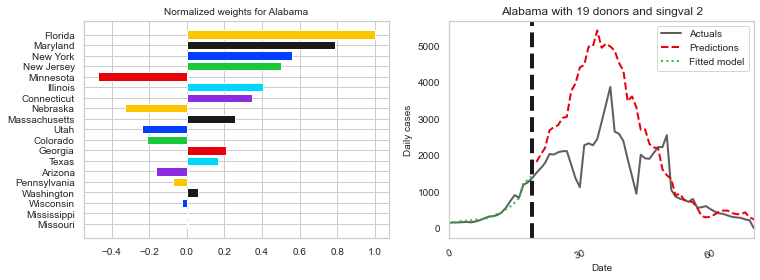

Arkansas singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


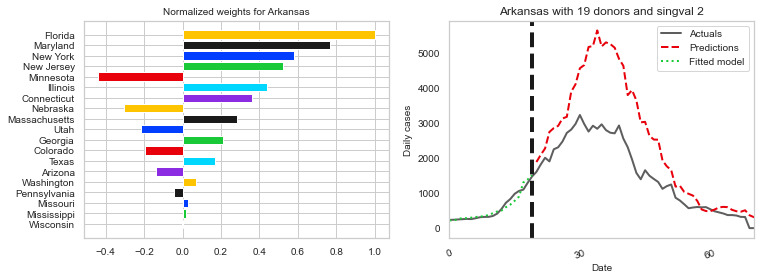

Delaware singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


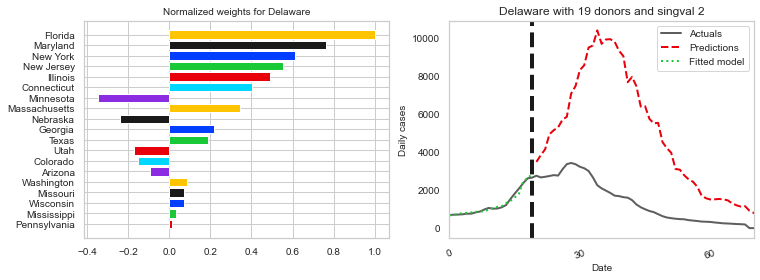

Indiana singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


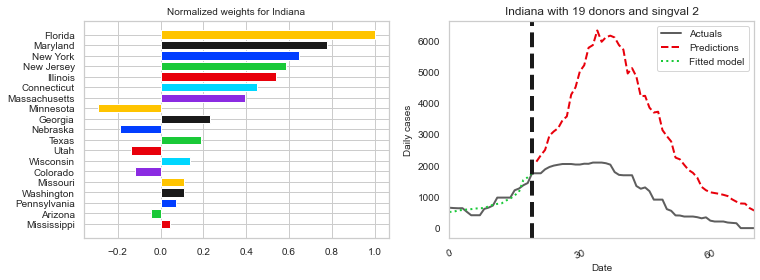

Kansas singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


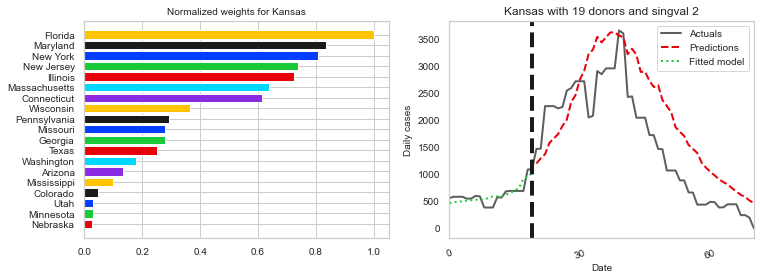

Kentucky singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


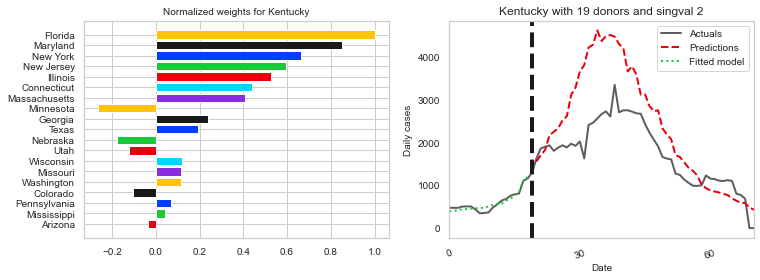

Maine singvals: 2
['California', 'Colorado', 'Connecticut', 'Georgia', 'Hawaii', 'Illinois', 'Maryland', 'Massachusetts', 'Missouri', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Washington']


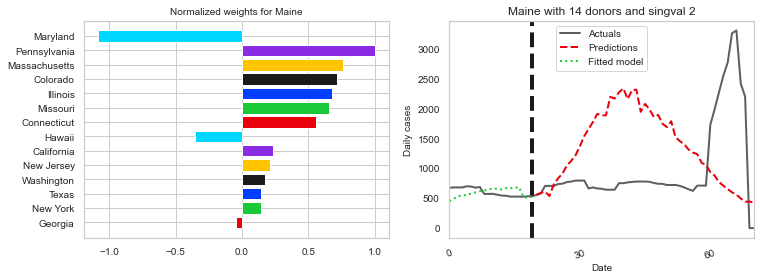

Montana singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


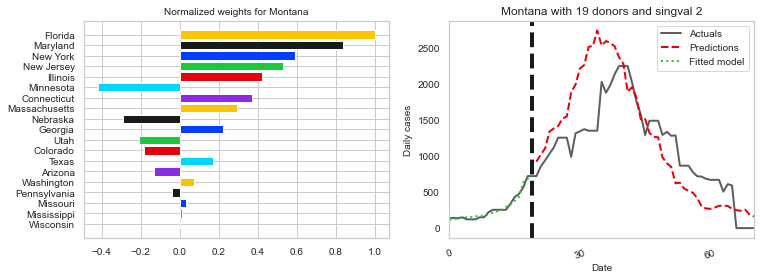

North Dakota singvals: 2
['Arizona', 'California', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Wisconsin']


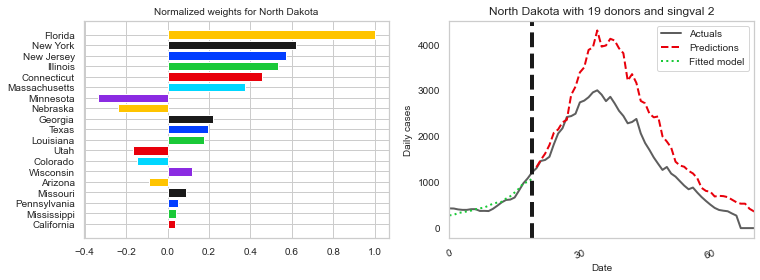

Oklahoma singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


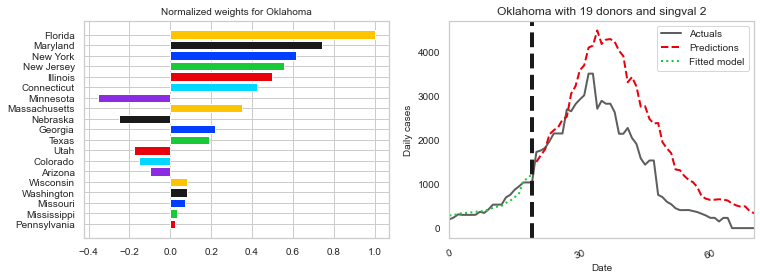

South Carolina singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


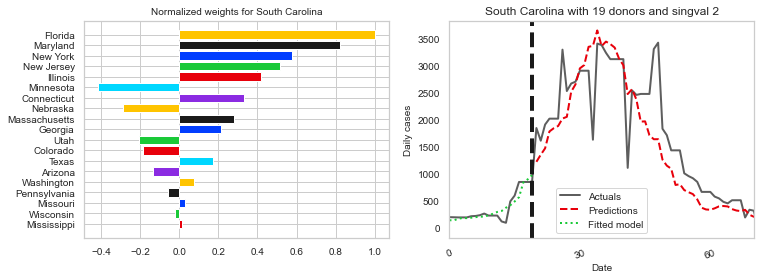

South Dakota singvals: 2
['Arizona', 'California', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Wisconsin']


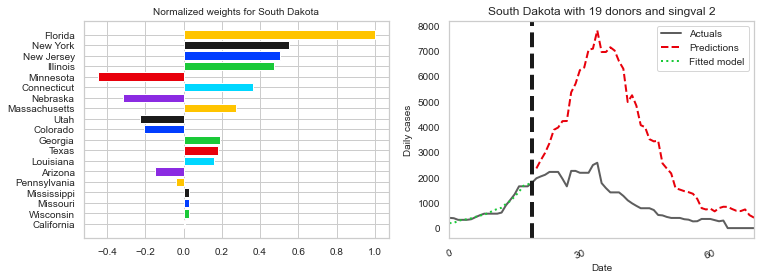

Vermont singvals: 2
['California', 'Colorado', 'Connecticut', 'Georgia', 'Hawaii', 'Illinois', 'Louisiana', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Washington']


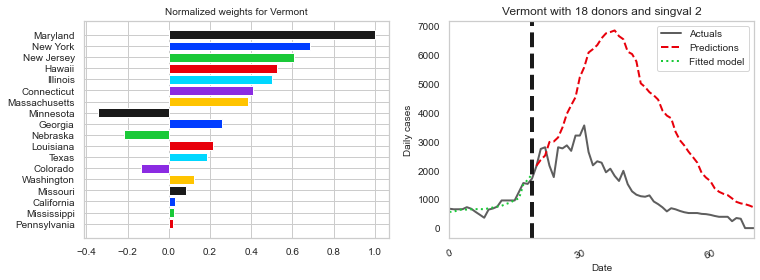

West Virginia singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


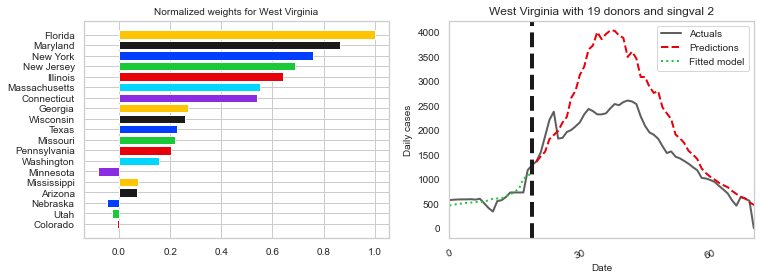

Wyoming singvals: 2
['Arizona', 'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Illinois', 'Maryland', 'Massachusetts', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'New Jersey', 'New York', 'Pennsylvania', 'Texas', 'Utah', 'Washington', 'Wisconsin']


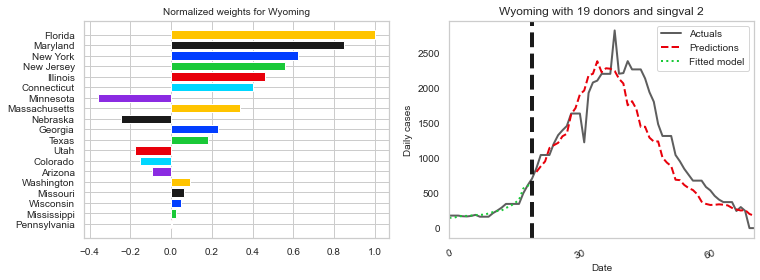

In [96]:
# predict west/south based on North East and Midwest groups = [northeast, west, south, midwest]
#import warnings
FONTSIZE = 10
singVals = 3
warnings.simplefilter('ignore')
projection_period=90
training_period=20
for state in late_omicron_states: #south+west:
    
    try:
        otherStates = omicron_data.columns[(omicron_data.iloc[training_period] < 
                                      omicron_data[state].iloc[training_period]+.5*omicron_data[state].iloc[training_period])&(omicron_data.iloc[training_period]
                                                                                                         > omicron_data[state].iloc[training_period]-0.5*omicron_data[state].iloc[training_period])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(early_omicron_states)]) # list(otherStates[otherStates.isin(northeast+midwest)])
    
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    try:
        rscModel =syn_model(state, singVals, [omicron_data_daily], projection_period, training_period, otherStates=otherStates)

        rscModel.fit_model(filter_donor = True, filter_method = 'hbo', backward_donor_eliminate = True, singVals_estimate = True, singval_mathod ='auto')
        print(state, 'singvals:', rscModel.kSingularValues)
        print(rscModel.donors)
    except Exception as e: 
        print(e)
        continue
    rscModel.plot(figure=fig, axes=axes, title_text="Cases data", xlimit=[0,70], logy=False, show_donors=True, tick_spacing=30, yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    plt.title(state + ' with '+str(len(rscModel.donors))+' donors and singval '+str(rscModel.kSingularValues) )
    '''
    test_MSE[0].append(rscModel.testing_error())
    train_MSE[0].append(rscModel.training_error())
    donor_size[0].append(rscModel.donors)
    singvals[0].append(rscModel.kSingularValues)
    '''
    plt.show()



In [ ]:
# TODO: cases and deaths below are too close

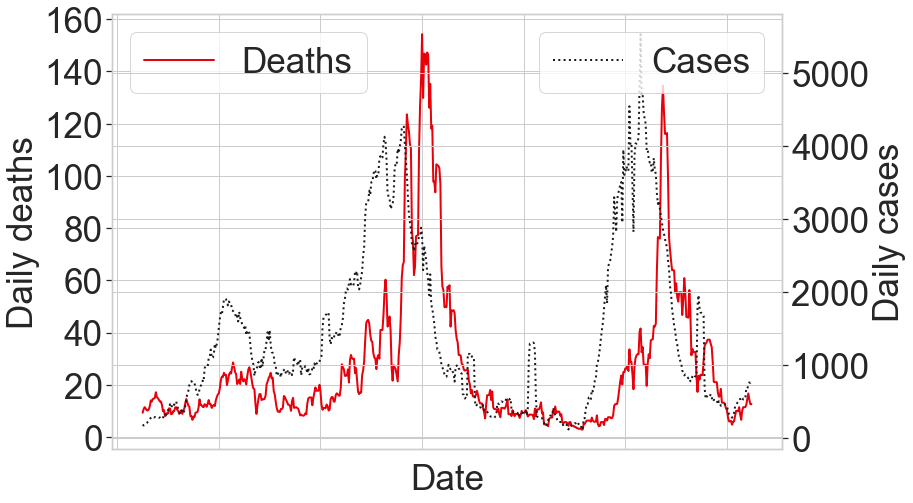

In [15]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Alabama'

#FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

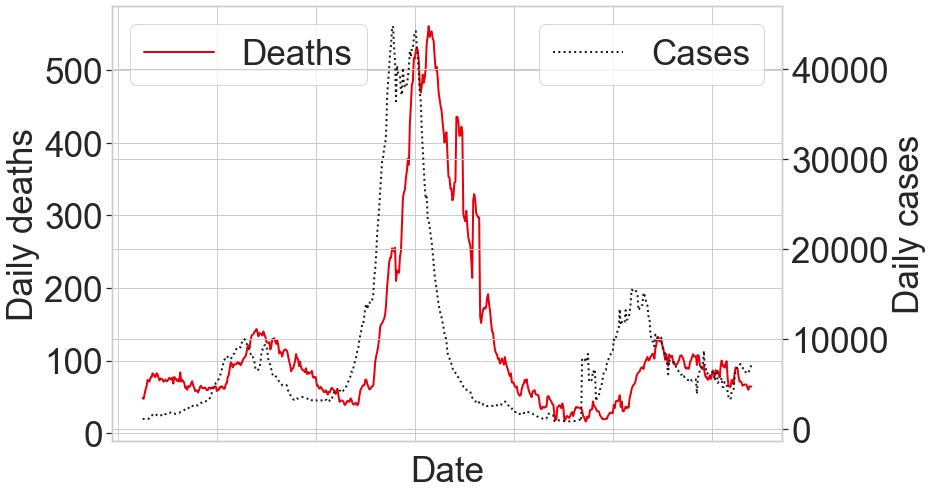

In [16]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='California'

#FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

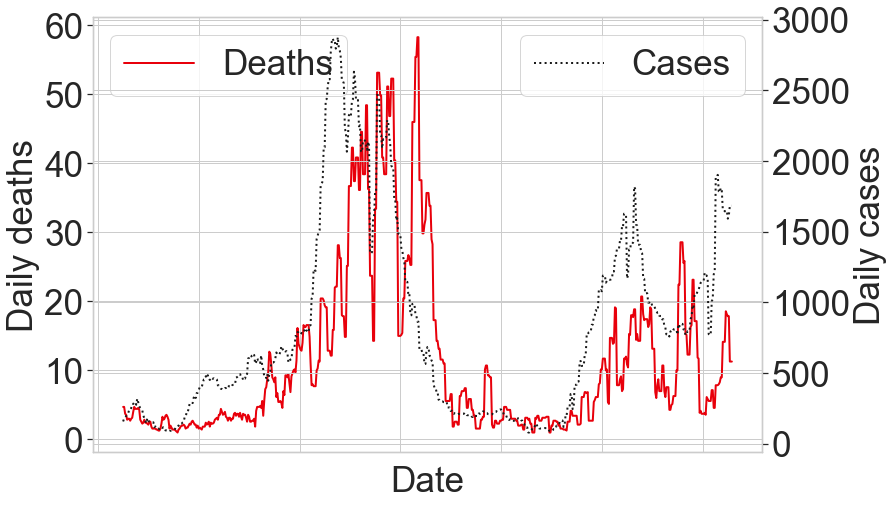

In [17]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Kansas'

#FONTSIZE = 36

deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

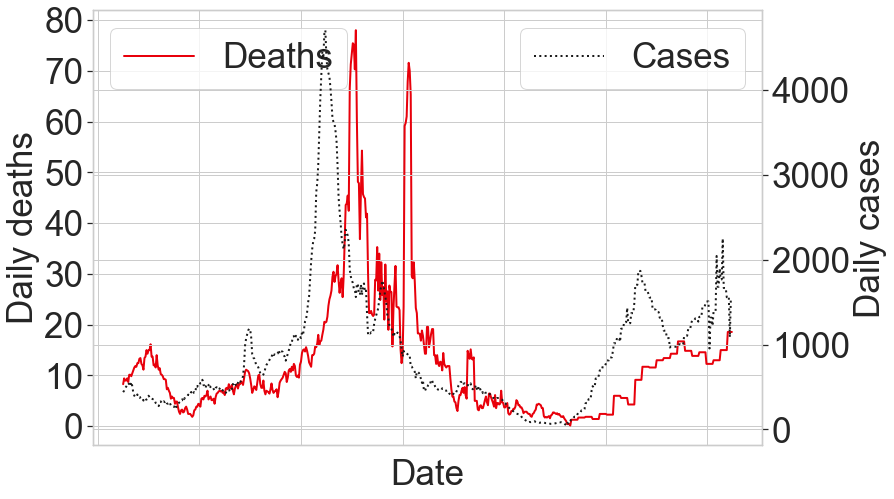

In [18]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='Iowa'


deaths_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
#ax.set_xticks([])
ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
cases_intervention_adjusted_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#ax2.set_xticks([])
ax2.axes.xaxis.set_ticklabels([])

plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

In [19]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})

global_deaths_filtered = create_filtered_data(global_deaths, 100 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)
prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)



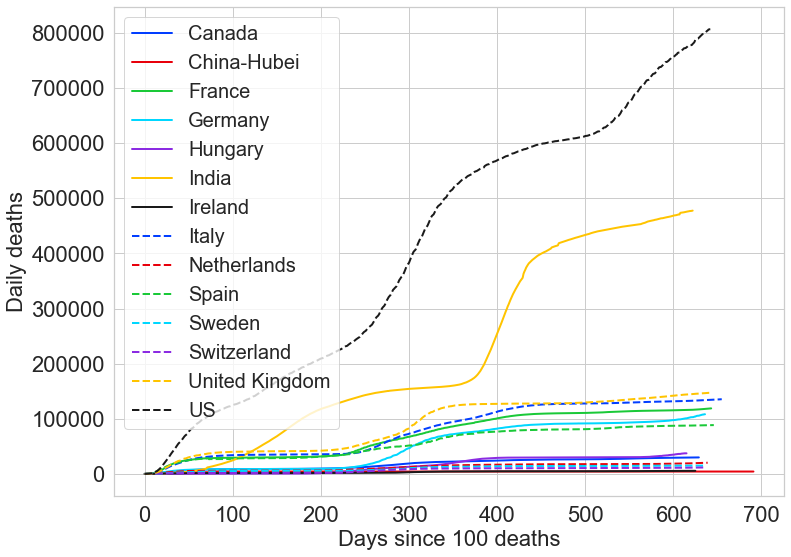

In [20]:
FONTSIZE = 22
fig, ax = plt.subplots()

#group = ['Algeria','Austria', 'Belgium', 'Brazil','Canada-Ontario','Canada-Quebec','China-Hubei','Colombia', 'Czechia', 'Denmark','Ecuador','Egypt','France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom','US']
group = ['Canada','China-Hubei','France', 'Germany', 'Hungary', 'India', 'Ireland', 'Italy', 'Netherlands', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom','US']

plt.rcParams['figure.figsize'] = (16.0, 8.0)
#plt.xlim([0,60])
global_deaths_filtered[group].plot(ax = ax,grid=True), plt.xlabel('Days since 100 deaths', fontsize = FONTSIZE), plt.ylabel('Daily deaths', fontsize = FONTSIZE)
plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = 20)
#plt.xlim(xmax = 200)
#plt.xticks([0,50,100,150,200])

plt.savefig('../Figures/COVID/aligned_100deaths.pdf', bbox_inches='tight')


FONTSIZE = 35

In [ ]:
# TODO: mobility graphs below are too close

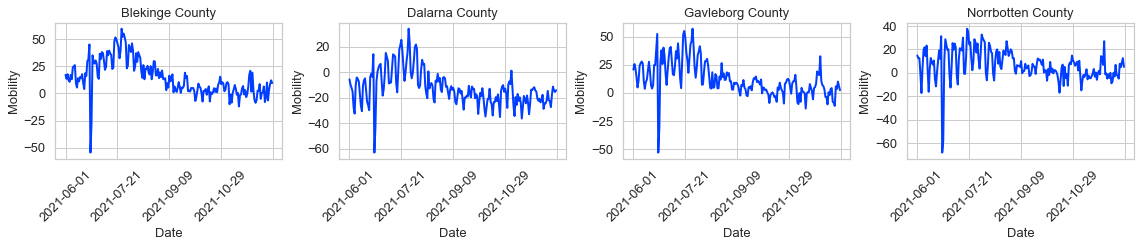

In [33]:

state_list = ['Blekinge County', 'Dalarna County', 'Gavleborg County', 'Norrbotten County']
plt.rcParams['figure.figsize'] = (16,40)

FONTSIZE = 13

#tick_spacing = 30
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "Sweden"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')
#fig, ax = plt.subplots(4)
#fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (16,3))
#fig.tight_layout()
for i in range(4):

    ax = plt.subplot(13,4, i+1)
    plt.tight_layout()

    #plt.setp( ax.get_xticklabels(), visible=False)

    #plt.xticks(rotation=45)

    mobility_us[state_list[i]].tail(200).plot(ax=ax )
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    #ax.tick_params(axis='x', rotation=45)
    plt.xlabel('Date',fontsize = FONTSIZE), plt.ylabel('Mobility',fontsize = FONTSIZE), plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE), plt.title(state_list[i], fontsize = FONTSIZE)


    
plt.savefig('../Figures/COVID/Swedish Counties.pdf', bbox_inches='tight')

plt.show()


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


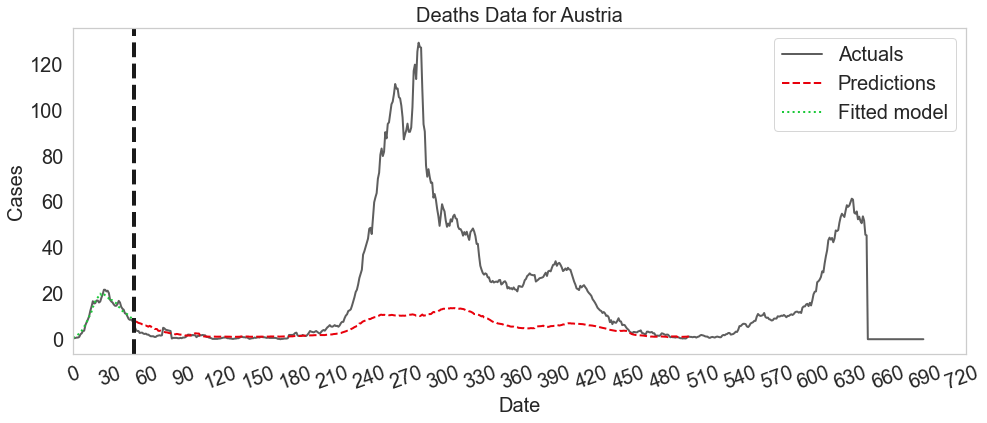

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


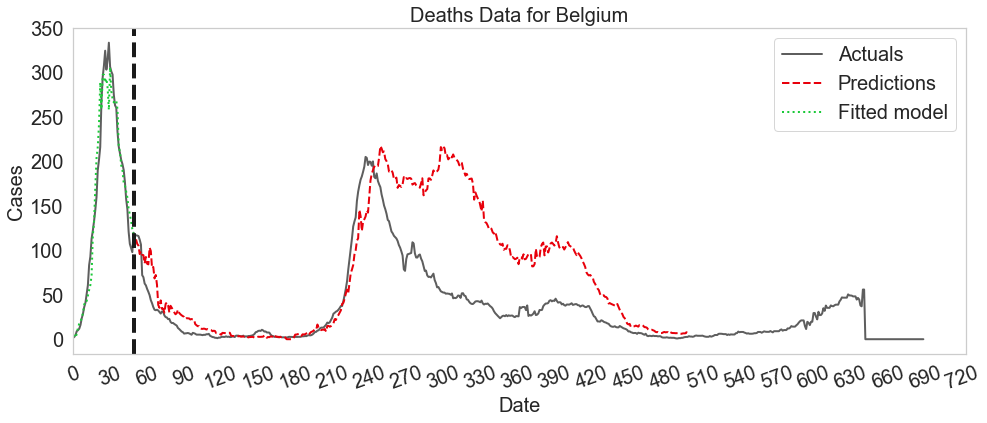

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


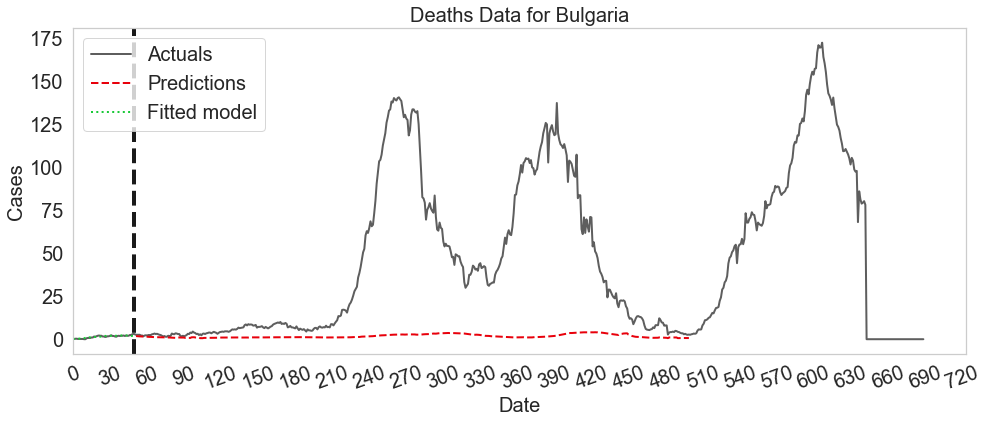

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


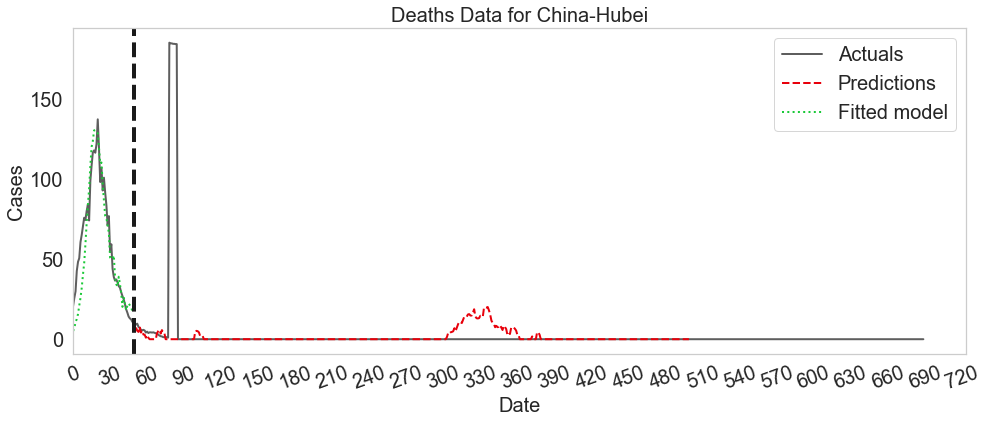

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


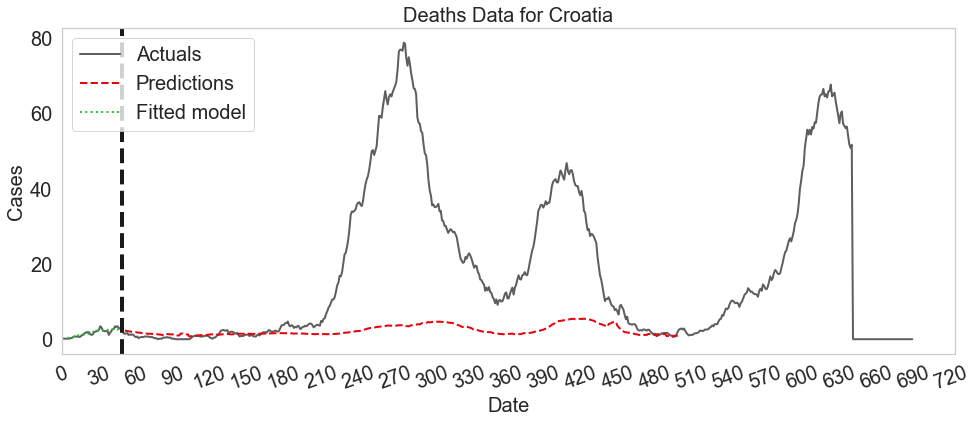

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


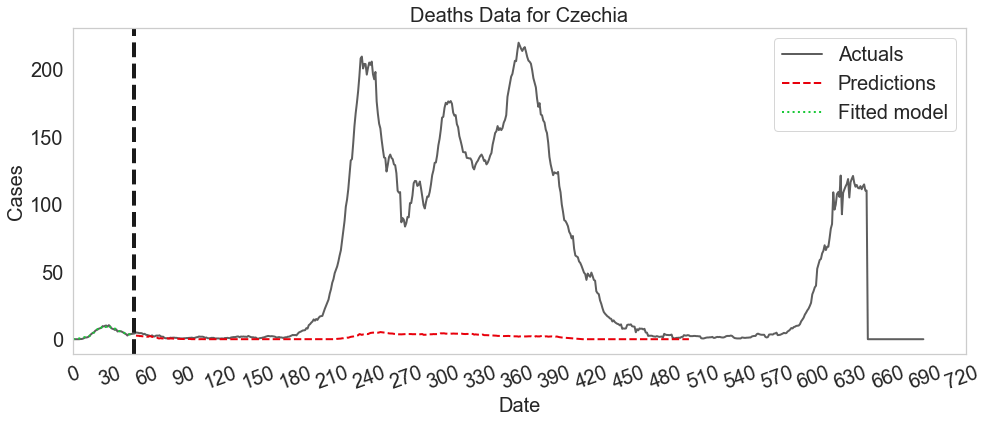

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


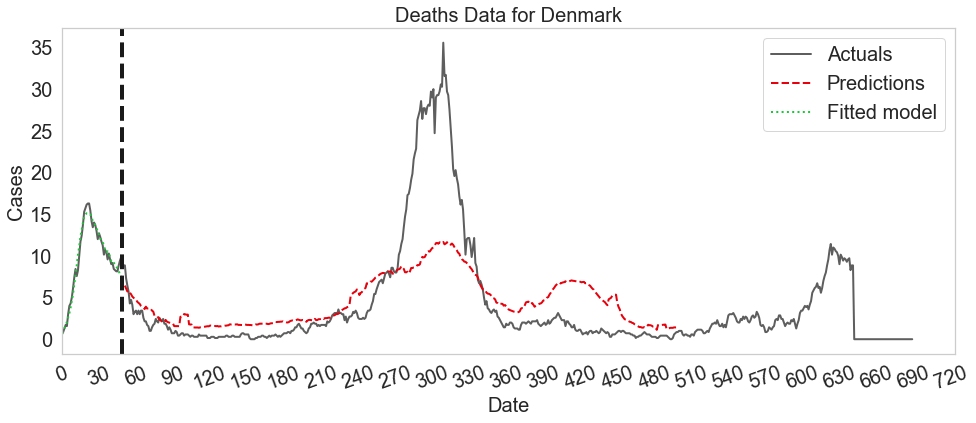

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


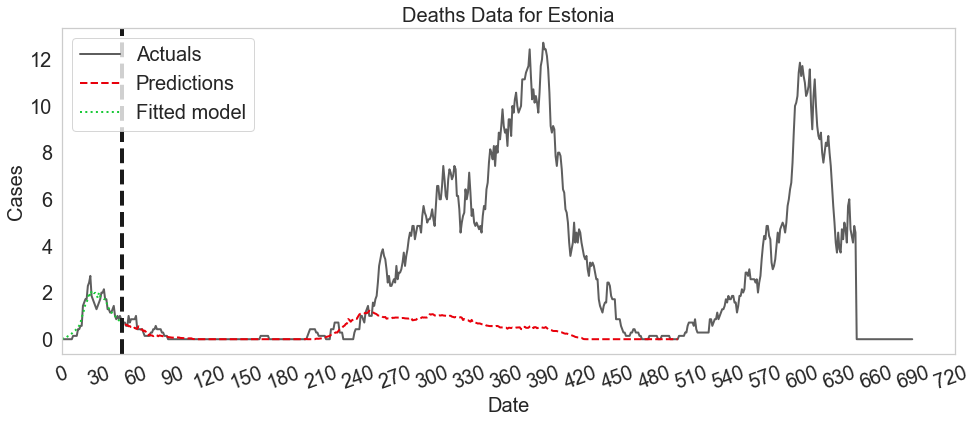

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


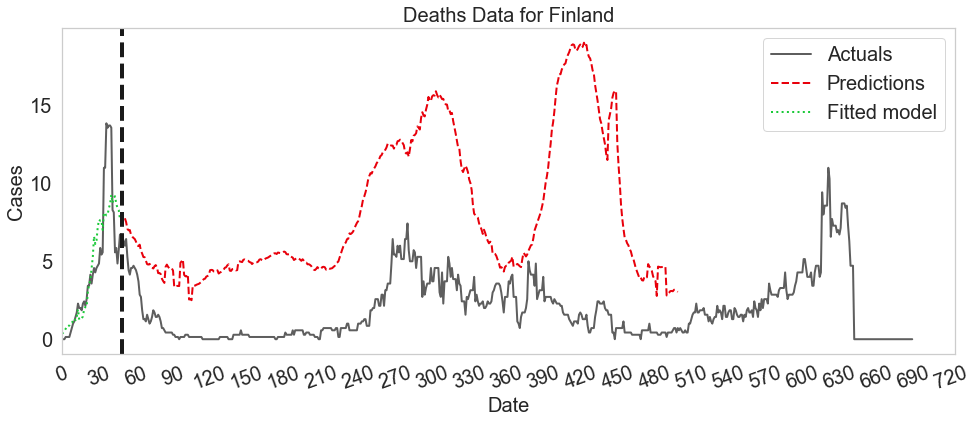

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


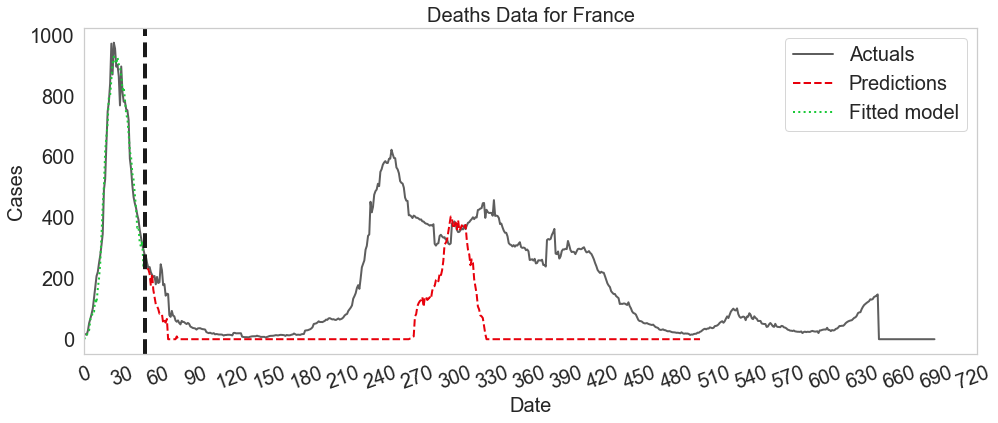

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


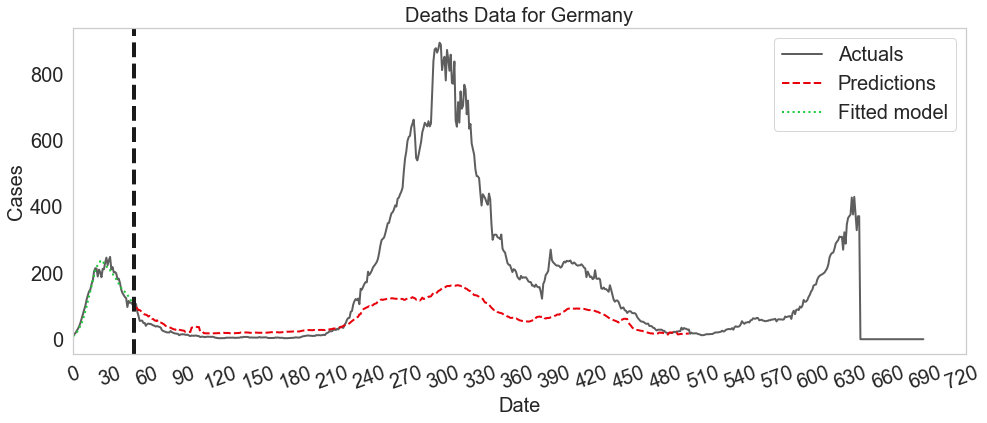

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


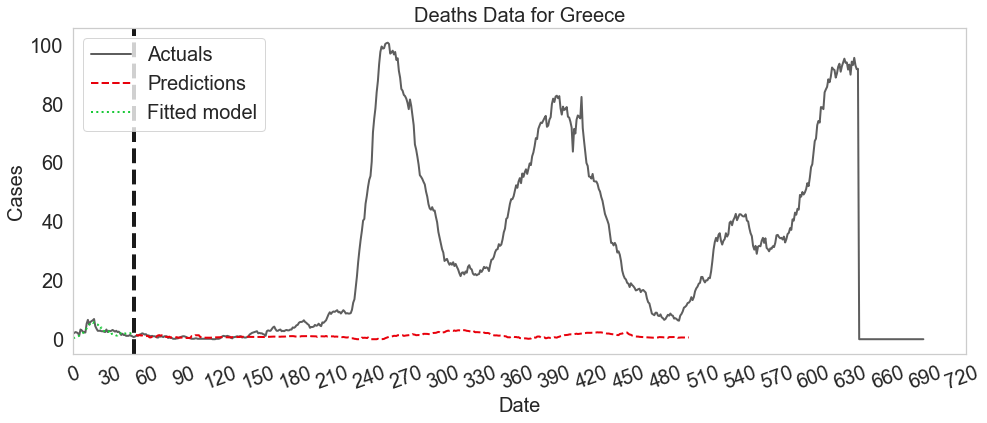

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


KeyboardInterrupt: 

In [58]:
# TODO: not good predictions for high "high_thresh", either change the intervention or use small "high_thresh"

df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
lambdas=[1,0.01]
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

#targets = [ 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#targets = newdf.columns
high_thresh = 500
low_thresh = 50
#targets = random.sample(list(deaths_intervention_adjusted_daily.columns),80)
targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index


donorpool = sizes[sizes>=high_thresh].index



singVals = 3
weight_features = []
move_intervention = 10
used_targets = []
for target in targets:
  
    try:
        newdata = synth_control_predictions([df, df1],high_thresh, low_thresh,
                                            "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, silent=True, showDonors=False, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=3000) # error_thresh=1
        if newdata:
            weight_features.append(newdata[0].model_weights())
            used_targets.append(target)
    except ValueError:
        print(target)
        continue
feature_list = pd.DataFrame((weight_features))
feature_list.index = used_targets
feature_list.fillna(0, inplace=True)
#feature_list = feature_list.apply(lambda x: x/x.max(), axis=1)
feature_columns = feature_list.columns
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(feature_list[feature_columns])
feature_list.insert((feature_list.shape[1]),'KMeans',y)
feature_list.groupby('KMeans').groups
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_method='leaf')
clustering_labels = clusterer.fit_predict(feature_list[feature_columns])
feature_list['DB'] = clustering_labels
feature_list.groupby('DB').groups


In [ ]:
# TODO: the below graph looks messy for second/third peak

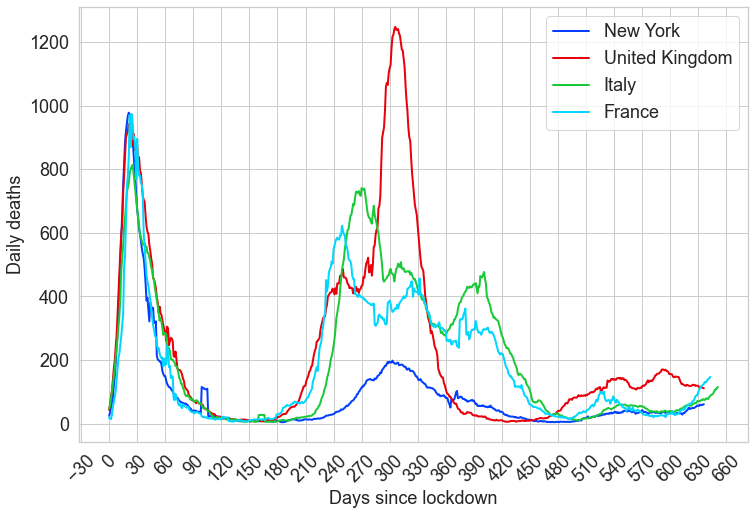

In [60]:
FONTSIZE = 18

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12, 8)


group = ['New York', 'United Kingdom', 'Italy', 'France']#list(feature_list.groupby('DB').groups[-1])
i = 0
ax = plt.subplot(1,1,1)
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

df[group].plot(ax = ax)#, xlim=[0,115]
plt.legend(fontsize=FONTSIZE, loc = 'upper right')
plt.xlabel('Days since lockdown',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Daily deaths',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE, rotation=45), plt.yticks(fontsize=FONTSIZE)
plt.savefig('../Figures/COVID/align.pdf', bbox_inches='tight')
    

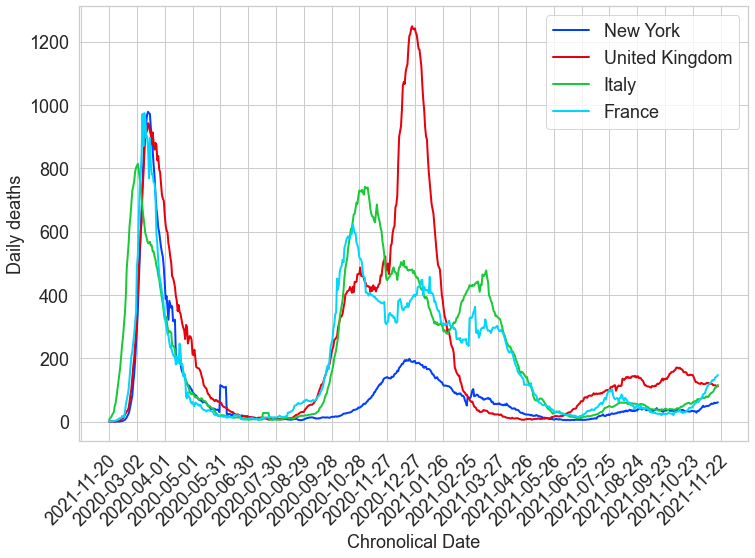

In [55]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (12, 8)
ax = plt.subplot(1,1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.xticks(rotation=45), plt.legend(fontsize=FONTSIZE)
plt.xlabel('Chronolical Date',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Daily deaths',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)
plt.savefig('../Figures/COVID/chron.pdf', bbox_inches='tight')



In [ ]:
# TODO: the below graph looks very different than the first 60 days in the paper

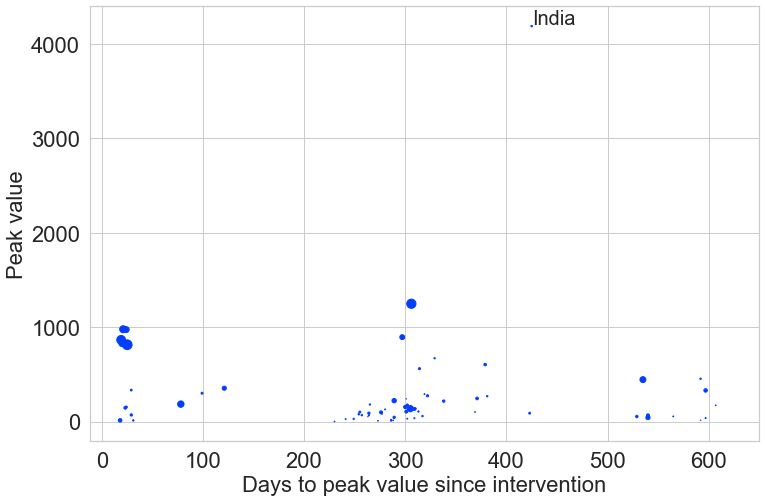

In [65]:
FONTSIZE = 22

df = create_peak_clusters(deaths_intervention_adjusted_daily,7)
plt.figure(figsize=(12,8))
#fig, ax = plt.subplots(1,1)
#FONTSIZE = 18

plt.rcParams.update({'font.size': 20})
tick_spacing = 30
# this is a bug in matplotlib
#plt.rcParams['figure.figsize'] = (24.0, 18.0)


# plt.xlim([0,60])
plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention',fontsize=FONTSIZE)#, plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : FONTSIZE}),
plt.ylabel('Peak value',fontsize=FONTSIZE)
plt.xticks(fontsize=FONTSIZE), plt.yticks(fontsize=FONTSIZE)


variablelabel = df.index

for i, txt in enumerate(variablelabel):
    if(df['peak value'][i]>3500):
        plt.annotate(txt, (df['days to peak'][i], df['peak value'][i]+20))

plt.savefig('../Figures/COVID/lockdown_impact.pdf', bbox_inches='tight')

FONTSIZE = 35


In [71]:
country_population = pd.read_excel("../data/mobility/country_pop_WDI.xlsx")
county_population = pd.read_excel("../data/mobility/co-est2019-annres.xlsx", header=[3])
new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)
county_population['state']=new[1].str.strip()
state_population = county_population.groupby('state').sum()
us_state_population = pd.DataFrame()
us_state_population['Country'] = state_population.index
us_state_population['Value'] = state_population[[2019]].values

all_population = pd.concat([country_population, us_state_population], axis=0, ignore_index=True)

<ipython-input-71-ff10fb7c6aaf>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)


In [17]:

df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()

df1 = cases_intervention_adjusted_daily[df.columns].copy()


In [18]:
FONTSIZE = 30
c = 3 #the cut off when generating new donor pool
p = 1.0
singVals = 1

otherStates = ['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland']

state = 'New York'


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:580: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


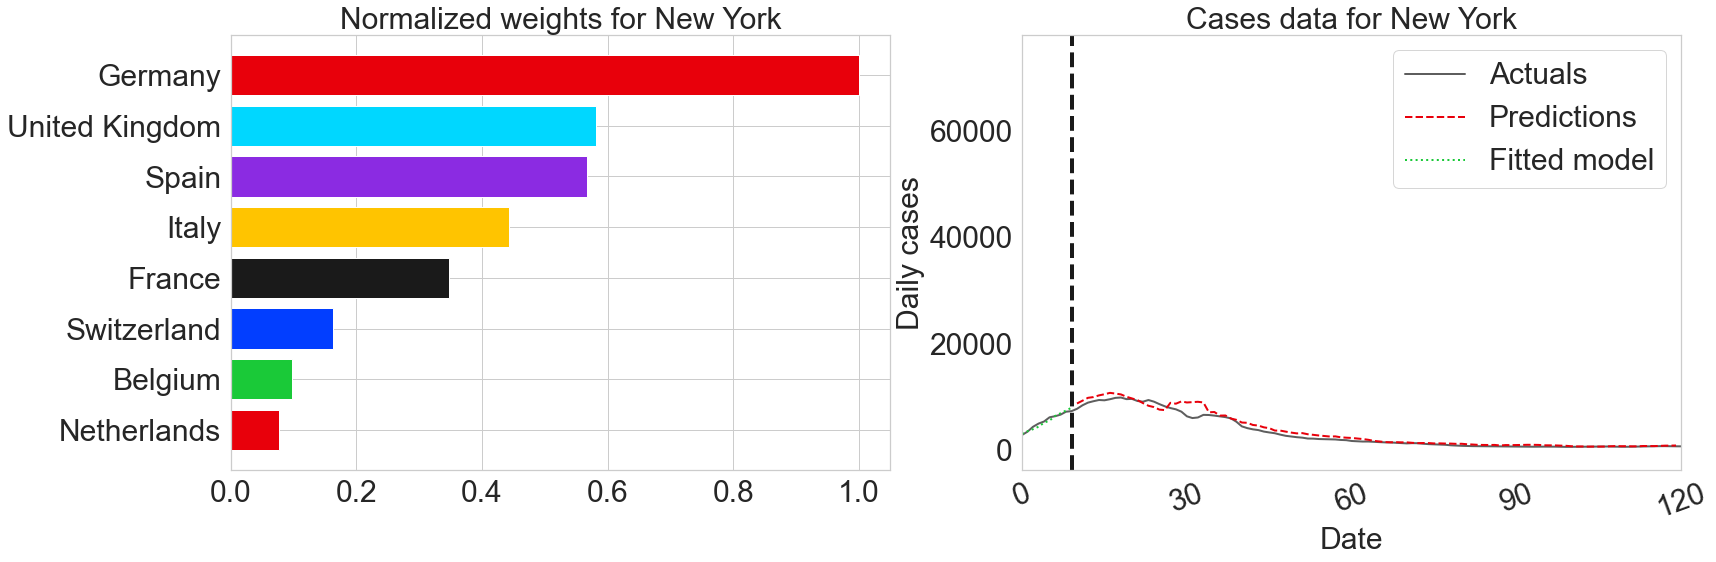

In [20]:
state = "New York"
projection_period=120
training_period=10
# NY deaths: c = 29, NY cases: c = 13
fig, axes = plt.subplots(1, 2, figsize=(26,8))
rscModel = syn_model(state, singVals, [df1, df], projection_period, training_period, otherStates=otherStates)
rscModel.fit_model()


rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[0,120], logy=False, show_donors=True, tick_spacing=30, yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)

plt.savefig('../Figures/COVID/cases_NY.pdf',bbox_inches='tight')    


{9.0: 3170461.515857969, 18.0: 7178327.9936274085, 34.0: 8309934.626725774, 38.0: 8516234.953214588, 42.0: 276148.9096568471, 45.0: 260075.4402609815, 205.0: 185146.42149887196, 861.0: 558810.4177369698} {9.0: 3.0156610525101475, 18.0: 7.731172701636543, 34.0: 9.893158873787748, 38.0: 10.095969989579238, 42.0: 1.8355411895397777, 45.0: 1.7148549627598695, 205.0: 1.266934821426403, 861.0: 3.622712035297548}


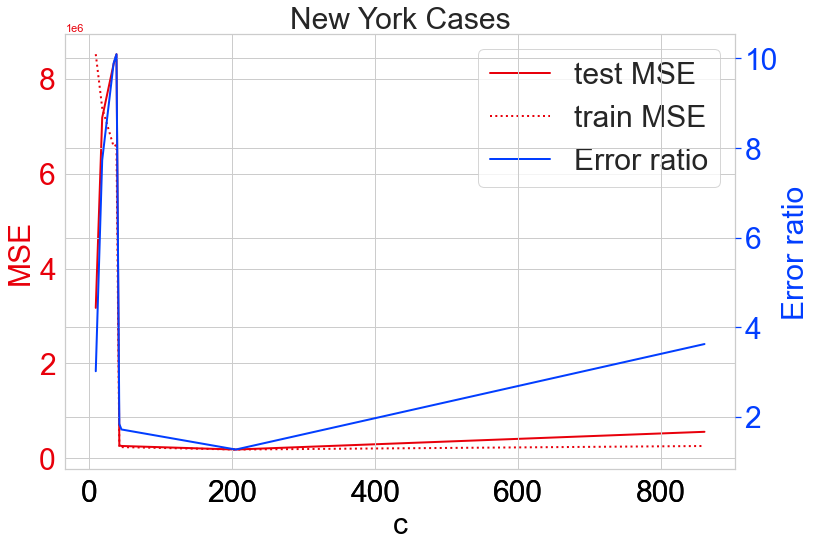

In [75]:
state = "New York"
projection_period=120
training_period=10
temp_df,_= filter_data_by_intervention(all_data_daily[['New York']], educational_distancing, 10)

rscModel = syn_model(state, singVals, [df1, df], projection_period, training_period, otherStates=otherStates)
rscModel.fit_model()

perm_dict = rscModel.permutation_distribution(show_graph = False)
perm_dict.pop(state) 
selected = np.array(list(perm_dict.values()))
selected2 = np.sort(np.ceil(selected))
MSE_dict = {}
err_ration_dict = {}
error_mean = {}
error_std = {}
train_MSE_dict = {}

for c in selected2:
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    new_model = syn_model(rscModel.state,  rscModel.kSingularValues, [df1, df], projection_period, training_period, otherStates=new_donor)
    new_model.fit_model()
    
    MSE_dict[c] = new_model.testing_error()
    train_MSE_dict[c] = new_model.training_error()
    err_ration_dict[c] = new_model.find_ri()

print(MSE_dict, err_ration_dict)


lines = [] 

fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111, label="1")
ax1=fig.add_subplot(111, label="1", frame_on=False)
ax2=fig.add_subplot(111, label="2", frame_on=False)


lines.append(ax.plot(*zip(*sorted(MSE_dict.items())), label = 'test MSE', color="r")[0])
ax.set_xlabel("c", color="black",fontsize = FONTSIZE)
ax.set_ylabel("MSE", color="r",fontsize = FONTSIZE)
ax.tick_params(axis='x', colors="black",labelsize = FONTSIZE)
ax.tick_params(axis='y', colors="r",labelsize = FONTSIZE)

lines.append(ax1.plot(*zip(*sorted(train_MSE_dict.items())), color="r", label = 'train MSE', linestyle = ":")[0])
ax1.set_xticks([])
ax1.set_yticks([])



lines.append(ax2.plot(*zip(*sorted(err_ration_dict.items())), label = '', color="b")[0])
#ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color="C1") 
ax2.set_ylabel('Error ratio', color="b",fontsize = FONTSIZE)       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="black",labelsize = FONTSIZE)
ax2.tick_params(axis='y', colors="b",labelsize = FONTSIZE)

ax.legend(lines, ['test MSE', 'train MSE','Error ratio'], fontsize = FONTSIZE)

plt.title(state +' Cases', fontsize = FONTSIZE)

'''

fig, axes = plt.subplots(1, 1, figsize=(12,8))

plt.plot(*zip(*sorted(MSE_dict.items())), label = 'test MSE')

ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.plot(*zip(*sorted(err_ration_dict.items())), label = 'Error ratio')
#plt.yscale('log')
plt.legend(fontsize = FONTSIZE)
axes.tick_params(axis='both', which='major', labelsize=FONTSIZE)
'''
plt.show()


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


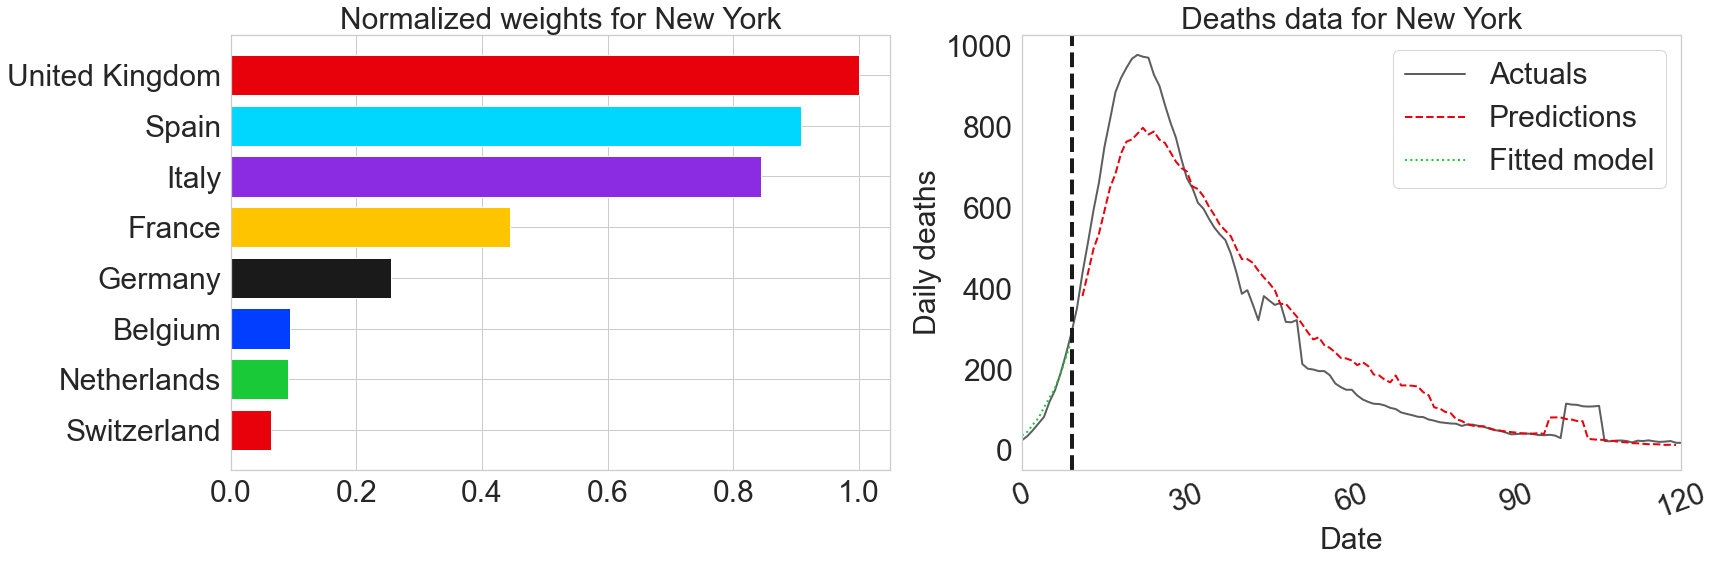

In [76]:
lambdas = [1, 0.02]
projection_period=120
training_period=10
c = 29
fig, axes = plt.subplots(1, 2, figsize=(26,8))
rscModel = syn_model(state, singVals, [df, df1], projection_period, training_period, otherStates=otherStates)
rscModel.fit_model()

rscModel.plot(figure=fig, axes=axes, title_text="Deaths data", ylimit=[], xlimit=[0,120], logy=False, show_donors=True, tick_spacing=30, yaxis="Daily deaths", intervention_date_x_ticks=None, fontsize = FONTSIZE)

plt.savefig("../Figures/COVID/deaths_NY.pdf",bbox_inches='tight')    


{12.0: 11392.634971299081, 25.0: 9643.199969953293, 72.0: 9620.35331029403, 81.0: 7791.427956434965, 194.0: 7806.16227376675, 305.0: 5833.444684796089, 449.0: 5814.639640078222, 1294.0: 5766.790580014639} {12.0: 19.590445205180114, 25.0: 26.516907381937756, 72.0: 26.42164134146465, 81.0: 36.7267665511522, 194.0: 37.32272054151668, 305.0: 33.645677134550326, 449.0: 33.73186408800238, 1294.0: 33.75317957993459}


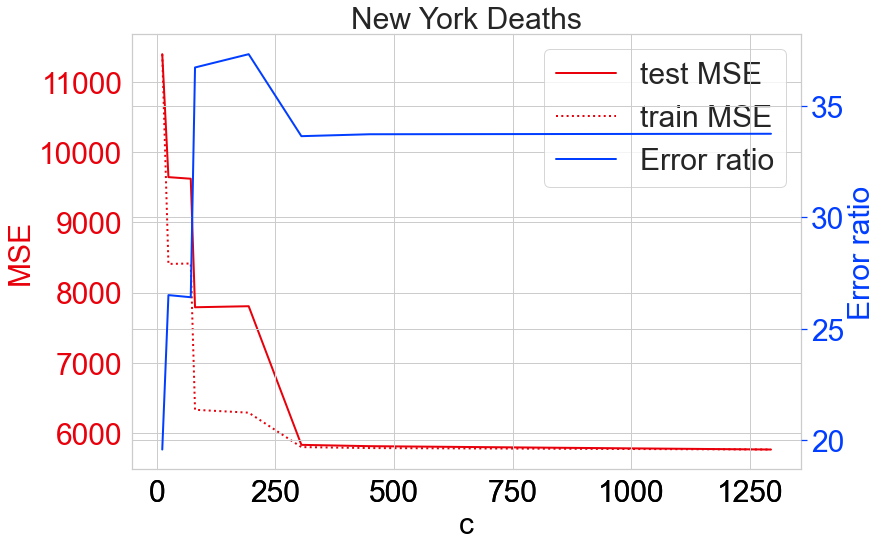

In [78]:
state = "New York"
lambdas = [1, 0.02]
projection_period=120
training_period=10

rscModel = syn_model(state, singVals, [df, df1], projection_period, training_period, otherStates=otherStates)
rscModel.fit_model()

perm_dict = rscModel.permutation_distribution(show_graph = False)
perm_dict.pop(state) 
selected = np.array(list(perm_dict.values()))
selected2 = np.sort(np.ceil(selected))
MSE_dict = {}
err_ration_dict = {}
error_mean = {}
error_std = {}
train_MSE_dict = {}

for c in selected2:
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    new_model = syn_model(rscModel.state,  rscModel.kSingularValues, [df, df1], projection_period, training_period, otherStates=new_donor)
    new_model.fit_model()
    
    MSE_dict[c] = new_model.testing_error()
    train_MSE_dict[c] = new_model.training_error()
    err_ration_dict[c] = new_model.find_ri()

print(MSE_dict, err_ration_dict)


lines = [] 

fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(111, label="1")
ax1=fig.add_subplot(111, label="1", frame_on=False)
ax2=fig.add_subplot(111, label="2", frame_on=False)


lines.append(ax.plot(*zip(*sorted(MSE_dict.items())), label = 'test MSE', color="r")[0])
ax.set_xlabel("c", color="black",fontsize = FONTSIZE)
ax.set_ylabel("MSE", color="r",fontsize = FONTSIZE)
ax.tick_params(axis='x', colors="black",labelsize = FONTSIZE)
ax.tick_params(axis='y', colors="r",labelsize = FONTSIZE)

lines.append(ax1.plot(*zip(*sorted(train_MSE_dict.items())), color="r", label = 'train MSE', linestyle = ":")[0])
ax1.set_xticks([])
ax1.set_yticks([])



lines.append(ax2.plot(*zip(*sorted(err_ration_dict.items())), label = '', color="b")[0])
#ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
#ax2.set_xlabel('x label 2', color="C1") 
ax2.set_ylabel('Error ratio', color="b",fontsize = FONTSIZE)       
#ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="black",labelsize = FONTSIZE)
ax2.tick_params(axis='y', colors="b",labelsize = FONTSIZE)
plt.title(state +' Deaths', fontsize = FONTSIZE)

ax.legend(lines, ['test MSE', 'train MSE','Error ratio'], fontsize = FONTSIZE)


'''

fig, axes = plt.subplots(1, 1, figsize=(12,8))

plt.plot(*zip(*sorted(MSE_dict.items())), label = 'test MSE')

ax2=fig.add_subplot(111, label="2", frame_on=False)
plt.plot(*zip(*sorted(err_ration_dict.items())), label = 'Error ratio')
#plt.yscale('log')
plt.legend(fontsize = FONTSIZE)
axes.tick_params(axis='both', which='major', labelsize=FONTSIZE)
'''
plt.show()


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:463: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45)


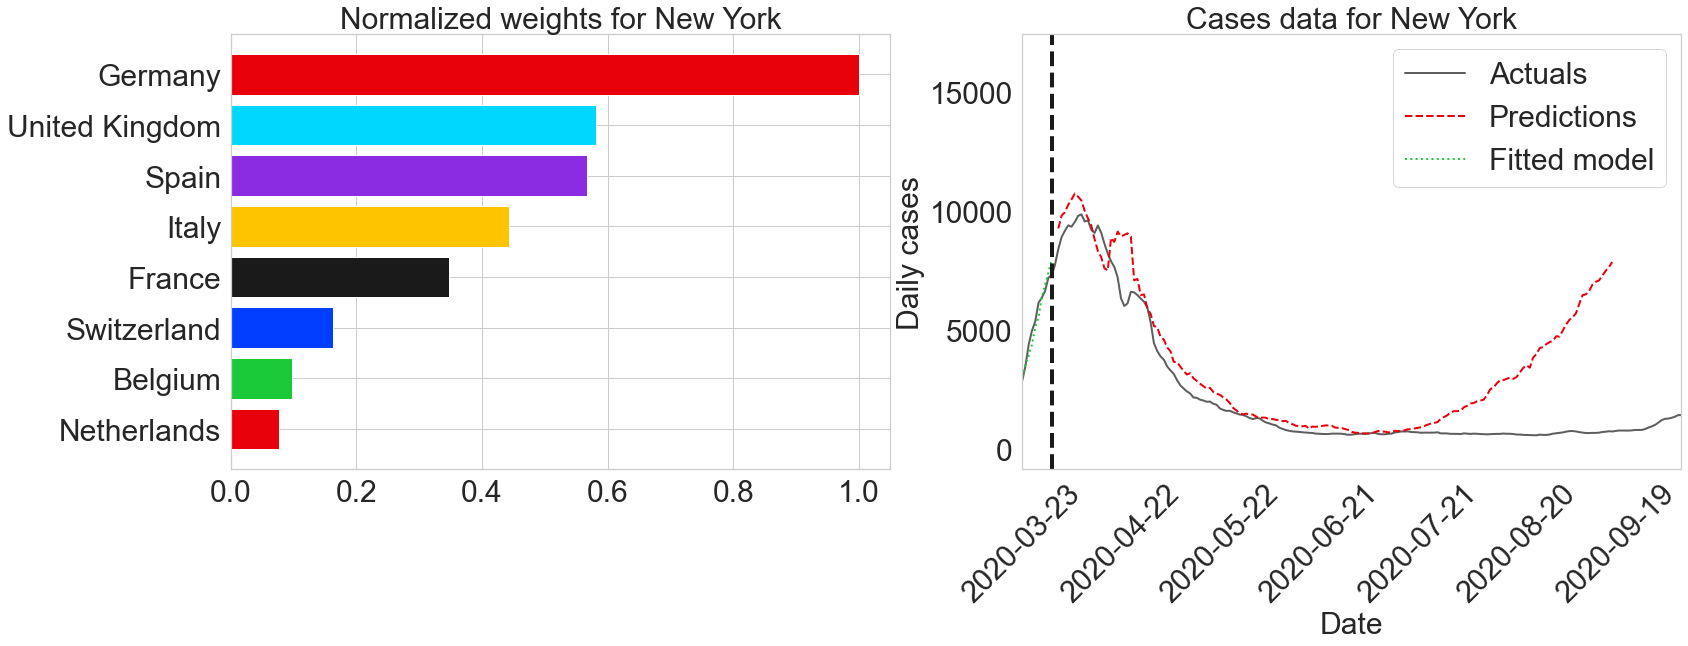

In [79]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)
#plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=180
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases data", 1, ylimit=[], xlimit=(1,200), savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = intervention_date_case)
#xlimit=[110,170]
#error_thresh=10



/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


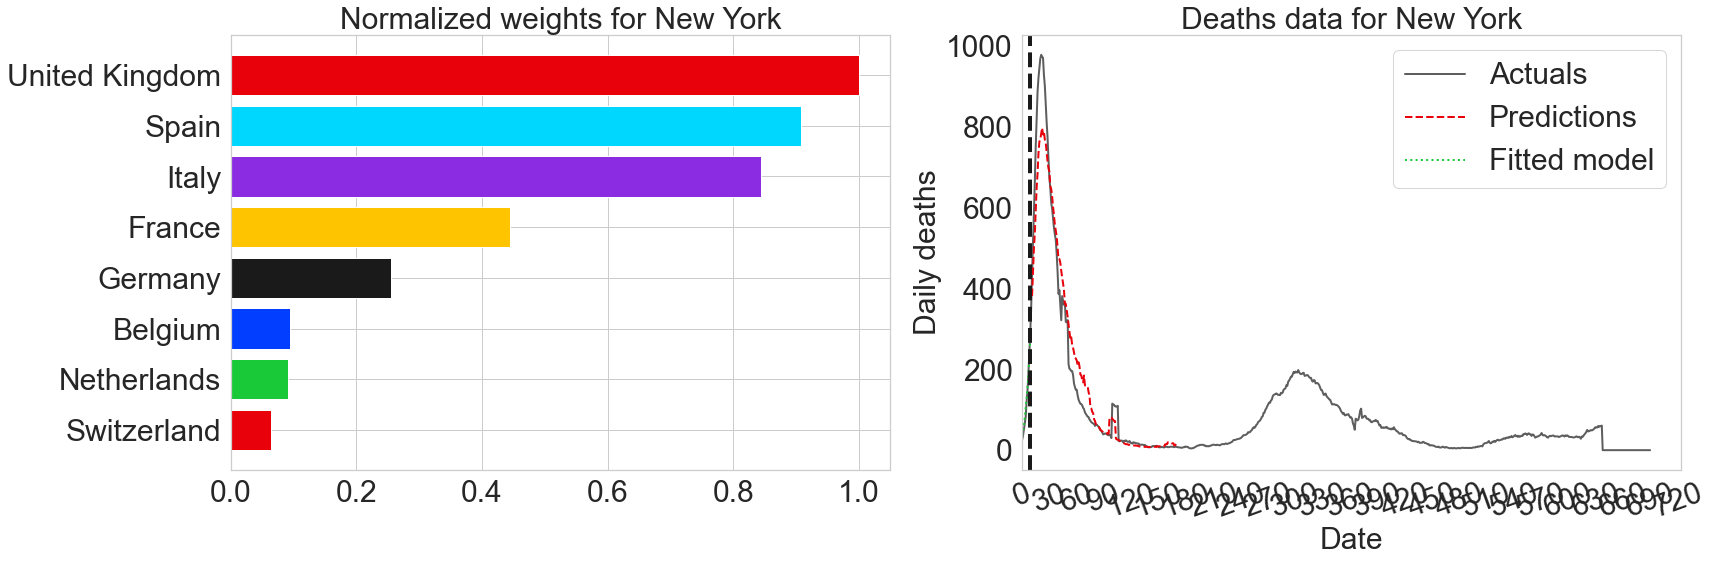

In [80]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)

lambdas = [1, 0.02]
projection_period=170
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([df, df1],projection_period, training_period, 
                                            "Deaths data", 1 , savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=4634, FONTSIZE=30, yaxis = 'Daily deaths')
#error_thresh=10
#intervention_date_x_ticks = intervention_date_death
#ylimit=[-5, 30],xlimit =[110,170]



/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


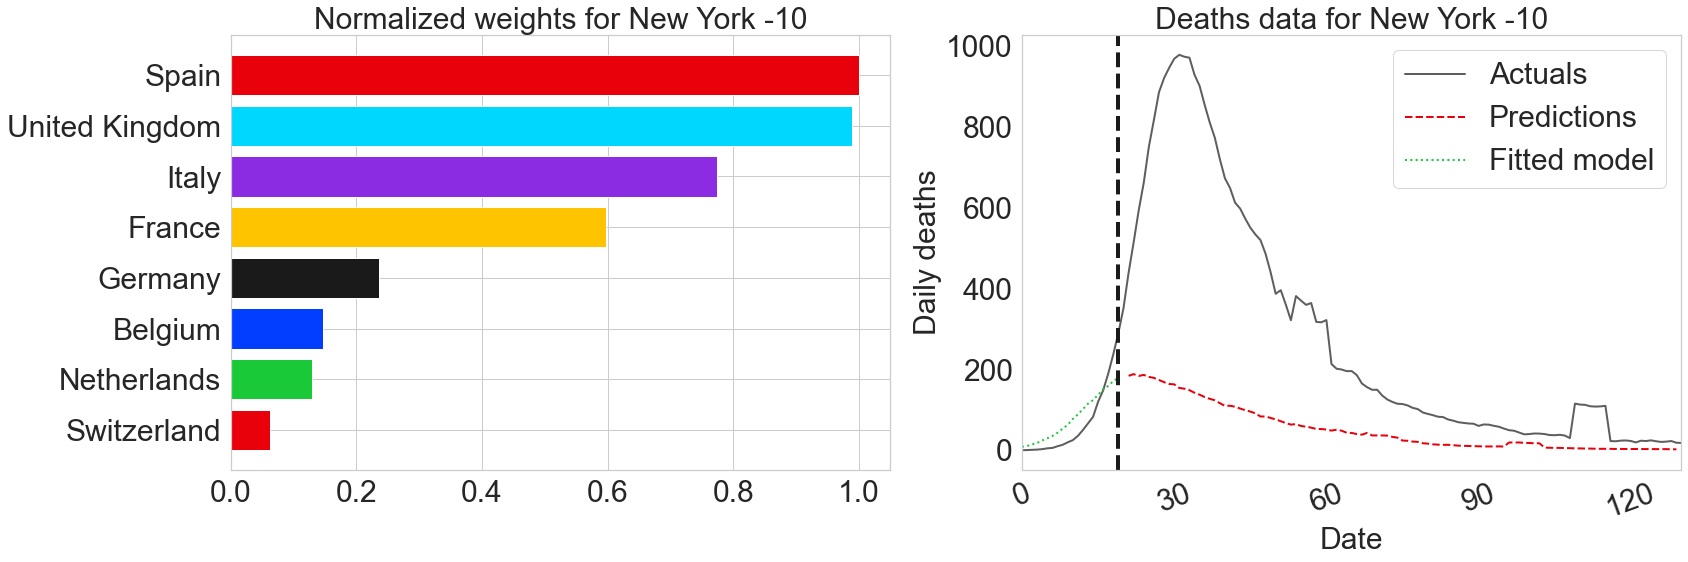

In [82]:
singVals = 1
projection_period=130
training_period=20
temp_df,_= filter_data_by_intervention(all_data_daily[['New York']], educational_distancing, 10)


fig, axes = plt.subplots(1, 2, figsize=(26,8))

# This has been made silent as to not flood the output
#[pd.concat([deaths_intervention_adjusted_daily,temp_df]
return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], projection_period, training_period, "Deaths data", singVals, ylimit=[], 
                           savePlots=True, do_only=["New York -10"],xlimit =[0,130], showstates=10,
                           exclude=['New York'], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                           svdSpectrum=False, silent=True, showDonors=True, showPlots=True,  mRSC=False, error_thresh = 1700, FONTSIZE=30, yaxis = 'Daily deaths')#lambdas=lambdas, random_distribution=dist



c: 29 
 Singvals: 1 
 permutation: [ 6.73911743  5.29425906  4.17803267 12.30432436  4.61297118  6.02221734
 36.00304588 31.55004131] 
 old donors: ['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'] 
 new donors: ['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands']


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:455: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=20)


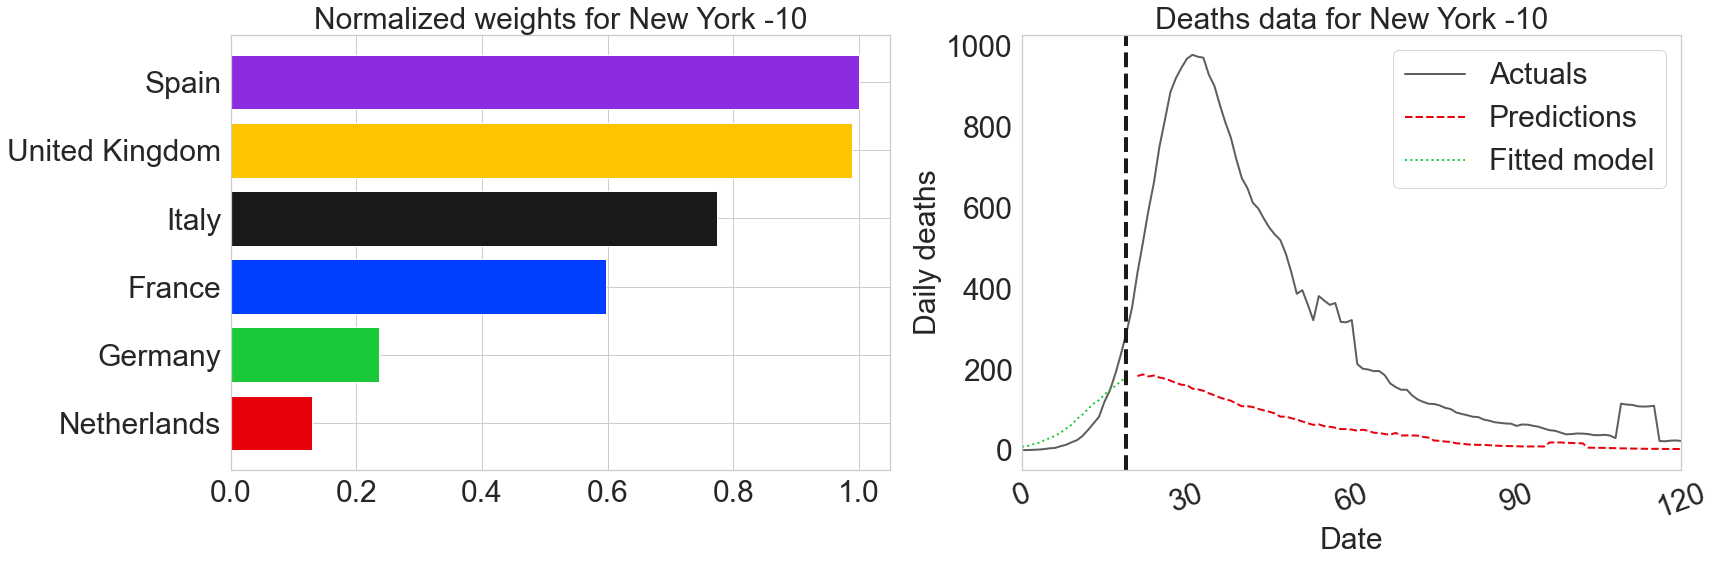

In [83]:
c = 29
state = "New York -10"
projection_period=130
training_period=20
fig, axes = plt.subplots(1, 2, figsize=(26,8))
temp_df,_= filter_data_by_intervention(all_data_daily[['New York']], educational_distancing, 10)

rscModel = syn_model(state, singVals, [pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], projection_period, training_period, otherStates=otherStates)
rscModel.fit_model()

perm_dict = rscModel.permutation_distribution(show_graph = False)
perm_dict.pop(state) 
selected = np.array(list(perm_dict.values()))
new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
print('c:',c,'\n Singvals:',rscModel.kSingularValues,'\n permutation:',selected,'\n old donors:', otherStates, '\n new donors:',new_donor)

new_model = syn_model(rscModel.state,  rscModel.kSingularValues, [pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], projection_period, training_period, otherStates=new_donor)
new_model.fit_model()
new_model.plot(figure=fig, axes=axes, title_text="Deaths data", ylimit=[], xlimit=(1,120), logy=False, show_donors=True, tick_spacing=30, yaxis="Daily deaths", intervention_date_x_ticks=None, fontsize = FONTSIZE)
plt.xlabel('Date')
positions = [30,60, 90, 120]
labels = []

#plt.xticks(positions, labels)

plt.savefig("../Figures/COVID/deaths_NY-10.pdf",bbox_inches='tight')    


# Mobility Analysis

In [84]:
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

CTP = load_clean('CTP states')
CTP_pop_adjusted = {name: create_population_adjusted_data(CTP[name], all_population) for name in CTP}

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)


In [85]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1)  
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1) 
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1)
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1)
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


In [86]:
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
mobility_data_google['county_state'] = mobility_data_google['sub_region_2'] + '-' + mobility_data_google['sub_region_1']
us_mobility_county = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='county_state')
us_mobility_state =  mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[column], columns='sub_region_1')

In [87]:
#df_sample = pd.read_csv('minoritymajority.csv') #use if the following line does not work
df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
fips = df_sample[['FIPS', 'STNAME', 'CTYNAME']]

fips.columns = ['fips', 'state', 'county']

In [88]:
us_mobility_state.index = pd.to_datetime(us_mobility_state.index)
state_adjusted = pd.DataFrame()
for state in us_mobility_state:
    #if state == 'New York' or state == 'New Jersey':
    #    continue
    if (sd_data['name'] == state).any():
        intervention_date = pd.to_datetime(sd_data[sd_data['name'] == state]['last date'].values[0])
        new_col = pd.Series(us_mobility_state[state]
                            [(us_mobility_state[state].index > intervention_date)].values, 
                             name = state)
        

        state_adjusted = pd.concat([state_adjusted, new_col], axis = 1 )

In [89]:
feature_dict, features = cluster_time_series(state_adjusted.iloc[:30], cluster_method = 'kmeans', n_clusters = 4)                         
colors = get_colors(len(feature_dict), picker = 2)


In [90]:
plt.rcParams.update({'font.size': 30})
cluster_df = features['cluster'].reset_index()
cluster_df.columns = ['state', 'cluster']

fips.columns = ['fips', 'state', 'county']
cluster_df = pd.merge(cluster_df, fips, how = 'inner', on = 'state')

group = cluster_df['fips']
values = cluster_df['cluster']
fig = ff.create_choropleth(fips=group, values=values, colorscale = colors)
fig.layout.template = None

fig.update_layout(
    font=dict(
        family="Arial",
        size=FONTSIZE
    )
)

fig.show()

ImportError: geopandas, pyshp and shapely must be installed for this figure factory.

Run the following commands to install the correct versions of the following modules:

```
$ pip install geopandas==0.3.0
$ pip install pyshp==1.2.10
$ pip install shapely==1.6.3
```
If you are using Windows, follow this post to properly install geopandas and dependencies:http://geoffboeing.com/2014/09/using-geopandas-windows/

If you are using Anaconda, do not use PIP to install the packages above. Instead use conda to install them:

```
$ conda install plotly
$ conda install geopandas
```

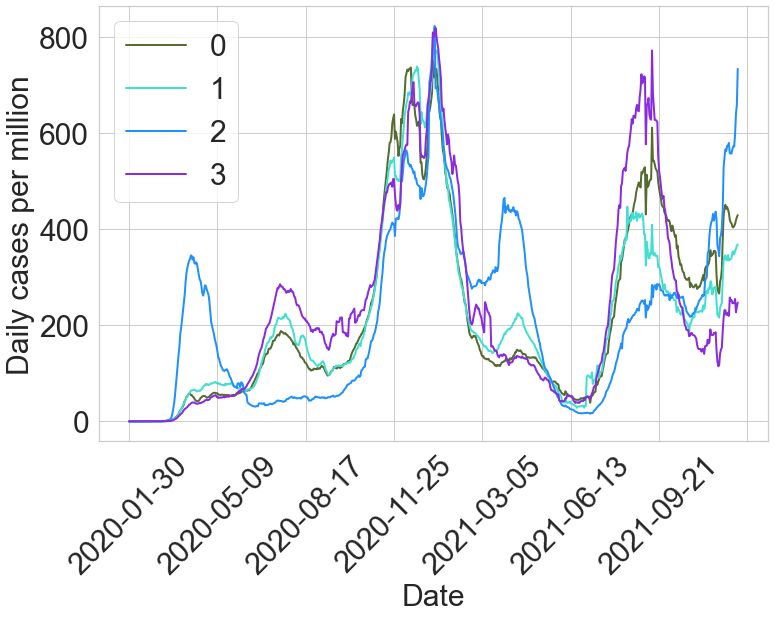

In [91]:
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for key in feature_dict:
    group = feature_dict[key]
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = key, c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE), plt.legend(fontsize = FONTSIZE)#plt.title('Cases'),
    plt.xlabel('Date', fontsize = FONTSIZE)
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    i=i+1
    
plt.savefig('../Figures/COVID/mobility_cases.pdf', bbox_inches='tight')

plt.show()


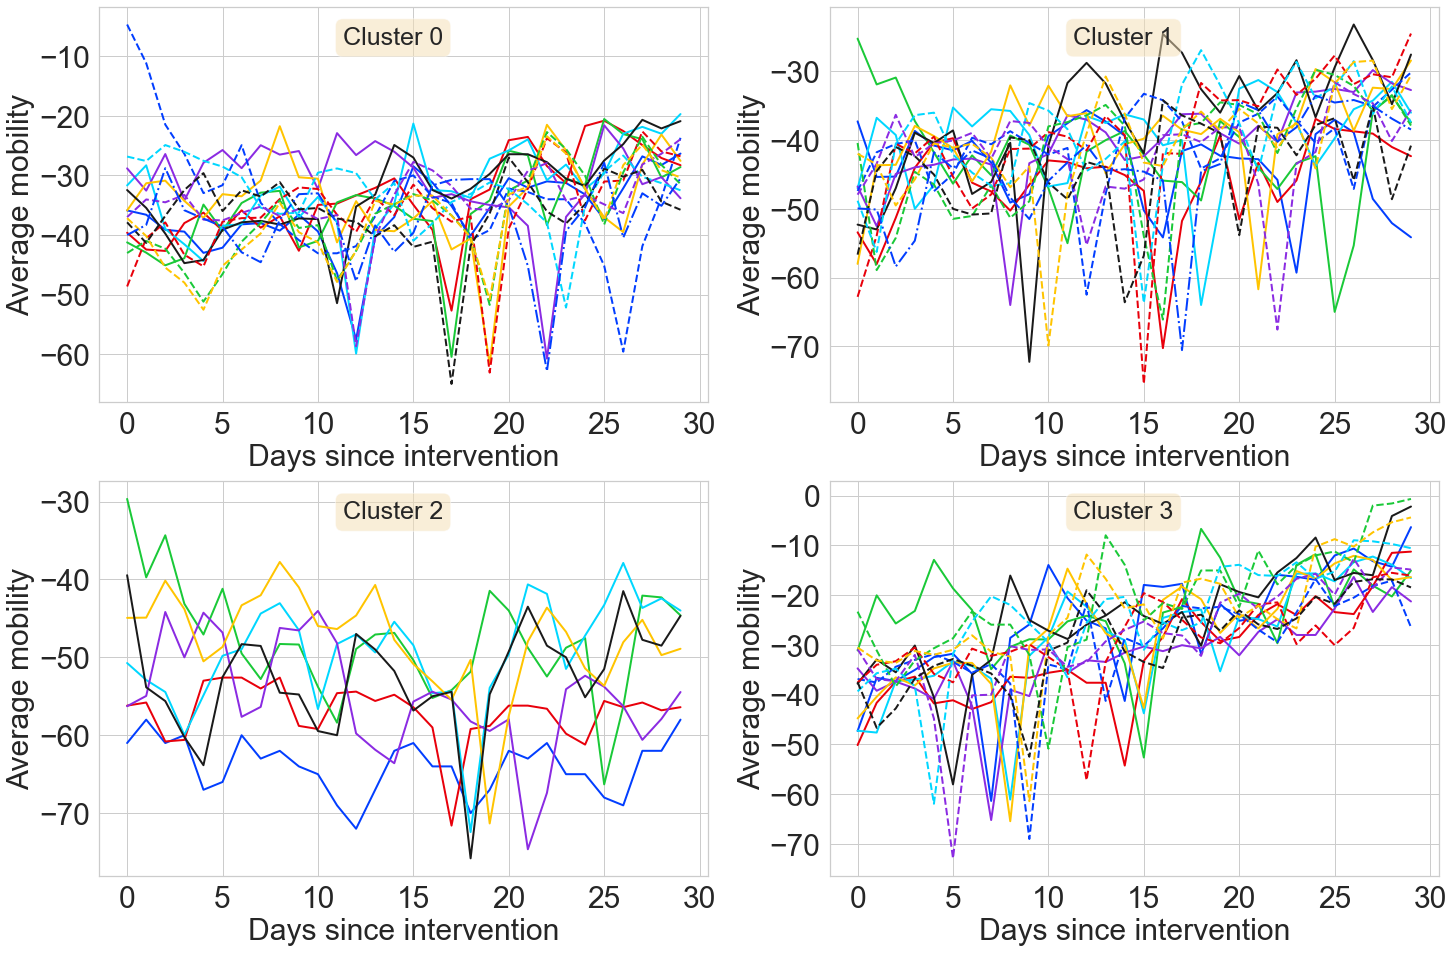

In [92]:
i = 221
for key in feature_dict:
    ax = plt.subplot(i)
    i += 1
    state_adjusted.iloc[:30][feature_dict[key]].plot(ax = ax, legend=False, figsize = (24, 16))
    #plt.title("Cluster %s" %(key),fontsize = FONTSIZE,position=(0.5, 0.9))

    plt.xticks(fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    plt.xlabel("Days since intervention",fontsize = FONTSIZE) 
    plt.ylabel("Average mobility",fontsize = FONTSIZE) 
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.95, "Cluster %s" %(key), transform=ax.transAxes, fontsize=FONTSIZE-5, verticalalignment='top', bbox=props)
    
    
    plt.savefig('../Figures/COVID/mobility_clusters.pdf', bbox_inches='tight')

In [93]:
#Some descriptive information
for key in feature_dict:
    print('In Group %s'%(key))
    last_day_case = uscases_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Last day population adjusted Cases: Mean %s STD %s"%(last_day_case.mean(), last_day_case.std()))
    
    last_day_death = usdeaths_pop_adjusted[feature_dict[key]].iloc[-1]
    print("Last day Population adjusted Death: Mean %s STD %s"%(last_day_death.mean(), last_day_death.std()))
    
    print("Average Mobility Change %s percent "%(np.mean(state_adjusted.iloc[:30][feature_dict[key]].mean())))
    
    print("\n")
    

In Group 0
Last day population adjusted Cases: Mean 161389.27264005292 STD 30818.323952196537
Last day Population adjusted Death: Mean 2347.051792237719 STD 671.1170360534886
Average Mobility Change -34.63724757129676 percent 


In Group 1
Last day population adjusted Cases: Mean 156527.24896730177 STD 34362.89755771177
Last day Population adjusted Death: Mean 2176.429199249249 STD 564.3422786918087
Average Mobility Change -41.284365853160125 percent 


In Group 2
Last day population adjusted Cases: Mean 124142.24863088845 STD 37683.04765674844
Last day Population adjusted Death: Mean 2151.2075871406178 STD 1077.263618194806
Average Mobility Change -53.375861958544654 percent 


In Group 3
Last day population adjusted Cases: Mean 174988.3764318395 STD 17061.810834881962
Last day Population adjusted Death: Mean 2560.616655038607 STD 637.3693710442237
Average Mobility Change -26.985676174245974 percent 




# Bars Impact

In [96]:
# TODO: Adjust this graph for the given interval where the intervention do not change 

In [97]:
ustates_list = list(uscases.columns)
bars_banned = ['Massachusetts', 'New Mexico', 'Kansas', 'District of Columbia', 'Rhode Island', 'North Carolina']
no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut']
indoor_bars = list(set(ustates_list) - set(bars_banned) - set(no_bar_no_dining))
groups = [bars_banned, indoor_bars, no_bar_no_dining]
group_labels = ['Indoor Dining Allowed', 'Indoor Dining and Bars Allowed', 'No dine in, no bars']

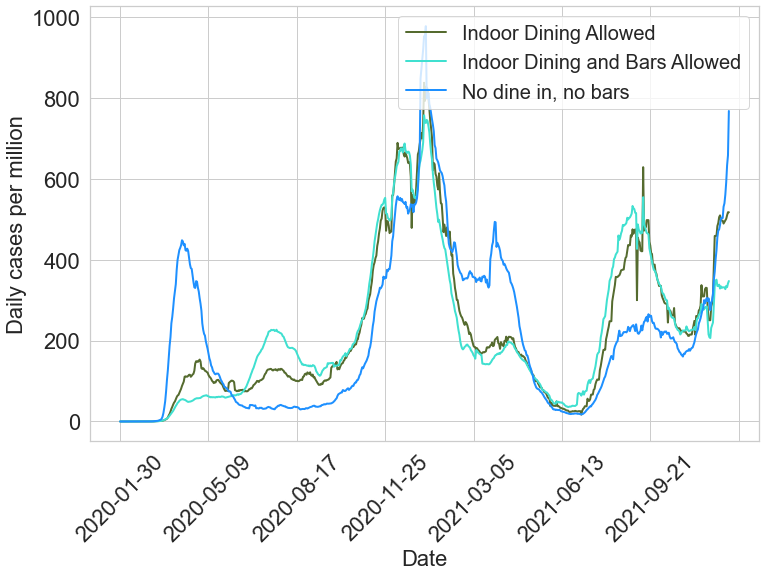

In [95]:
#FONTSIZE = 18
FONTSIZE = 22
plt.rcParams['figure.figsize'] = (12, 8)
dfplot=all_data_cases_daily
i=0
for j,group in enumerate(groups):
    temp = []
    for county in group:
        if county in dfplot.columns:
            temp.append(county)
    (1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label = group_labels[j], c = colors[i])
    #(1000000*dfplot[temp].sum(axis=1)/(all_population[all_population.index.isin(temp)].value.sum())).plot(label=group_labels[i])
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE), plt.legend(fontsize = 20)#plt.title('Cases'),
    plt.xlabel('Date', fontsize = FONTSIZE)
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    i=i+1
    
plt.savefig('../Figures/COVID/dinein-bars.pdf', bbox_inches='tight')

plt.show()

FONTSIZE = 35


# Prop 99

In [50]:
directory = os.path.dirname(testdata.__file__)

filename = directory + '/prop99.csv'


df = pd.read_csv(filename)
df = df[df['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
pivot = df.pivot_table(values='Data_Value', index='LocationDesc', columns=['Year'])
dfProp99 = pd.DataFrame(pivot.to_records())

allColumns = dfProp99.columns.values

states = list(np.unique(dfProp99['LocationDesc']))
years = np.delete(allColumns, [0])
caStateKey = 'California'
states.remove(caStateKey)
otherStates = states

yearStart = 1970
yearTrainEnd = 1989
yearTestEnd = 2015

p = 1.0

trainingYears = []
for i in range(yearStart, yearTrainEnd, 1):
    trainingYears.append(str(i))

testYears = []
for i in range(yearTrainEnd, yearTestEnd, 1):
    testYears.append(str(i))

trainDataMasterDict = {}
trainDataDict = {}
testDataDict = {}
for key in otherStates:
    series = dfProp99.loc[dfProp99['LocationDesc'] == key]

    trainDataMasterDict.update({key: series[trainingYears].values[0]})

    # randomly hide training data
    (trainData, pObservation) = tsUtils.randomlyHideValues(copy.deepcopy(trainDataMasterDict[key]), p)
    trainDataDict.update({key: trainData})
    testDataDict.update({key: series[testYears].values[0]})
series = dfProp99[dfProp99['LocationDesc'] == caStateKey]
trainDataMasterDict.update({caStateKey: series[trainingYears].values[0]})
trainDataDict.update({caStateKey: series[trainingYears].values[0]})
testDataDict.update({caStateKey: series[testYears].values[0]})

trainMasterDF = pd.DataFrame(data=trainDataMasterDict)
trainDF = pd.DataFrame(data=trainDataDict)
testDF = pd.DataFrame(data=testDataDict)

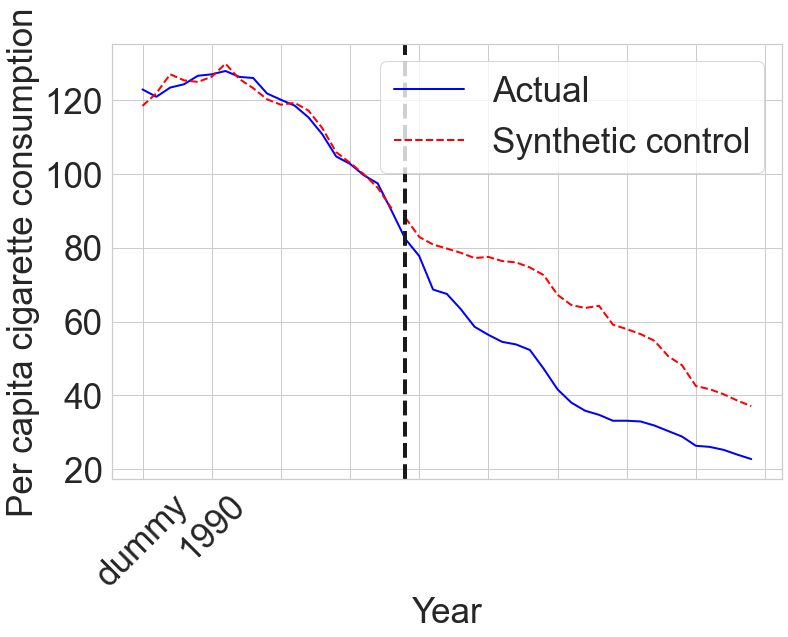

In [51]:

singvals = 4
rscModel = RobustSyntheticControl(caStateKey, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
rscModel.fit(trainDF)
denoisedDF = rscModel.model.denoisedDF()
predictions = []
predictions = np.dot(testDF[otherStates], rscModel.model.weights)
predictions_noisy = np.dot(testDF[otherStates], rscModel.model.weights)
actual = dfProp99.loc[dfProp99['LocationDesc'] == caStateKey]
actual = actual.drop('LocationDesc', axis=1)
actual = actual.iloc[0]
model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)

fig, ax = plt.subplots(1,1)
tick_spacing = 5
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.rcParams['figure.figsize'] = (12, 8.0)
plt.grid()
plt.plot(years, actual ,label='Actual',color = 'blue')
plt.xlabel('Year', fontsize = FONTSIZE)
plt.ylabel('Per capita cigarette consumption', fontsize = FONTSIZE)
plt.plot(trainingYears, model_fit, linestyle='--', color = 'red') #label='fitted'
plt.plot(testYears, predictions, linestyle='--',color = 'red', label='Synthetic control')
#plt.plot(testYears, predictions_noisy, label='counterfactual noisy')
#plt.title(caStateKey+', Singular Values used: '+str(singvals))
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')

plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
plt.grid()
plt.savefig('../Figures/COVID/prop99_SC.pdf', bbox_inches='tight')




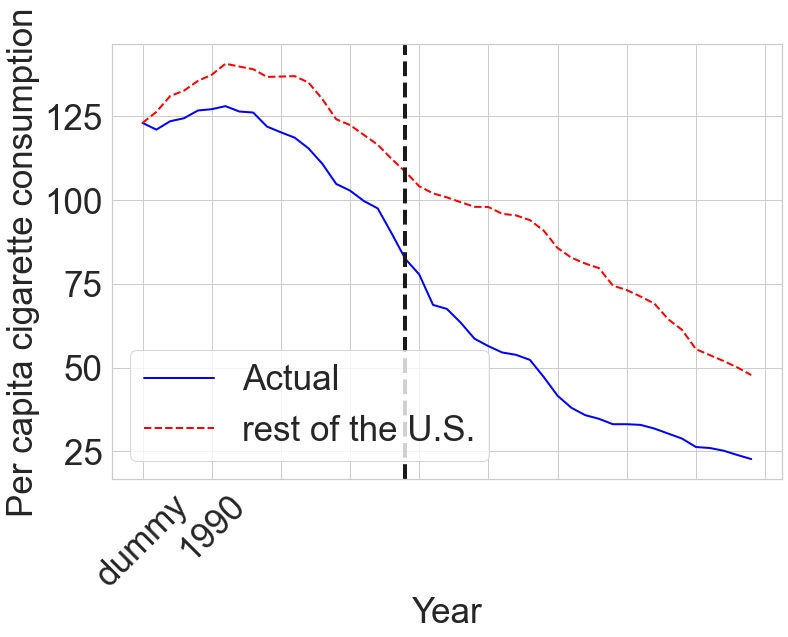

In [52]:


AB_df = dfProp99.copy()
AB_df = AB_df.drop([4], axis=0)
AB_series = AB_df.mean()
AB_series = AB_series * actual[0]/ AB_series[0]
#print(AB_series[0])
#print(actual[0])



#lt.plot(years,AB_series)


fig, ax = plt.subplots(1,1)
tick_spacing = 5
# this is a bug in matplotlib
label_markings = np.insert(years[::tick_spacing], 0, 'dummy')

ax.set_xticks(np.arange(len(label_markings)))
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.rcParams['figure.figsize'] = (12, 8.0)
plt.grid()


plt.plot(years, actual ,label='Actual',color = 'blue')
plt.xlabel('Year', fontsize = FONTSIZE)
plt.ylabel('Per capita cigarette consumption', fontsize = FONTSIZE)
plt.plot(years, AB_series, linestyle='--', color = 'red',label='rest of the U.S.') #label='fitted'
#plt.plot(testYears, predictions_noisy, label='counterfactual noisy')
#plt.title(caStateKey+', Singular Values used: '+str(singvals))
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)

xposition = pd.to_datetime(yearTrainEnd,  errors='coerce')

plt.axvline(x=str(yearTrainEnd), color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
plt.grid()
plt.savefig('../Figures/COVID/prop99_AB.pdf', bbox_inches='tight')




# Herd Immunity Analysis

## Filter out counties with high RI from donor pool
 

In [10]:
#collect donors pool which consist the counties in cluster_2_state with long spreading time 
#cluster_2_states = no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii

cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

In [11]:
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
tick_spacing=50
FONTSIZE = 28
plt.rcParams['figure.figsize'] = (26, 8.0)


df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

targets = ['Los Angeles-California', 'Broward-Florida','DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']
cluster_2_counties =  []

models = []

for singVals in range(4,5):

    target_model = [] 
    cluster_2_model = []

    #print("Intervention date: ", testDF.index[0])
    for state in targets:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        if state in otherStates:
            otherStates.remove(state)


        rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel.fit_model()
        target_model.append(rscModel)

        predictions = rscModel.predictions
        model_fit = rscModel.model_fit
   
        
        new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
        cluster_2_counties.append(new_state)
        
        if new_state in otherStates:
            otherStates.remove(new_state)

        rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel2.fit_model()
        cluster_2_model.append(rscModel2)

        predictions2 = rscModel2.predictions
        model_fit2 = rscModel2.model_fit

    
    models.append((target_model, cluster_2_model)) #Storing both the model for noreasther state and our target state


In [12]:
print(df.index[low_thresh])

2020-05-24


Analysis for state Los Angeles-California
theory singular value in range 27.4 to 39.2
Analysis for state Niagara-New York
theory singular value in range 31.4 to 44.8


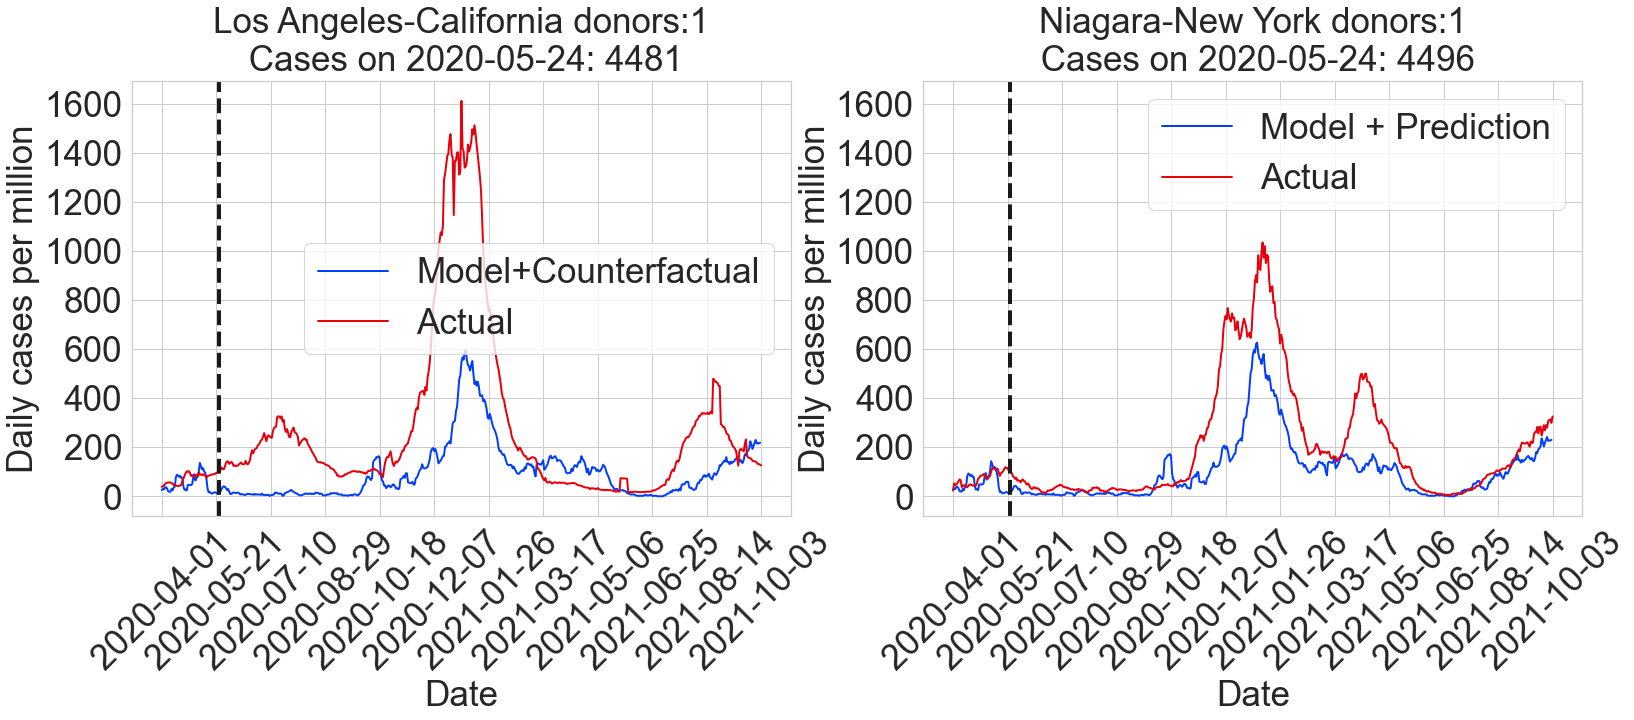

Analysis for state Broward-Florida
theory singular value in range 29.0 to 41.4
Analysis for state Cumberland-Maine
theory singular value in range 30.8 to 44.0


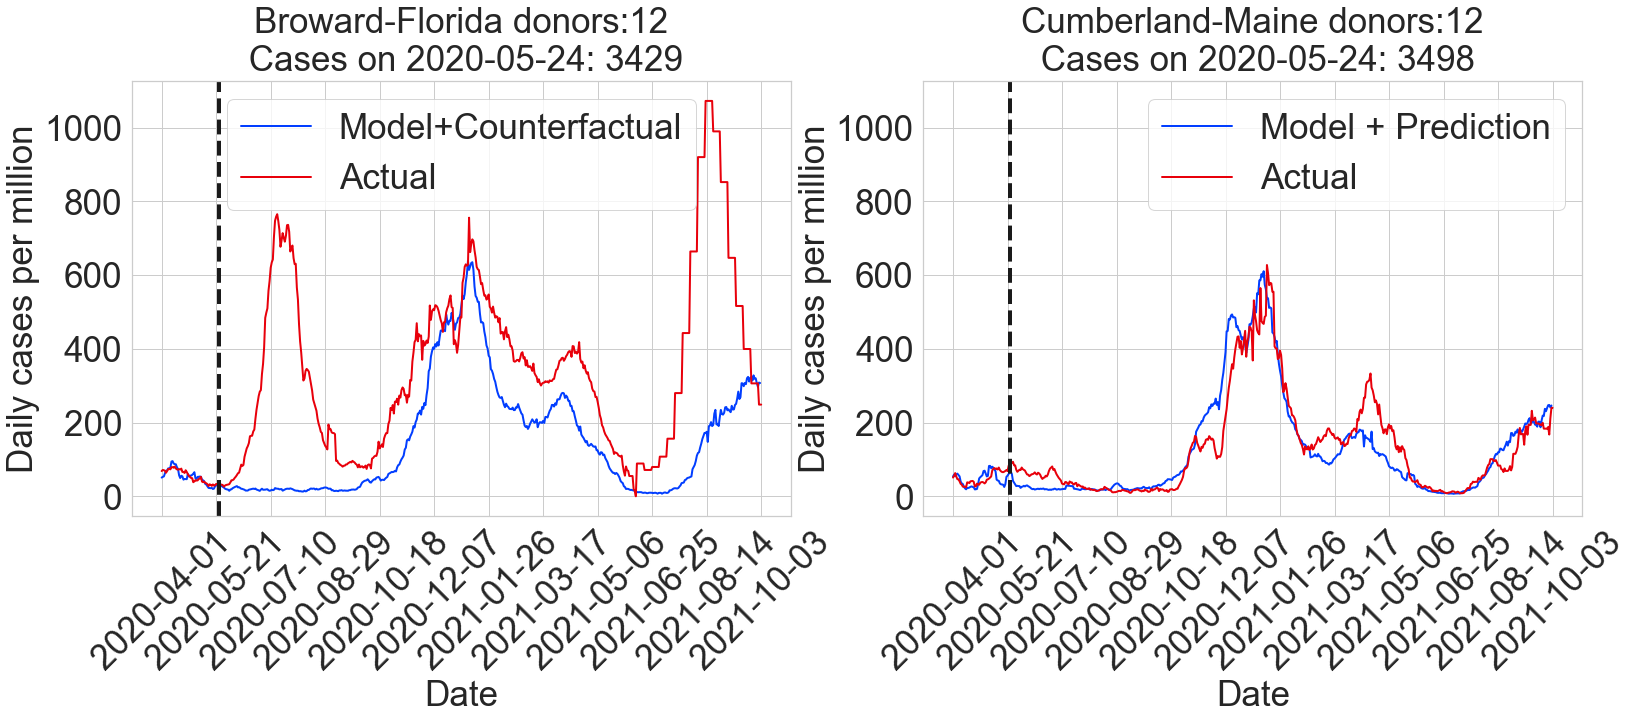

Analysis for state DeKalb-Georgia
theory singular value in range 22.3 to 31.9


/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Analysis for state Madison-New York
theory singular value in range 26.1 to 37.3


/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


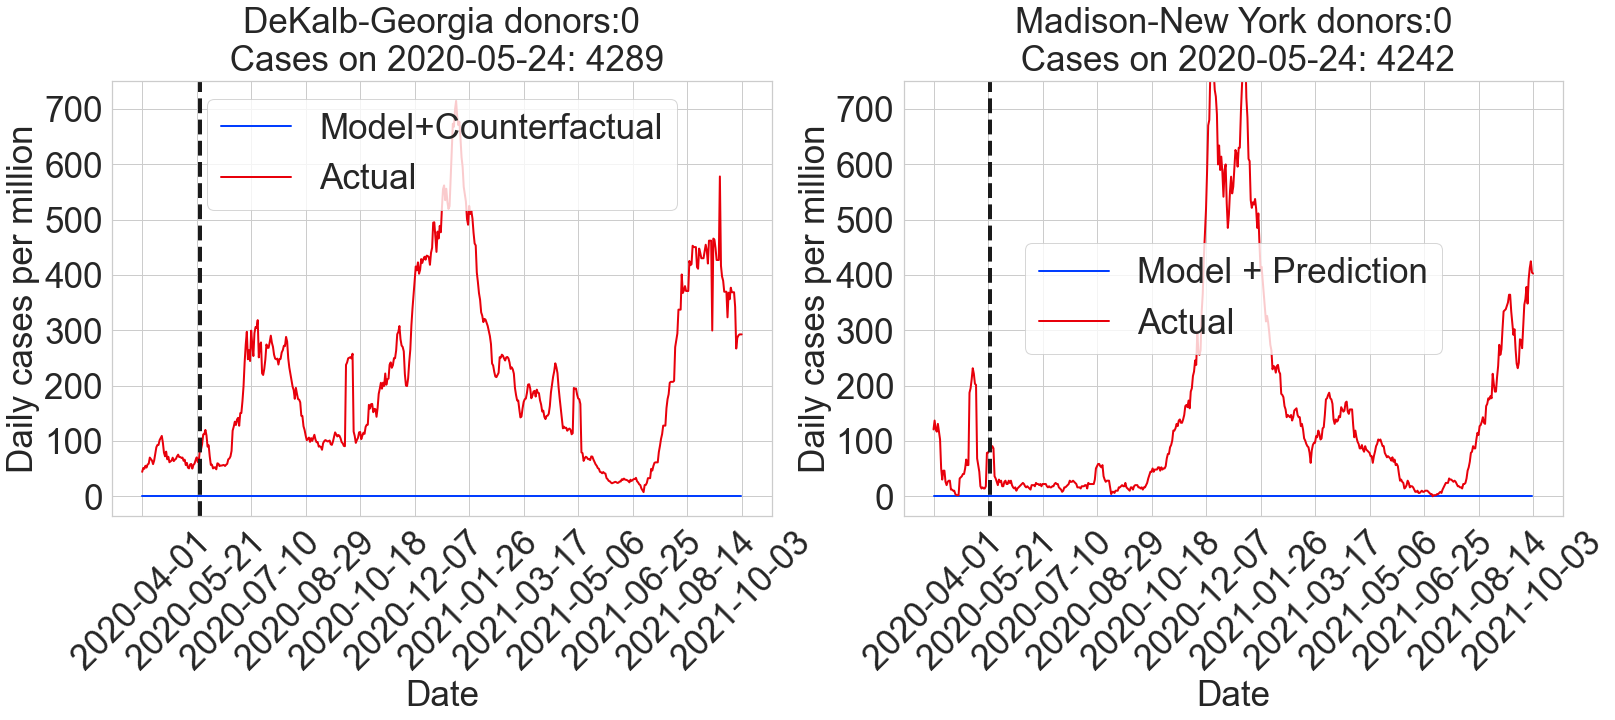

Analysis for state Bartholomew-Indiana
theory singular value in range 25.9 to 37.0


/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Analysis for state Albany-New York
theory singular value in range 22.7 to 32.5


/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


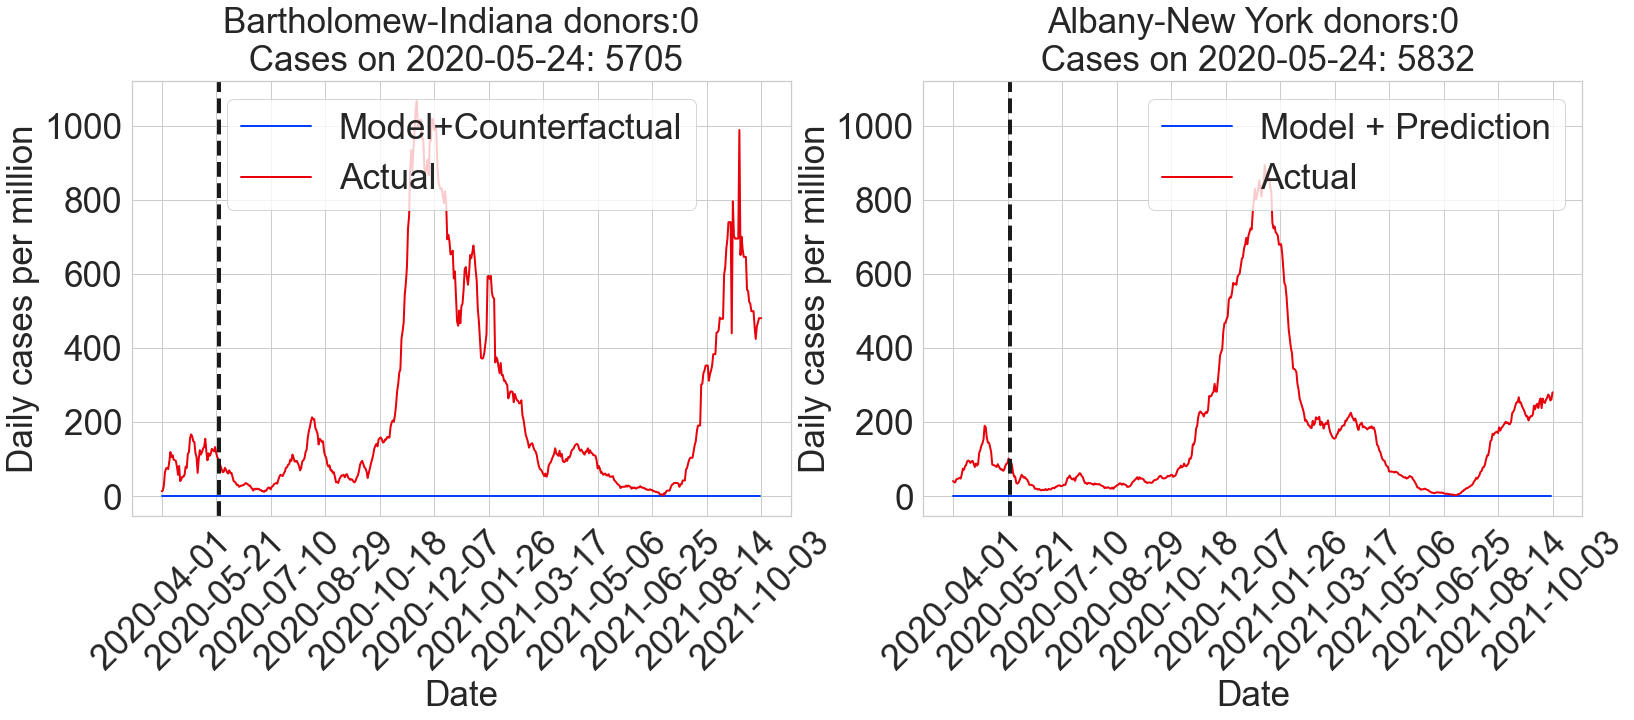

Analysis for state Jefferson-Louisiana
theory singular value in range 30.3 to 43.3
Analysis for state Providence-Rhode Island
theory singular value in range 29.0 to 41.4


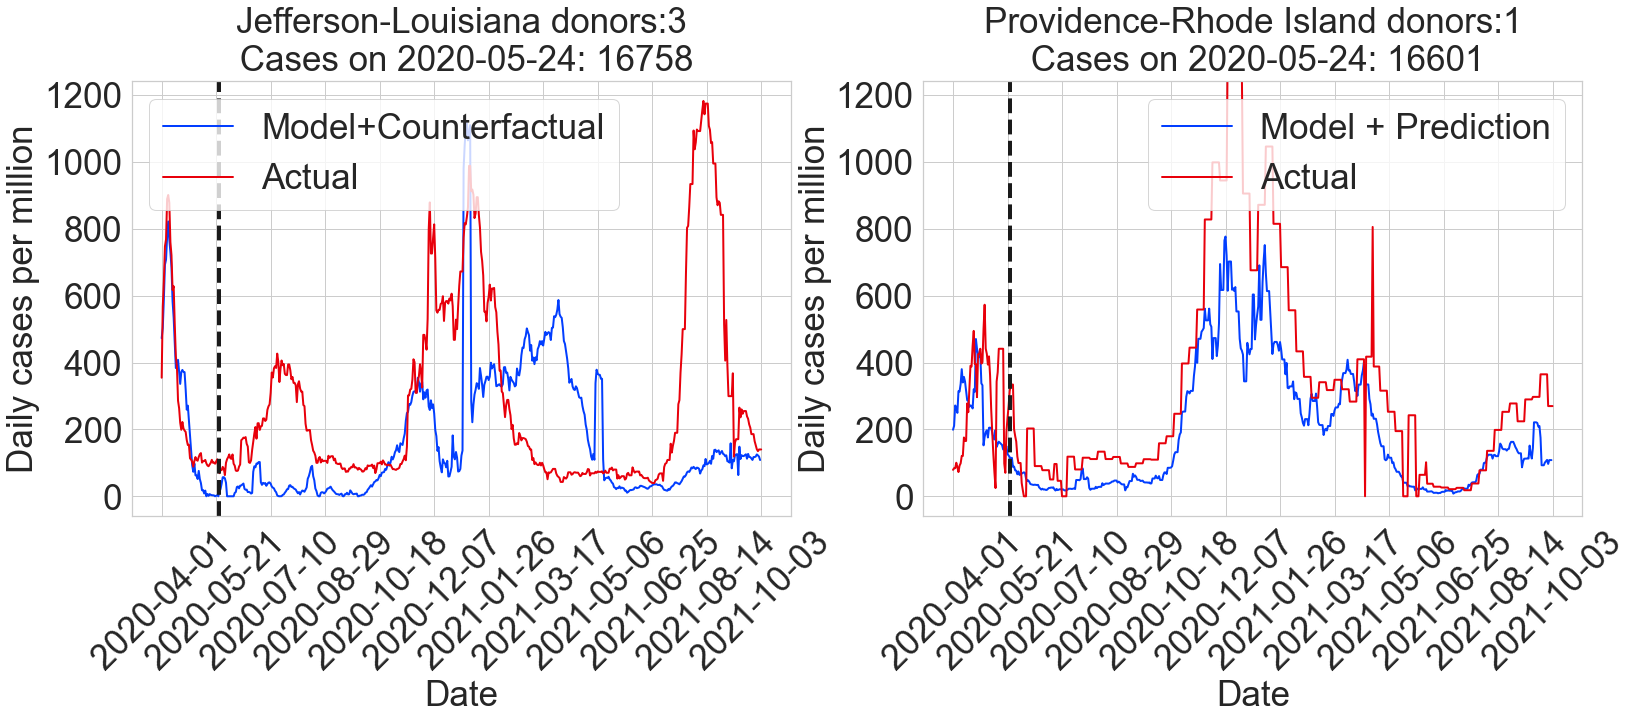

In [13]:
FONTSIZE = 35
#fig, axes2 = plt.subplots(len(models)+1, 2, figsize = (15, 6*(len(models))+1))
c = 3 #the cut off when generating new donor pool
p = 1.0

old = np.empty((len(models), 2))
new = np.empty((len(models), 2))

Cs = [5, 34,3,2, 3]

new_model_dict = []

i = 0# https://www.jmlr.org/papers/volume19/17-777/17-777.pdf
new_model_dict.append({})
for stat_index in range(len(models[i][0])):
    c = Cs[stat_index]
    print("Analysis for state %s"%(models[i][0][stat_index].state))

    X = models[i][0][stat_index].denoisedDF[models[i][0][stat_index].state]
    b = max(X)
    a = min(X)
    X = (X - (a + b)/2)/((b-a)/2)
    variance = np.var(X, ddof = 1)
    l = (2.1)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    h = (3)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 


    '''
    axes2[i][0].hist(selected, bins = 15)
    axes2[i][0].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(selected), np.std(selected), models[i][0][stat_index].find_ri()))
    '''

    (target_model, cluster_2_model) = (models[i][0][stat_index],  models[i][1][stat_index])

    #######################
    ########## target_model
    #######################
    state = targets[stat_index]

    predictions = target_model.predictions
    model_fit = target_model.model_fit

    perm_dict = models[i][0][stat_index].permutation_distribution(show_graph = False)
    perm_dict.pop(state) 

    #old[i][1] = perm_dict.pop(models[i][0][stat_index].state)
    selected = np.array(list(perm_dict.values()))
    #old[i][0] = np.mean(selected)

    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    selected = selected[selected < c]

    new_model = syn_model(models[i][0][stat_index].state,  models[i][0][stat_index].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_perm_dict = new_model.permutation_distribution(show_graph = False)
    new[i][1] = new_perm_dict.pop(new_model.state)
    values = list(new_perm_dict.values())

    new[i][0] = np.mean(values)

    new_predictions = new_model.predictions
    new_model_fit = new_model.model_fit
    '''
    axes2[i][1].hist(values, bins = 8)
    axes2[i][1].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(values), np.std(values), new_model.find_ri()))
    '''

    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)

    otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                              df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                 > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    if state in otherStates:
            otherStates.remove(state)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+' donors:'+str(len(new_donor)) + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    #plt.plot(np.concatenate((model_fit, predictions)), label='Model'+" donors: "+str(len(otherStates))), 
    plt.plot(np.concatenate((new_model_fit, new_predictions)), label='Model+Counterfactual'), 
    plt.plot(df[state], label='Actual'), 
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    y_min, y_max = ax.get_ylim()


    #######################
    ########## cluster_2_model
    #######################
    print("Analysis for state %s"%(models[i][1][stat_index].state))

    X = models[i][1][stat_index].denoisedDF[models[i][1][stat_index].state]
    b = max(X)
    a = min(X)
    X = (X - (a + b)/2)/((b-a)/2)
    variance = np.var(X, ddof = 1)
    l = (2.1)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    h = (3)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 



    new_state =  cluster_2_counties[stat_index]

    predictions = cluster_2_model.predictions
    model_fit = cluster_2_model.model_fit

    #Select new donors
    perm_dict = models[i][1][stat_index].permutation_distribution(show_graph = False)
    perm_dict.pop(new_state) 

    #old[i][1] = perm_dict.pop(models[i][1][stat_index].state)
    selected = np.array(list(perm_dict.values()))
    #old[i][1] = np.mean(selected)

    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    selected = selected[selected < c]

    new_model = syn_model(models[i][1][stat_index].state, models[i][1][stat_index].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_perm_dict = new_model.permutation_distribution(show_graph = False)
    new[i][1] = new_perm_dict.pop(new_model.state)
    values = list(new_perm_dict.values())

    new[i][1] = np.mean(values)

    new_predictions = new_model.predictions
    new_model_fit = new_model.model_fit


    if new_state in otherStates:
        otherStates.remove(new_state)

    ax = plt.subplot(1,2,2)
    #fig, ax = plt.subplots(1,1)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+' donors:'+str(len(new_donor))+ "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    #plt.plot(np.concatenate((model_fit, predictions)), label='Model'+" donors: "+str(len(otherStates))), 
    plt.plot(np.concatenate((new_model_fit, new_predictions)), label='Model + Prediction'), 
    plt.plot(df[new_state], label='Actual'),
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh-1], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 
    plt.ylim([y_min, y_max])

    plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()
    ##################  





{3.0: 30960.77047245438, 9.0: 12040.507243644519, 11.0: 14908.336165210718, 13.0: 14906.234074918028, 17.0: 12146.576096489245, 20.0: 14433.06178612876, 25.0: 14280.09332655794, 27.0: 11938.599764955901, 30.0: 11601.565667179008, 35.0: 10393.747764977426, 39.0: 10238.063367240464, 41.0: 9713.317452255502, 43.0: 10044.034294934427, 45.0: 10717.244312039937, 46.0: 10154.12943500086, 49.0: 11842.992834498615, 54.0: 9489.642551947874, 55.0: 9304.659909427992, 64.0: 9860.951311561448, 67.0: 9724.741659239231, 275.0: 9416.547298337502, 358.0: 7500.467370972872, 426.0: 6752.218957879707, 431.0: 5211.3416684443655} {3.0: 14.460255624701315, 9.0: 34.47666061784561, 11.0: 30.901487316089234, 13.0: 32.803408132494155, 17.0: 44.26081229228441, 20.0: 104.23441356194665, 25.0: 104.46985396516449, 27.0: 116.9663357475097, 30.0: 112.10907787763519, 35.0: 97.00175336324618, 39.0: 104.75171594350464, 41.0: 108.71565330094843, 43.0: 112.34876668027736, 45.0: 126.19206779663615, 46.0: 116.88074527196328, 

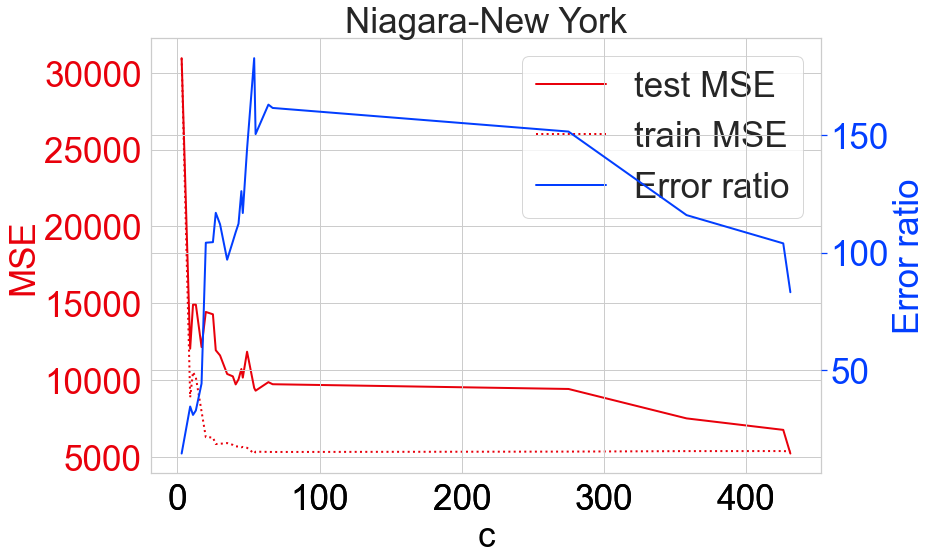

{3.0: 12700.71963051346, 6.0: 2902.660599930482, 7.0: 2033.688807838427, 9.0: 5179.906075888486, 10.0: 1827.9418738164184, 11.0: 1979.7214763718503, 12.0: 5107.292743072271, 13.0: 2993.2360748830583, 15.0: 3592.5091422065707, 19.0: 3265.900660959554, 20.0: 4674.5605352677885, 24.0: 5574.072004347603, 28.0: 5530.105160120663, 32.0: 3238.02076731398, 33.0: 3167.382810987665, 35.0: 3196.022947920092, 37.0: 3351.7400879507245, 38.0: 3599.098961012583, 45.0: 3322.051976107443, 46.0: 2645.158841079826, 49.0: 3122.4688732694062, 64.0: 3577.3044880226776, 68.0: 3475.356062885727, 72.0: 3442.0475592409093, 74.0: 3360.5373607397996, 86.0: 3205.3096161875874, 94.0: 2715.2182039981703, 142.0: 2726.636663615164, 181.0: 3009.725486706177, 185.0: 3633.323537545024, 191.0: 4282.799184074701, 193.0: 4416.739594766068, 201.0: 4484.046877368572} {3.0: 5.39440078034246, 6.0: 2.8182172921638755, 7.0: 2.327565394780263, 9.0: 3.926356861677707, 10.0: 2.317924462819851, 11.0: 2.8901759308478043, 12.0: 17.4902

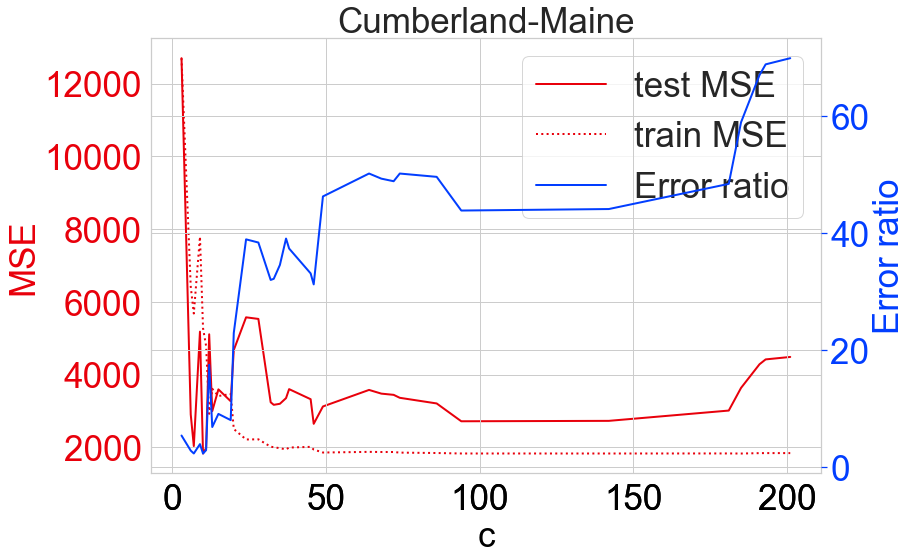

{2.0: 23000.948562759975, 3.0: 14545.545706219826, 10.0: 33754.87652142339, 11.0: 26246.548074074733, 12.0: 34188.36916770888, 13.0: 40624.6647117716, 16.0: 40258.50336707414, 17.0: 39902.81917247582, 20.0: 42327.69937980411, 23.0: 42792.99095118466, 28.0: 41853.197807740915, 31.0: 39409.32379066189, 32.0: 39712.7385265622, 33.0: 43310.162229877504, 35.0: 43453.163398070814, 38.0: 41378.114859509245, 40.0: 38721.66664669801, 41.0: 39601.26641051713, 46.0: 45051.08879526564, 50.0: 47601.86454257539, 52.0: 42411.32162627207, 57.0: 43267.90686465629, 65.0: 44277.02300377979, 89.0: 40804.67676024694, 94.0: 38964.08442776305, 269.0: 38434.52354705213, 351.0: 31785.20487337132, 468.0: 29833.204940255193, 491.0: 29230.02574958268} {2.0: 3.4667495586627, 3.0: 5.01541852759112, 10.0: 23.530843140216458, 11.0: 17.864817051993473, 12.0: 27.78745561518221, 13.0: 26.88905375455375, 16.0: 26.51751197772532, 17.0: 26.436652411481802, 20.0: 27.272174953325138, 23.0: 27.651554202760785, 28.0: 27.143579

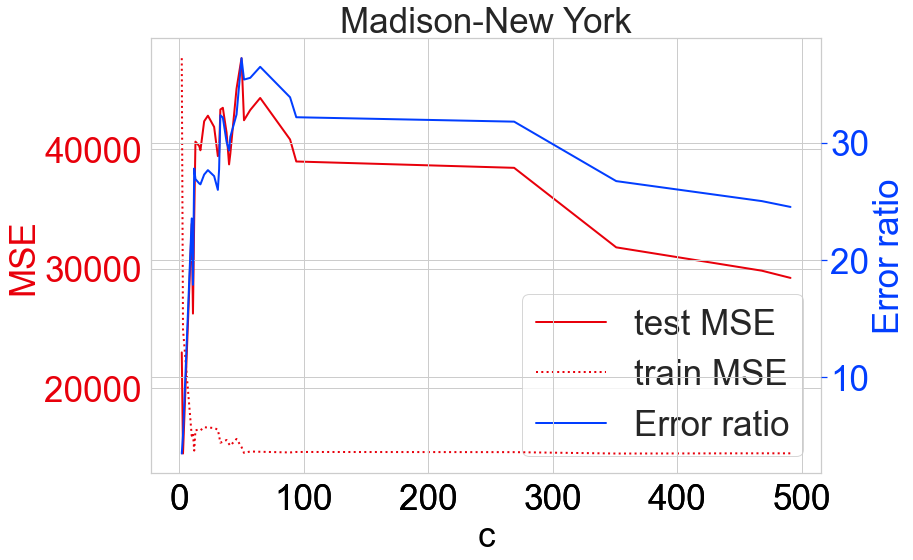

{3.0: 4203.682004963922, 8.0: 4331.156606839499, 10.0: 39728.136832679564, 11.0: 17102.44648140584, 12.0: 12538.05600308636, 14.0: 1720.8803348322654, 15.0: 1665.1327330001525, 16.0: 1353.5134912371636, 17.0: 994.1496812590698, 18.0: 987.1890946501311, 21.0: 852.6957708850235, 22.0: 960.3696486335134, 25.0: 982.2885841188989, 26.0: 1099.3610274094203, 27.0: 1183.6497783962234, 28.0: 1334.5672902273316, 29.0: 1278.1199597077555, 37.0: 1172.898218975977, 38.0: 1246.7499801926149, 42.0: 1652.734006229979, 53.0: 1638.2384833301721, 56.0: 1595.7819659735144, 59.0: 1669.943204616058, 69.0: 1593.5174304986351, 78.0: 1590.2935380855379, 112.0: 1452.092166163954, 116.0: 1306.1183507051028, 117.0: 1271.0245623085077, 408.0: 1206.2705249713556, 467.0: 1227.534807488355, 787.0: 1231.2003296615796} {3.0: 3.611848951329805, 8.0: 3.841332829219474, 10.0: 4.201689819884908, 11.0: 31.17571574871706, 12.0: 20.63771953300918, 14.0: 7.106272704891771, 15.0: 7.728740819610885, 16.0: 7.908851314376663, 17.0

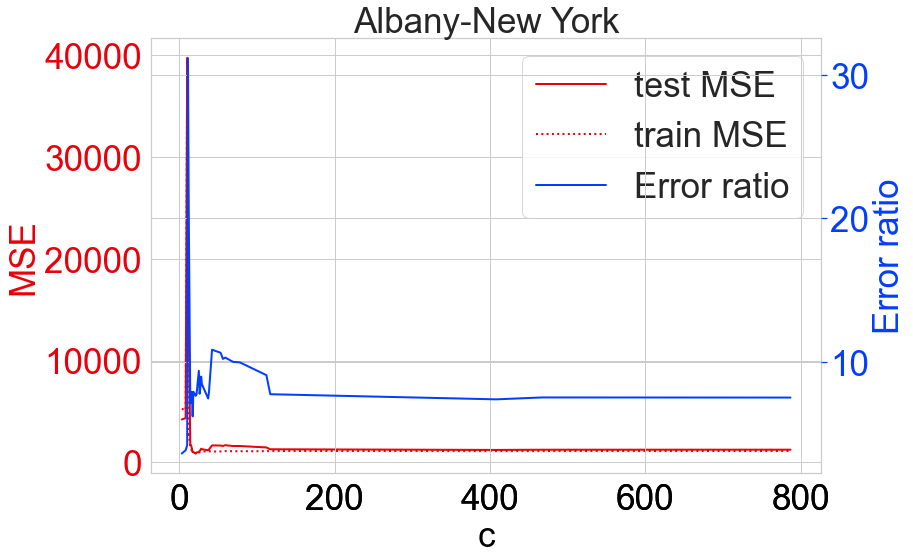

{2.0: 148941.8624288981, 3.0: 31226.725079642343, 4.0: 48016.73307604575, 5.0: 39729.894480758165, 6.0: 27806.02167740228, 8.0: 24266.590226278324, 9.0: 25042.963130550655, 10.0: 27402.67952934078, 12.0: 44364.79907280608, 14.0: 26806.29052954368, 16.0: 52766.83639985912, 17.0: 49256.6949797408, 20.0: 44308.53520366294, 22.0: 46685.56353073233, 30.0: 55872.713707955496, 41.0: 54048.85133799491, 50.0: 51821.54945670674} {2.0: 2.593245879501833, 3.0: 0.7743619206721062, 4.0: 1.5861133283229927, 5.0: 1.2013788219740156, 6.0: 0.9607311099550623, 8.0: 0.9004308943426271, 9.0: 0.8932440160010323, 10.0: 0.958886485348256, 12.0: 2.122499539538083, 14.0: 1.5238879522969948, 16.0: 3.2129355980512253, 17.0: 3.209232438812942, 20.0: 2.8784122906491874, 22.0: 3.07054927323393, 30.0: 3.8252527473367115, 41.0: 3.7038832347007453, 50.0: 3.5311415732501494}


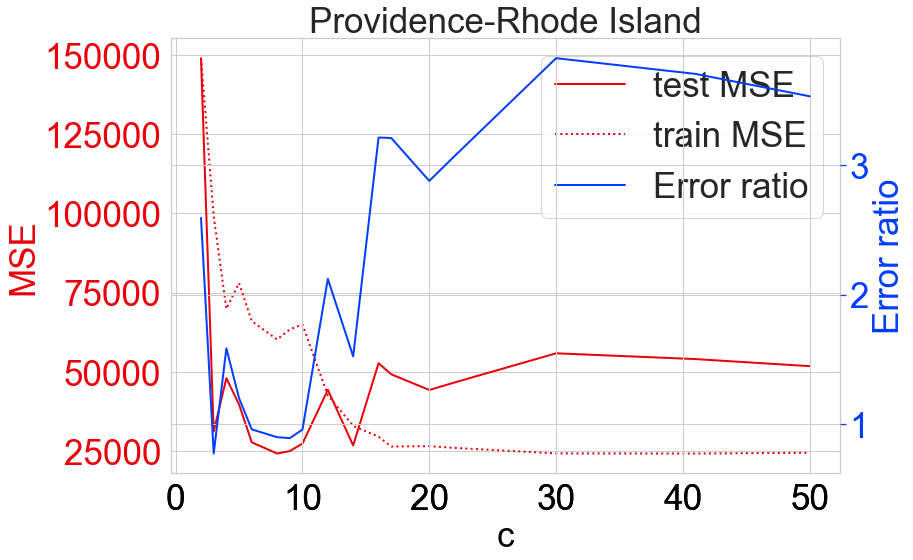

In [57]:

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
projection_period = df_pop.shape[0]
training_period = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

for state in cluster_2_counties:
    otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                  df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                    > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    otherStates = list(otherStates[otherStates.isin(donors)])
    if state in otherStates:
        otherStates.remove(state)

    rscModel = syn_model(state, singVals, [df], projection_period, training_period, otherStates=otherStates)
    rscModel.fit_model()

    perm_dict = rscModel.permutation_distribution(show_graph = False)
    perm_dict.pop(state) 
    selected = np.array(list(perm_dict.values()))
    selected2 = np.sort(np.ceil(selected))
    MSE_dict = {}
    err_ration_dict = {}
    error_mean = {}
    error_std = {}
    train_MSE_dict = {}

    for c in selected2:
        new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
        new_model = syn_model(rscModel.state,  rscModel.kSingularValues, [df], projection_period, training_period, otherStates=new_donor)
        new_model.fit_model()

        MSE_dict[c] = new_model.testing_error()
        train_MSE_dict[c] = new_model.training_error()
        err_ration_dict[c] = new_model.find_ri()

    print(MSE_dict, err_ration_dict)


    lines = [] 

    fig=plt.figure(figsize=(12,8))
    ax=fig.add_subplot(111, label="1")
    ax1=fig.add_subplot(111, label="1", frame_on=False)
    ax2=fig.add_subplot(111, label="2", frame_on=False)


    lines.append(ax.plot(*zip(*sorted(MSE_dict.items())), label = 'test MSE', color="r")[0])
    ax.set_xlabel("c", color="black",fontsize = FONTSIZE)
    ax.set_ylabel("MSE", color="r",fontsize = FONTSIZE)
    ax.tick_params(axis='x', colors="black",labelsize = FONTSIZE)
    ax.tick_params(axis='y', colors="r",labelsize = FONTSIZE)

    lines.append(ax1.plot(*zip(*sorted(train_MSE_dict.items())), color="r", label = 'train MSE', linestyle = ":")[0])
    ax1.set_xticks([])
    ax1.set_yticks([])



    lines.append(ax2.plot(*zip(*sorted(err_ration_dict.items())), label = '', color="b")[0])
    #ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1") 
    ax2.set_ylabel('Error ratio', color="b",fontsize = FONTSIZE)       
    #ax2.xaxis.set_label_position('top') 
    ax2.yaxis.set_label_position('right') 
    ax2.tick_params(axis='x', colors="black",labelsize = FONTSIZE)
    ax2.tick_params(axis='y', colors="b",labelsize = FONTSIZE)
    plt.title(state, fontsize = FONTSIZE)
    ax.legend(lines, ['test MSE', 'train MSE','Error ratio'], fontsize = FONTSIZE)


    plt.show()


In [58]:
# NY deaths: c = 29, NY cases: c = 13
#c = 5, c = 34, c = 3, c = 2, c = 3

Model fit vs denoiseDF for Niagara-New York
normal_noise_sv: {}


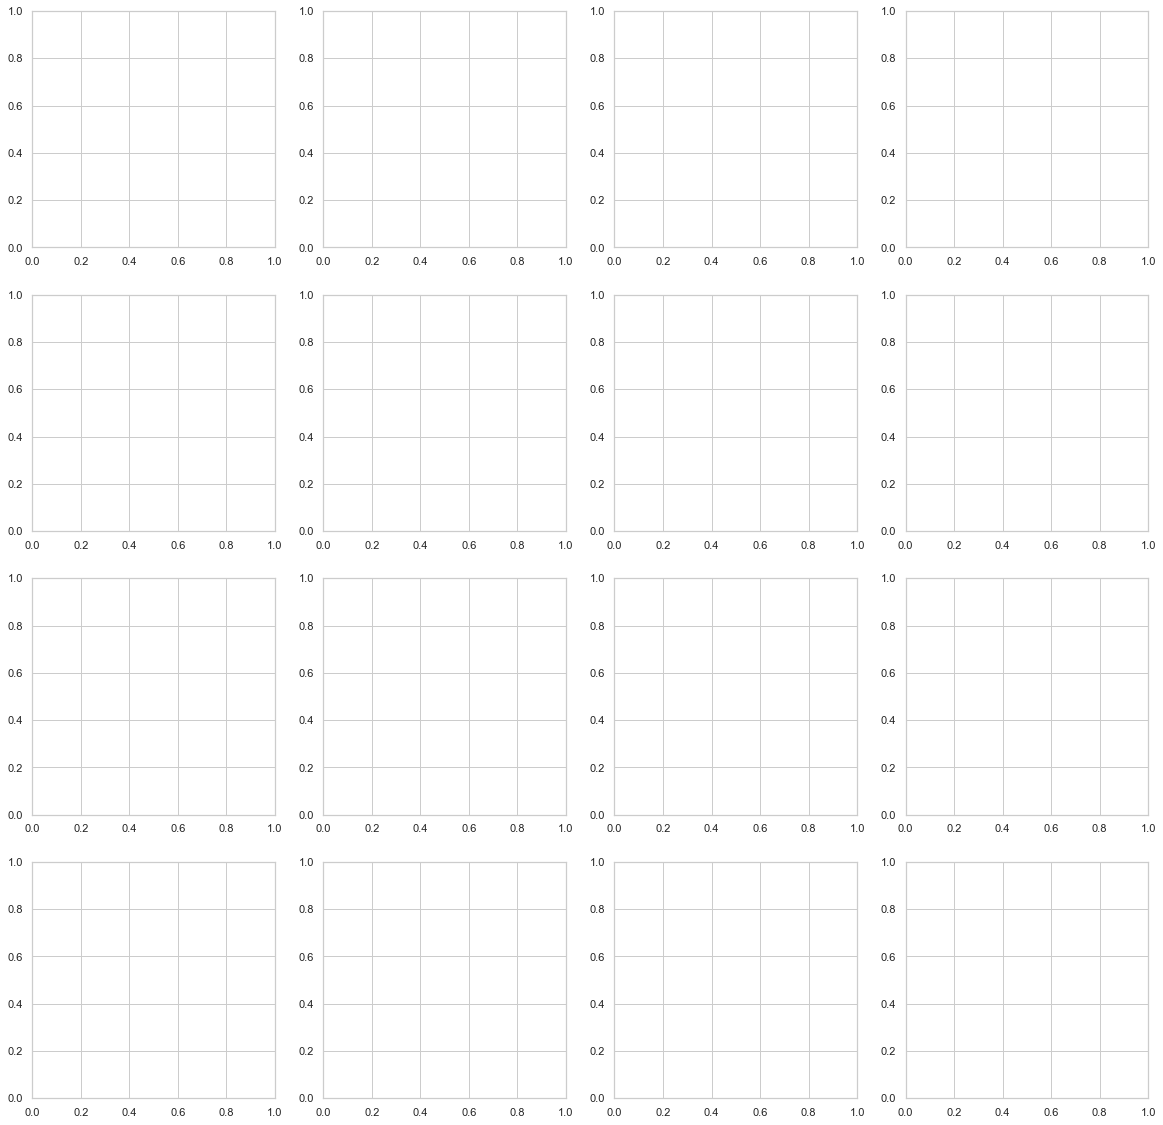

In [59]:
'''
The D statistic is the absolute max distance (supremum) between the CDFs of the two samples.
The closer this number is to 0 the more likely it is that the two samples were drawn from 
the same distribution. Check out the Wikipedia page for the k-s test. It provides a good 
explanation: https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

The p-value returned by the k-s test has the same interpretation as other p-values. 
You reject the null hypothesis that the two samples were drawn from the same distribution 
if the p-value is less than your significance level. The online tables for the 
conversion of the D statistic into a p-value can be found.
'''

fig, axes = plt.subplots(4, 4, figsize = (20, 20))
state_idx = 0
donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))



normal_noise_sv = {}
p_thresh = 0.95

for state in new_model_dict[0]:
    #normal_noise_sv[m.state] = []

    for i in range(15):
        donor_idx = 0
        m = new_model_dict[i][state]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        axes[i//4][i%4].hist(error)
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        (D_statistic,p_value) = kstest(error,'norm')
        #print(p_value)
        if p_value > p_thresh:
            if m.state not in normal_noise_sv:
                normal_noise_sv[m.state] = []
            normal_noise_sv[m.state].append(i)
         
        
print('normal_noise_sv:', normal_noise_sv)

## previous originial graphs 

In [11]:
FONTSIZE = 22

In [35]:
pop_scaled = create_population_adjusted_data(uscounties_cases, uscounties_population)
#cluster_2_states = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii
cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

        
targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


In [36]:
print(donors)

['Addison-Vermont', 'Albany-New York', 'Allegany-New York', 'Androscoggin-Maine', 'Aroostook-Maine', 'Atlantic-New Jersey', 'Barnstable-Massachusetts', 'Belknap-New Hampshire', 'Bennington-Vermont', 'Bergen-New Jersey', 'Berkshire-Massachusetts', 'Bristol-Massachusetts', 'Bristol-Rhode Island', 'Broome-New York', 'Burlington-New Jersey', 'Caledonia-Vermont', 'Camden-New Jersey', 'Cape May-New Jersey', 'Carroll-New Hampshire', 'Cattaraugus-New York', 'Cayuga-New York', 'Chautauqua-New York', 'Chemung-New York', 'Chenango-New York', 'Cheshire-New Hampshire', 'Chittenden-Vermont', 'Clinton-New York', 'Columbia-New York', 'Coos-New Hampshire', 'Cortland-New York', 'Cumberland-Maine', 'Cumberland-New Jersey', 'Delaware-New York', 'Dukes-Massachusetts', 'Dutchess-New York', 'Erie-New York', 'Essex-Massachusetts', 'Essex-New Jersey', 'Essex-New York', 'Essex-Vermont', 'Fairfield-Connecticut', 'Franklin-Maine', 'Franklin-Massachusetts', 'Franklin-New York', 'Franklin-Vermont', 'Fulton-New York

In [13]:

#print("Counterfactual analysis of Mask recommended counties based on a donor pool of Mask mandated counties")
#print("Intervention date: ", testDF.index[0])



In [60]:
p = np.random.randint(1, high=100, size=1000)
q = np.flip(p)
r = np.random.randint(1, high=100, size=1000)
s = np.flip(q)

print(distance.jensenshannon(p,p), distance.jensenshannon(p,q), distance.jensenshannon(p,r), distance.jensenshannon(p,s))


0.0 0.3091924092663234 0.31121945774581433 0.0


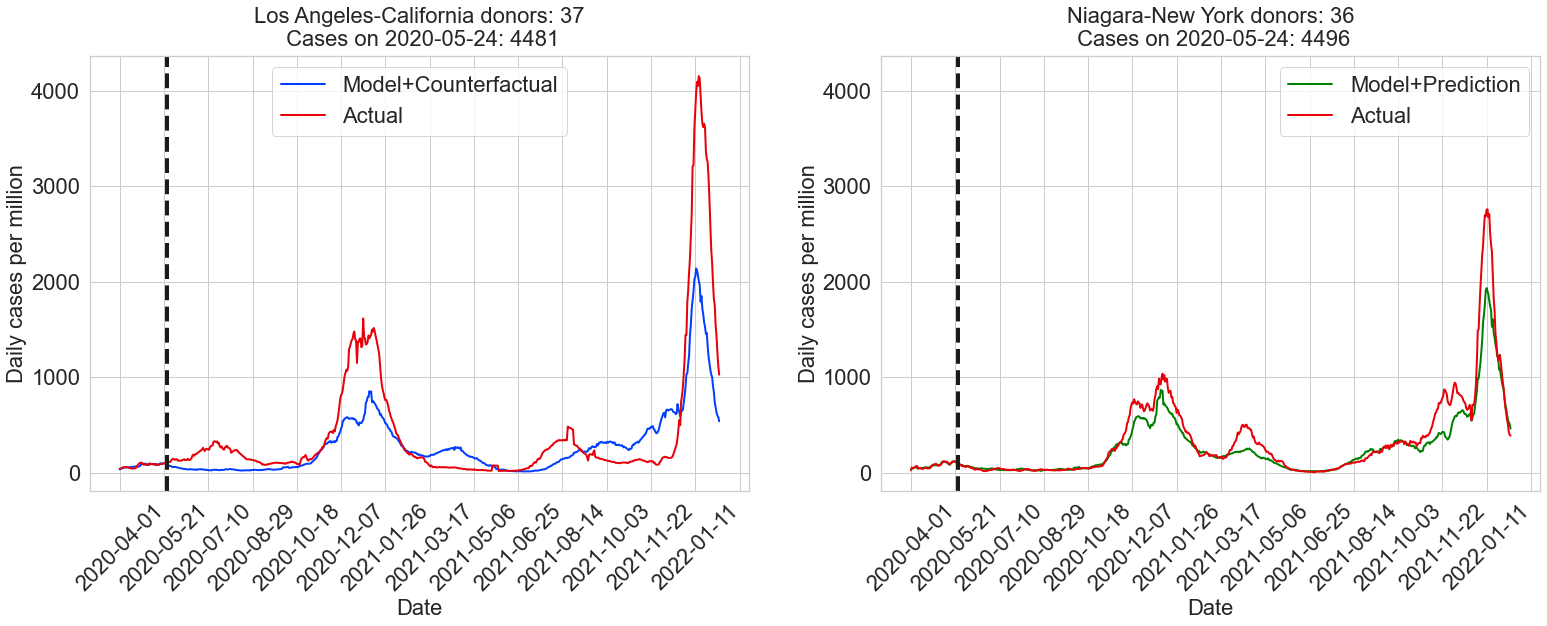

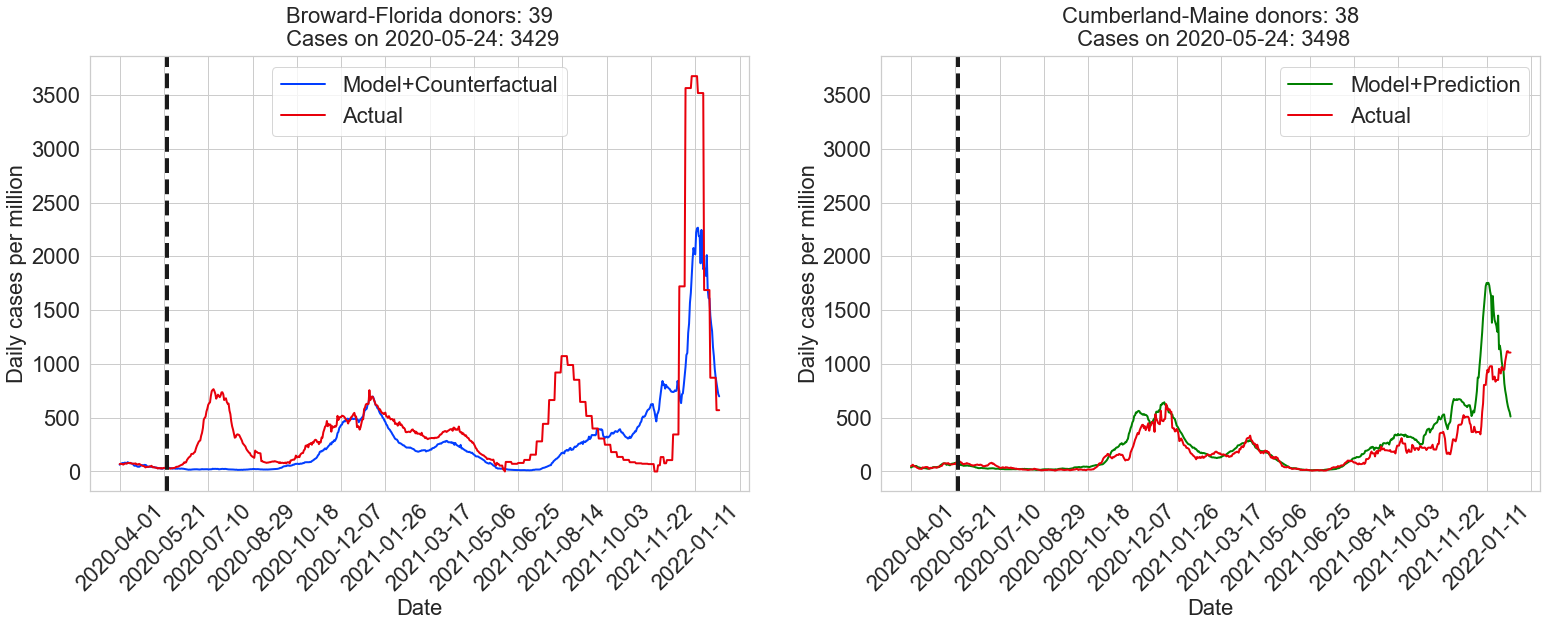

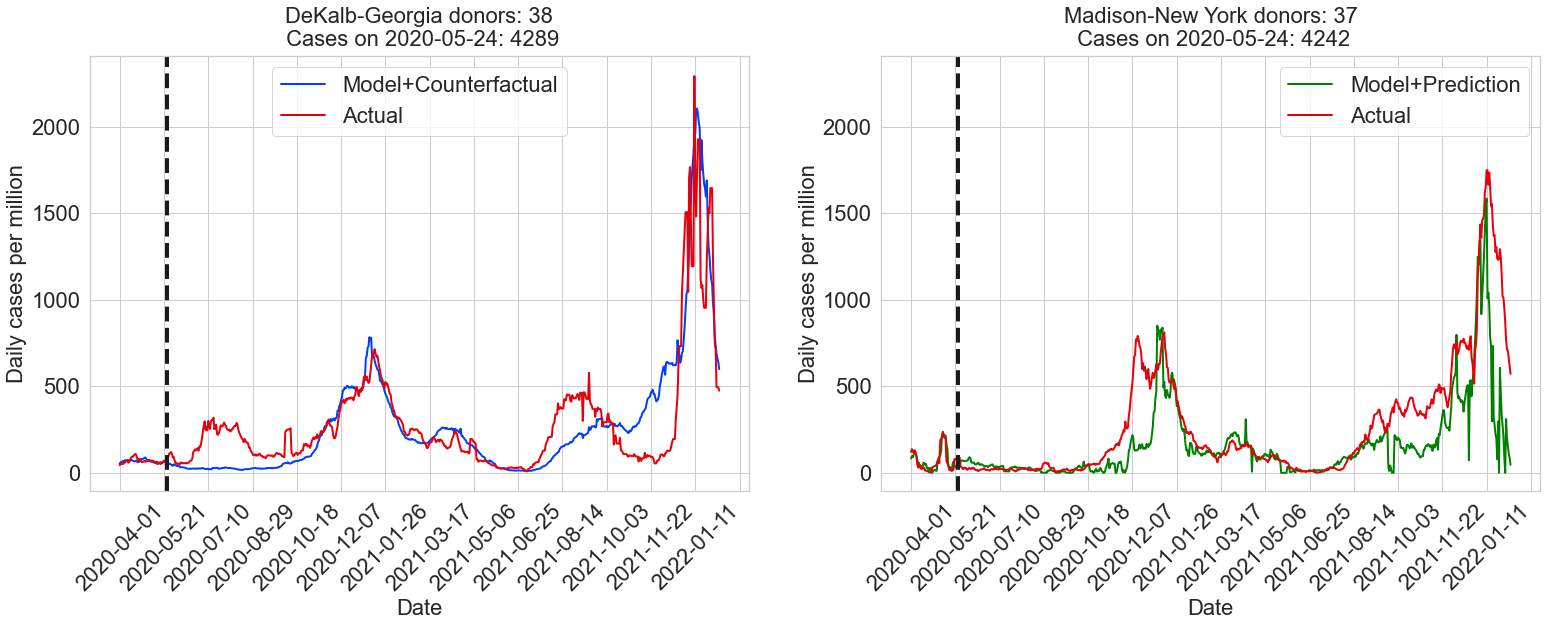

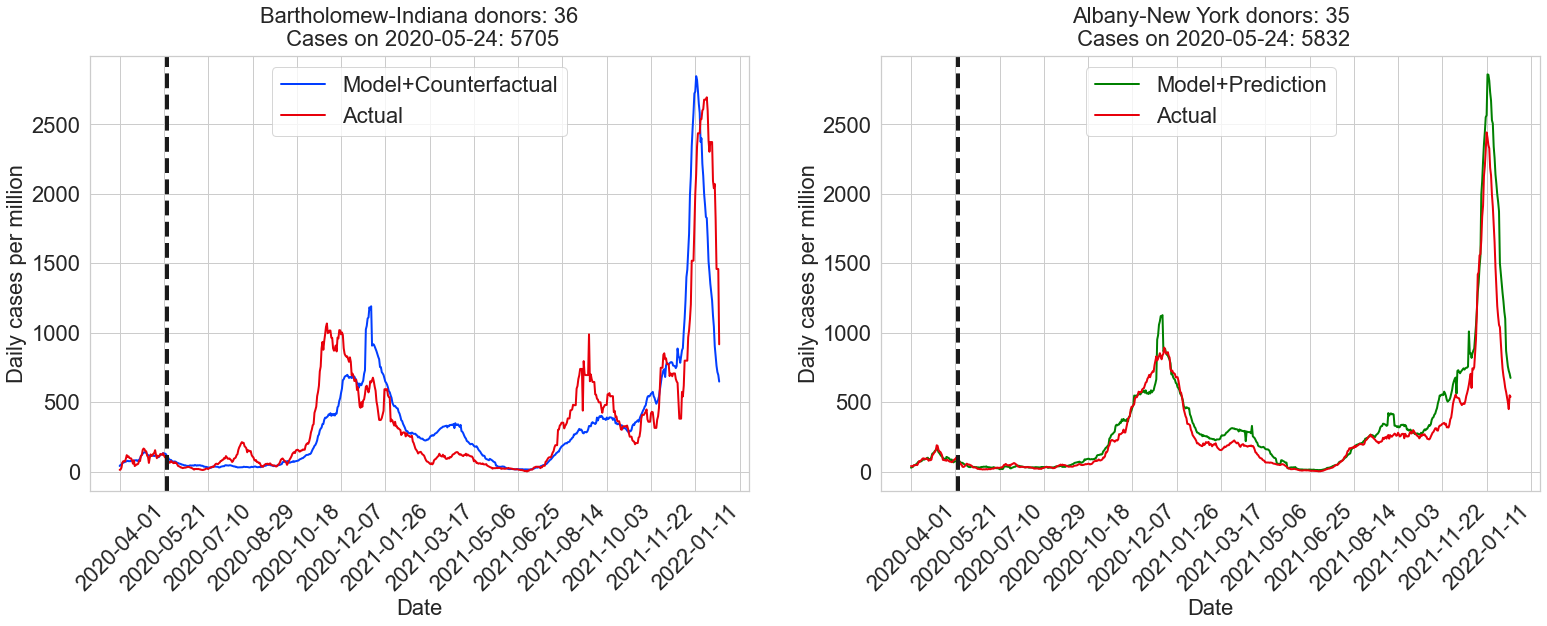

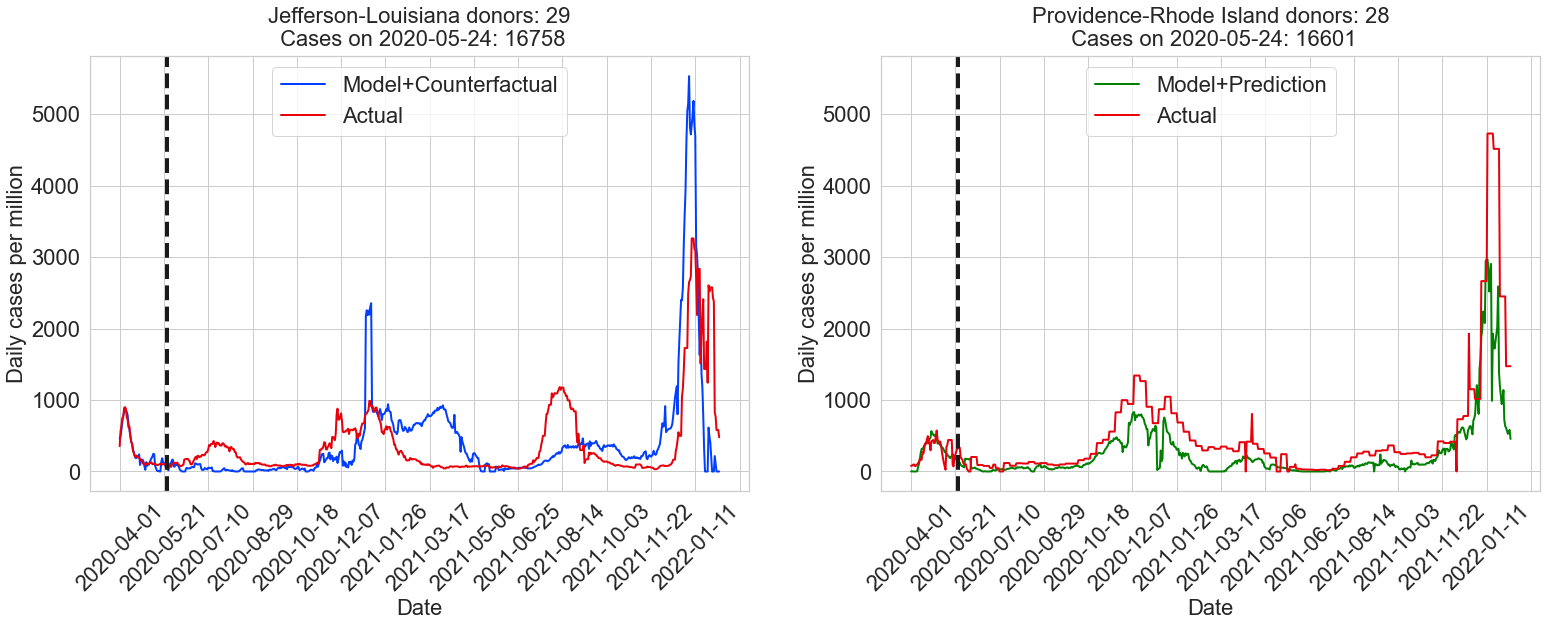

In [23]:
#df = df[df.columns[(df>100).any()]].copy()
donor_dist = []
counter_dist = []

start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=50
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in targets:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    '''
    otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
    '''
    if state in otherStates:
        otherStates.remove(state)
        
    '''
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit(trainDF)
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    print(model_fit, predictions)
       
        
    '''
    
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0
    
    #print(model_fit)
    #continue
        
    
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh:])
    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    #     if(fit_error > 20):
    #         print(state, fit_error)
    #         continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        print(state)
        continue
        


    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), 
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    counter_dist.append(distance.jensenshannon(np.concatenate((model_fit, predictions)), df[state].values))

        
    y_min, y_max = ax.get_ylim()


    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if new_state in otherStates:
        otherStates.remove(new_state)
    rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0

    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[new_state][low_thresh:])

    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
    plt.plot(df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
    
    donor_dist.append(distance.jensenshannon(np.concatenate((model_fit, predictions)), df[new_state].values))
    
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
    plt.ylim([y_min, y_max])
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
    #plt.savefig("../figures/"+state+".png")

    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    i=i+1

    plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()


In [29]:
print(sum(donor_dist)/len(donor_dist))
print(sum(counter_dist)/len(counter_dist))

0.14454309989239886
0.273398023867526


## compute average distance of distributions for all NE donors

In [37]:
import warnings
warnings.simplefilter('ignore')
#df = df[df.columns[(df>100).any()]].copy()
donor_dist = []

start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=50
#FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in donors:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    '''
    otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
    '''
    if state in otherStates:
        otherStates.remove(state)
        
    rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    
    # to ensure there aren't too few donors
    if len(rscModel.donors) < 3:
        continue
        
    print('target:', state)
    try:
        rscModel.fit_model(filter_donor = True, singVals_estimate = True)
        print('target rank estimation: ', rscModel.kSingularValues)
    except:
        rscModel.fit_model(filter_donor = True)
        print('target model rank estimation failed, rank 2 ued by default')
        
        
    predictions = rscModel.predictions 
    model_fit = rscModel.model_fit
    '''
    
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0
    
    #print(model_fit)
    #continue
    '''   
    
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh:])
    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    #     if(fit_error > 20):
    #         print(state, fit_error)
    #         continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        print(state)
        continue
        

    donor_dist.append(distance.jensenshannon(np.concatenate((model_fit, predictions)), df[state].values))



target: Addison-Vermont
target rank estimation:  6
target: Albany-New York
target rank estimation:  5
target: Allegany-New York
target rank estimation:  9
target: Androscoggin-Maine
target rank estimation:  7
target: Atlantic-New Jersey
target rank estimation:  4
target: Barnstable-Massachusetts
target rank estimation:  5
target: Belknap-New Hampshire
target rank estimation:  9
target: Bennington-Vermont
target rank estimation:  7
target: Bergen-New Jersey
target rank estimation:  2
target: Berkshire-Massachusetts
target rank estimation:  5
target: Bristol-Massachusetts
target rank estimation:  3
target: Bristol-Rhode Island
target rank estimation:  5
target: Broome-New York
target rank estimation:  5
target: Burlington-New Jersey
target rank estimation:  2
target: Caledonia-Vermont
target rank estimation:  6
target: Camden-New Jersey
target rank estimation:  3
target: Cape May-New Jersey
target rank estimation:  4
target: Carroll-New Hampshire
target rank estimation:  9
target: Cattar

AssertionError: 

In [50]:
print(sum(donor_dist)/len(donor_dist))


0.14440719910308356


In [31]:
print(sum(donor_dist)/len(donor_dist)) # 0.38305072034430065



0.38305072034430065


In [54]:
from sklearn.metrics import mean_squared_error

def find_testing_diversion(y_actual, y_pred):
    #return np.sum((y_actual - y_pred) ** 2) / len(y_actual)/np.sqrt(np.square(y_actual).sum())
    
    return np.sum((y_actual - y_pred) ** 2) / len(y_actual) 

#df = pop_scaled.loc['2020-04-01':]
df = all_cases_data_pop_daily.loc['2020-04-01':]

date_check = '2020-05-25'

high_thresh = df.shape[0]
low_thresh = 53
singVals=4

all_diversion = {}
donor_diversion = {}

trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh:high_thresh,:]


for i in range(1000, 20000, 1000):
    
    
    counties_close = find_close(pop_scaled, date_check, i, 500, \
                          county = True)
    
    targets = list(set(counties_close) - set(donors))
    donorpool_counties = list(set(counties_close).intersection(donors))
       
    
    cur_diversion = 0
    d_diversion = 0
    
    target_counts = 0
    donor_counts = 0
    
    for state in targets:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(df[state][low_thresh:],predictions)
        diversion = find_testing_diversion(df[state][low_thresh:], predictions)/pop_scaled.loc['2020-05-25'][state]
            
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for targets)')
            continue
        if diversion == float("inf"):
            continue
        
        cur_diversion += diversion
        target_counts += 1
    
    all_diversion[i] = ([cur_diversion/target_counts,target_counts] )
    if len(donorpool_counties) == 0:
        #print(i, 'Cluster 2 counties is 0')
        continue    
    for state in donorpool_counties:
    
        #otherStates =  donorpool.copy()
        otherStates = df.columns[(df.iloc[low_thresh] < 
                                  df[state].iloc[low_thresh]+.5*df[state].iloc[low_thresh])&(df.iloc[low_thresh]
                                                                                                     > df[state].iloc[low_thresh]-0.5*df[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        
        if state in otherStates:
            otherStates.remove(state)
            
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(df[state][low_thresh:],predictions)
        diversion = find_testing_diversion(df[state][low_thresh:], predictions)/pop_scaled.loc['2020-05-25'][state]
        #diversion = mean_squared_error(predictions,df[state][low_thresh:])/pop_scaled.loc['2020-05-25'][state]
        
        if len(otherStates) < 10:
            #print(state, 'donorpools is less than 10 (for cluster 2 counties)')
            continue
 
        
        if(fit_error > 20):
            #print(state, 'error is: ', fit_error)
            continue
        if diversion == float("inf"):
            continue
        donor_counts += 1 
        d_diversion += diversion
    donor_diversion[i] = ([d_diversion/donor_counts, donor_counts])


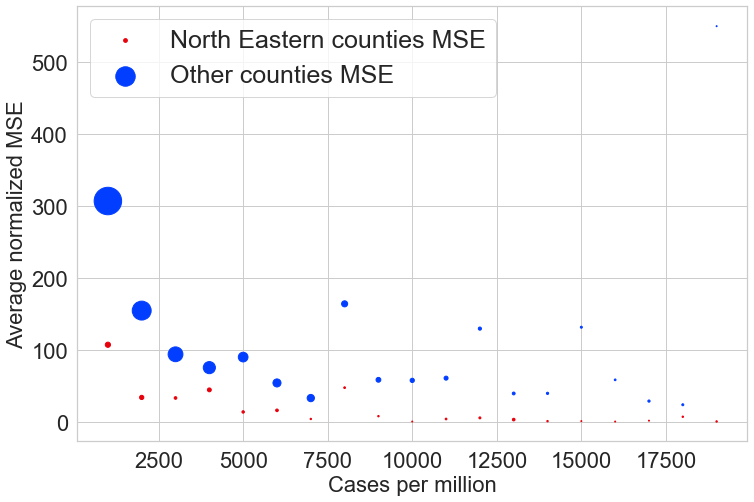

In [55]:
FONTSIZE = 22

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = (12, 8.0)
#plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
values = list(donor_diversion.values())
plt.scatter(donor_diversion.keys(), [i[0] for i in values], s = [i[1] for i in values], c = 'r', label = 'North Eastern counties MSE')

values = list(all_diversion.values())
plt.scatter(list(all_diversion.keys()), [i[0] for i in values], s = [i[1] for i in values], label = 'Other counties MSE')
ax.yaxis.get_offset_text().set_fontsize(FONTSIZE)
#plt.ylim([0,1300])
#plt.title('Average diversion for counties with close infection rates using states with bars and restuarants closed as donor pool')
plt.ylabel('Average normalized MSE',fontsize = FONTSIZE)
plt.xlabel('Cases per million',fontsize = FONTSIZE)
plt.legend(fontsize = 25)
#plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)
plt.savefig('../Figures/COVID/infections_compare.pdf', bbox_inches='tight')
plt.show()




# Toy Example

In [66]:
x = np.arange(1, 100, 1)
a = np.sin(x + 1) * 1
b = np.sin(x/2) * 3
c = np.sin(4*x + 3) * 0.25
d = np.sin(2*x-3) * 0.4

data = a + b + c + d


toy_df = {}
for i in range(50):
    err = 0.2*np.random.uniform(-1,1,size = 99)
    toy_df[i] = np.random.rand() * a + np.random.rand() * b + np.random.rand() * c + np.random.rand() * d + err

In [67]:
toy_df = pd.DataFrame(toy_df)

intervention = 30
toy_df

#scaler
print(np.sum(np.square((toy_df[0][:intervention] - toy_df.iloc[:intervention][0].mean())))/(intervention-1))



3.977498311871901


In [68]:
m = syn_model(0, 4, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
m.fit_model(force_positive=False)
#vector
print(np.sum(np.square((toy_df[0][:intervention] - m.denoisedDF[0])))/(intervention-1))

0.01113311181786114


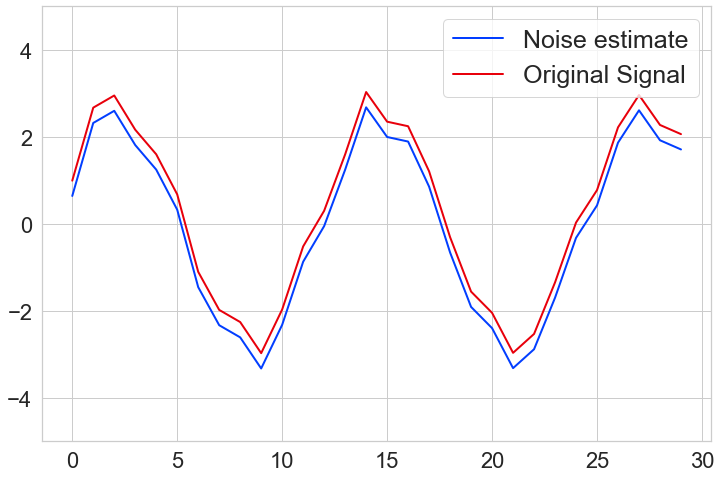

In [69]:
FONTSIZE = 22

fig, axes = plt.subplots(1, 1, figsize = (12, 8))
plt.plot(toy_df[0][:intervention] - toy_df.iloc[:intervention][0].mean(), label='Noise estimate'), 
plt.plot(toy_df[0][0:intervention], label='Original Signal')

ax.yaxis.get_offset_text().set_fontsize(FONTSIZE)
plt.ylim([-5,5])
#plt.title('Average diversion for counties with close infection rates using states with bars and restuarants closed as donor pool')
#plt.ylabel('Average normalized MSE',fontsize = FONTSIZE)
#plt.xlabel('Cases per million',fontsize = FONTSIZE)
plt.legend(fontsize = 25)
#plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)
plt.savefig('../Figures/COVID/faultyestimate.pdf', bbox_inches='tight')
plt.show()


#plt.plot(toy_df[0][:intervention] - m.denoisedDF[0])


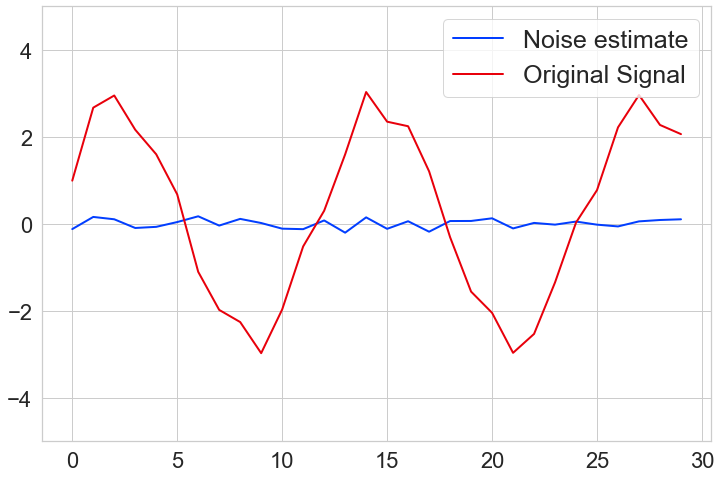

In [70]:
fig, axes = plt.subplots(1, 1, figsize = (12, 8))

plt.plot(toy_df[0][:intervention] - m.denoisedDF[0], label='Noise estimate'), 
plt.plot(toy_df[0][0:intervention], label='Original Signal'), 
ax.yaxis.get_offset_text().set_fontsize(FONTSIZE)
plt.ylim([-5,5])
#plt.title('Average diversion for counties with close infection rates using states with bars and restuarants closed as donor pool')
#plt.ylabel('Average normalized MSE',fontsize = FONTSIZE)
#plt.xlabel('Cases per million',fontsize = FONTSIZE)
plt.legend(fontsize = 25)
#plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=FONTSIZE)
plt.savefig('../Figures/COVID/correctestimate.pdf', bbox_inches='tight')
plt.show()

#plt.plot(toy_df[0][:intervention] - m.denoisedDF[0])
